In [4]:
import requests
from IPython.core.display import HTML
from torch import optim
import tensorboard
from trainers import PyTorchTrainer
from networks import *
from torchvision import transforms
from cnn_util import *
from fashionmnist_utils.mnist_reader import load_mnist
from models import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from trainers import PyTorchTrainer
from torchvision import transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from networks import CNNBasic
from cnn_util import evaluate_overall_metrics, evaluate
from trainers import PyTorchTrainer


# Global flag to skip training
SKIP_TRAINING = False


# Notes

## Batch size
Batch size = 1: Model updates after 1 data point. (1024 steps for 1024 data points)
Batch size = 512: Model updates after 512 data points. (2 steps for 1024 data points)
Batch size = 1024: Model updates after all 1024 data points. (1 step for 1024 data points)

# Neural network architectures
This exercise focuses on the classification of the FashionMNIST dataset using two types of neural network architectures: the Multi-Layer Perceptron (MLP) and the Convolutional Neural Network (CNN). The performance of these models will be assessed using the evaluation metrics introduced in earlier exercises.

<article class="message">
    <div class="message-body">
        <strong>List of individual tasks</strong>
        <ul style="list-style: none;">
            <li>
            <a href="#MLP1">Task 1: Training basic MLP</a>
            </li>
            <li>
            <a href="#MLP3">Task 2: Evaluation</a>
            </li>
            <li>
            <a href="#MLP33">Task 3: Training basic MLP modifying hyperparame…</a>
            </li>
            <li>
            <a href="#MLP33333">Task 4: Comparison</a>
            </li>
            <li>
            <a href="#CNN1">Task 5: CNN architecture</a>
            </li>
            <li>
            <a href="#CNN11">Task 6: Training a basic CNN</a>
            </li>
            <li>
            <a href="#CNN21">Task 7: Evaluation</a>
            </li>
            <li>
            <a href="#CNN211">Task 8: Training a basic CNN modifying hyperpara…</a>
            </li>
            <li>
            <a href="#CNN3">Task 9: Evaluation</a>
            </li>
            <li>
            <a href="#CNN311">Task 10: Evaluation</a>
            </li>
            <li>
            <a href="#modifications">Task 11: Adding a hidden layer</a>
            </li>
            <li>
            <a href="#CNN20101">Task 12: Compare performance</a>
            </li>
            <li>
            <a href="#CNN_mod">Task 13: Compare architectures</a>
            </li>
            <li>
            <a href="#CNN233">Task 14: Compare performance</a>
            </li>
            <li>
            <a href="#CNN2123">Task 15: Update architecture</a>
            </li>
            <li>
            <a href="#modifications3">Task 16: Adding a convolutional layer</a>
            </li>
            <li>
            <a href="#CNN003">Task 17: Compare architectures</a>
            </li>
            <li>
            <a href="#modifications4">Task 18: Compare architectures</a>
            </li>
            <li>
            <a href="#additional">Task 19: Additional improvements</a>
            </li>
        </ul>
    </div>
</article>


**Time sink warning**
This exercise examines the impact of network architectures and hyperparameters on training and performance. **Notice getting optimal results can become a time sink. Make well-argued choices as endless options and combinations are available.** Focus on informed decisions given the vast number of options available. Most of the code is provided requiring only modifications to hyperparameter settings and network architecture. This setup allows for focused analysis of outcomes and their connection to theoretical concepts.

## Modifying hyperparameters
This part of the exercise introduces and experiments with the hyperparameters of an NN such as the _Learning rate_ and the _batch size_. 
### Multilayer Perceptron
The following tasks are about training and modifying an MLP to classify the FashionMNIST dataset. The following functions will be used throughout the exercise:
- `train_pytorch_network`
: takes an NN class as a parameter. Used for model training and for visualizing the performance of the models throughout the exercise. 
- `evaluate_overall_metrics`
 in the `cnn_util.py`
 file takes a dictionary containing a key-value pair of a name and a file path to the trained model and a list with the class names. The function returns a plot showing the overall _accuracy_, _precision_ and _recall_ for the validation data, comparing each model trained. 
- `evaluate`
 in the `cnn_util.py`
 file takes a dictionary containing a key-value pair of a name and a file path to the trained model and a list with the class names. The function computes a confusion matrix as well as provides plots visualizing _Accuracy_, _Precision_ and _Recall_ class-wise for the validation data, comparing each model trained. 


---
**Task 1 (easy): Training basic MLP👩‍💻💡**
1. Examine the `networks.py`
 file and locate the `MLPBasic()`
 class. Examine the class to gain an overview of the network architecture.
2. Run the cell below to train the MLP. The cell will automatically save the trained model in the `models/`
 directory.


---

# Task 1 notes

We changed the trainer functions to accept parameters used throughout this assignment.
As such we also changed them to use our custom version of 'MLP_modified' and 'CNNCustom'

In [5]:
# Create the 'models' folder
os.makedirs("models", exist_ok=True)
# Create the 'runs' folder
os.makedirs("runs", exist_ok=True) 
    
# CUSTOM MODIFIED VERSION, TO HANDLE DYNAMICALLY SET SETTINGS.
class MLP_modified(nn.Module):
    def __init__(self, input_size=784, hidden_layers=[100, 256], output_size=10, activation_fn='relu',dropout = 0.0):
        """
        A parameterized Multi-Layer Perceptron.

        Args:
        - input_size (int): Number of input features (e.g., 28x28 for MNIST).
        - hidden_layers (list): List of integers specifying the number of nodes in each hidden layer.
        - output_size (int): Number of output features (e.g., 10 for classification).
        - activation_fn (str): Activation function to use ('relu', 'leaky_relu', 'elu', 'gelu').
        """
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        # Store the activation function
        self.activation_fn = activation_fn

        # Define the network layers
        layers = []
        layer_sizes = [input_size] + hidden_layers

        # Create fully connected hidden layers
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))

        # Add the output layer
        layers.append(nn.Linear(layer_sizes[-1], output_size))

        # Save the layers as a module list
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Flatten input
        x = torch.flatten(x, start_dim=1)

        # Pass through each layer with activation
        for i, layer in enumerate(self.layers):
            x = layer(x)
            
            # Apply activation function to all layers except the last one
            if i < len(self.layers) - 1:
                x = self._apply_activation(x)

        return x

    def _apply_activation(self, x):
        """Apply the specified activation function."""
        if self.activation_fn == 'relu':
            return F.relu(x)
        elif self.activation_fn == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.01)
        elif self.activation_fn == 'elu':
            return F.elu(x)
        elif self.activation_fn == 'gelu':
            return F.gelu(x)
        else:
            raise ValueError(f"Unsupported activation function: {self.activation_fn}")


def train_pytorch_network_mlp(input_size=784, hidden_layers=[100, 256], output_size=10, activation_fn='relu', 
                              learning_rate=1e-2, batch_size=128, epochs=10, model_name=None, dropout=0.0):
    """
    Train an MLP model with custom parameters, evaluate it, and save the model.

    Args:
    - input_size (int): Number of input features.
    - hidden_layers (list): List of integers specifying hidden layers.
    - output_size (int): Number of output classes.
    - activation_fn (str): Activation function ('relu', 'leaky_relu', 'elu', 'gelu').
    - learning_rate (float): Learning rate for the optimizer.
    - batch_size (int): Batch size for training.
    - epochs (int): Number of training epochs.
    - model_name (str): Custom name for the model (saved file name).

    Returns:
    - str: Filename of the saved model.
    """
    # Generate the filename based on the parameters
    model_name = model_name or "MLPModified"
    filename = f"{model_name}_lr{learning_rate}_bs{batch_size}".replace('.', 'p')

    if SKIP_TRAINING:
        print(f"Skipping training for {model_name}. Returning filename: models/{filename}.pkl")
        return f"models/{filename}.pkl"

    # Define the model
    model = MLP_modified(
        input_size=input_size,
        hidden_layers=hidden_layers,
        output_size=output_size,
        activation_fn=activation_fn,
        dropout=dropout
    )

    # Define the training setup
    trainer = PyTorchTrainer(
        nn_module=model,
        transform=transforms.ToTensor(),
        optimizer=optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5),
        batch_size=batch_size
    )

    # Train the model
    print(f"Training {model_name}...")
    trainer.train(epochs)

    # Evaluate the model
    logger, predictions = trainer.evaluate()
    print(f"Evaluation completed. Logger: {logger}")
    trainer.plot_metrics(['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
                          'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'])

    # Set the trainer name for consistent filename generation
    trainer.name = model_name

    # Save the model
    trainer.save(lr=learning_rate, batch_size=batch_size)
    file_path = f"models/{filename}.pkl"
    print(f"Training and evaluation completed. Model saved at: {file_path}")

    return file_path



class CNNCustom(nn.Module):
    def __init__(self, input_channels=1, conv_layers=[(8, 9), (16, 3)], 
                 fully_connected_hidden_layers=[60, 10], activation_fn='relu',dropout = 0.0):
        """
        A parameterized CNN.

        Args:
        - input_channels (int): Number of input channels (e.g., 1 for grayscale images).
        - conv_layers (list): List of tuples specifying (num_kernels, kernel_size).
                              For example, [(8, 9), (16, 3)] corresponds to CNNBasic's layers.
        - fc_layers (list): List of integers specifying fully connected layers.
                            For example, [60, 10] corresponds to CNNBasic's linear layers.
        - activation_fn (str): Activation function to use ('relu', 'leaky_relu', etc.).
        """
        super().__init__()
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(dropout)

        # Define convolutional layers
        self.conv_layers = nn.ModuleList()
        in_channels = input_channels
        for out_channels, kernel_size in conv_layers:
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size))
            in_channels = out_channels

        # Compute the output size after convolutions
        self.conv_output_size = self._calculate_conv_output_size(input_size=(28, 28), 
                                                                 conv_layers=conv_layers)

        # Define fully connected layers
        fc_layer_sizes = [self.conv_output_size] + fully_connected_hidden_layers
        self.fc_layers = nn.ModuleList()
        for i in range(len(fc_layer_sizes) - 1):
            self.fc_layers.append(nn.Linear(fc_layer_sizes[i], fc_layer_sizes[i + 1]))

    def forward(self, x):
        #print(f"Input: {x.size(1)} channels of {x.size(2)}x{x.size(3)}")  # Debug: Initial input size

        # Pass through convolutional layers
        for idx, conv in enumerate(self.conv_layers):
            x = conv(x)
            #print(f"Conv{idx + 1}: {x.size(1)} activation maps of {x.size(2)}x{x.size(3)}")  # Debug: After each convolution
            x = self._apply_activation(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)  # Max pooling after each convolution
            #print(f"MaxPool{idx + 1}: {x.size(1)} activation maps of {x.size(2)}x{x.size(3)}")  # Debug: After each max pooling

        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, start_dim=1)
        #print(f"Flattened: {x.size(1)} features")  # Debug: After flattening

        # Pass through fully connected layers
        for idx, fc in enumerate(self.fc_layers):
            x = fc(x)
            if idx < len(self.fc_layers) - 1:  # Apply activation only for hidden layers
                #print(f"FC{idx + 1}: {x.size(1)} features (hidden layer)")
                x = self._apply_activation(x)
            #else:
                #print(f"Output: {x.size(1)} features (final layer)")  # Debug: Output layer

        return x

    def _apply_activation(self, x):
        """Apply the specified activation function."""
        if self.activation_fn == 'relu':
            return F.relu(x)
        elif self.activation_fn == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.01)
        else:
            raise ValueError(f"Unsupported activation function: {self.activation_fn}")

    def _calculate_conv_output_size(self, input_size, conv_layers):
        """
        Calculate the size of the flattened tensor after convolutions and pooling.

        Args:
        - input_size (tuple): Height and width of the input image (e.g., (28, 28)).
        - conv_layers (list): List of tuples specifying (num_kernels, kernel_size).

        Returns:
        - int: Size of the flattened tensor.
        """
        height, width = input_size
        for _, kernel_size in conv_layers:
            height = height - (kernel_size - 1)
            width = width - (kernel_size - 1)
            height, width = height // 2, width // 2  # Account for max pooling

        return height * width * conv_layers[-1][0]  # Final feature map size × number of channels


def train_pytorch_network_cnn(input_channels=1, conv_layers=[(16, 5), (32, 3)], fully_connected_hidden_layers=[128, 10], 
                              activation_fn='relu', learning_rate=1e-2, batch_size=128, epochs=10, model_name=None, dropout=0.1):
    """
    Train a CNN model with custom parameters, evaluate it, and save the model.

    Args:
    - input_channels (int): Number of input channels (e.g., 1 for grayscale images).
    - conv_layers (list): List of tuples for convolutional layers (num_kernels, kernel_size).
    - fc_layers (list): List of integers for fully connected layers.
    - activation_fn (str): Activation function ('relu', 'leaky_relu', 'elu', 'gelu').
    - learning_rate (float): Learning rate for the optimizer.
    - batch_size (int): Batch size for training.
    - epochs (int): Number of training epochs.
    - model_name (str): Custom name for the model (saved file name).

    Returns:
    - str: Filename of the saved model.
    """
    # Generate the filename based on the parameters
    model_name = model_name or "CNNCustom"
    filename = f"{model_name}_lr{learning_rate}_bs{batch_size}".replace('.', 'p')

    if SKIP_TRAINING:
        print(f"Skipping training for {model_name}. Returning filename: models/{filename}.pkl")
        return f"models/{filename}.pkl"

    # Define the model
    model = CNNCustom(input_channels=input_channels, conv_layers=conv_layers, fully_connected_hidden_layers=fully_connected_hidden_layers, activation_fn=activation_fn,dropout=dropout)

    # Define the trainer
    trainer = PyTorchTrainer(
        nn_module=model,
        transform=transforms.ToTensor(),
        optimizer=optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5),
        batch_size=batch_size
    )

    # Train the model
    print(f"Training {model_name}...")
    trainer.train(epochs)

    # Evaluate the model
    logger, predictions = trainer.evaluate()
    print(f"Evaluation completed. Logger: {logger}")
    trainer.plot_metrics(['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
                          'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'])

    # Update the trainer's name for consistent filename generation
    trainer.name = model_name

    # Save the model
    trainer.save(lr=learning_rate, batch_size=batch_size)
    file_path = f"models/{filename}.pkl"
    print(f"Training and evaluation completed. Model saved at: {file_path}")

    return file_path

## Task 1 reflection
**Overview of MLPBasic**: 
A two-layer architecture (1 hidden, 1 output)

**Input** 784 neurons, stemming from our 28x28 greyscale image.

**Hidden layer** 100 neurons, with Relu activation

**Output**  10 output units with Softmax activation, to convert it to probabilies of t-shirt, trousers, etc.

Training MLPBasic_task1...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 141.75it/s]


[Validation] Epoch 1: acc: 0.7320, val_loss: 0.8070, train_acc: 0.6277
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 139.33it/s]


[Validation] Epoch 2: acc: 0.7851, val_loss: 0.6510, train_acc: 0.6927
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 136.49it/s]


[Validation] Epoch 3: acc: 0.8070, val_loss: 0.5775, train_acc: 0.7269
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 147.62it/s]


[Validation] Epoch 4: acc: 0.8192, val_loss: 0.5374, train_acc: 0.7484
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 148.97it/s]


[Validation] Epoch 5: acc: 0.8244, val_loss: 0.5138, train_acc: 0.7632
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 150.49it/s]


[Validation] Epoch 6: acc: 0.8289, val_loss: 0.4987, train_acc: 0.7742
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 148.47it/s]


[Validation] Epoch 7: acc: 0.8318, val_loss: 0.4876, train_acc: 0.7826
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 141.47it/s]


[Validation] Epoch 8: acc: 0.8372, val_loss: 0.4726, train_acc: 0.7894
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 146.42it/s]


[Validation] Epoch 9: acc: 0.8376, val_loss: 0.4666, train_acc: 0.7951
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 146.42it/s]


[Validation] Epoch 10: acc: 0.8415, val_loss: 0.4615, train_acc: 0.7998


100%|██████████| 79/79 [00:00<00:00, 149.06it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62E1D1390>


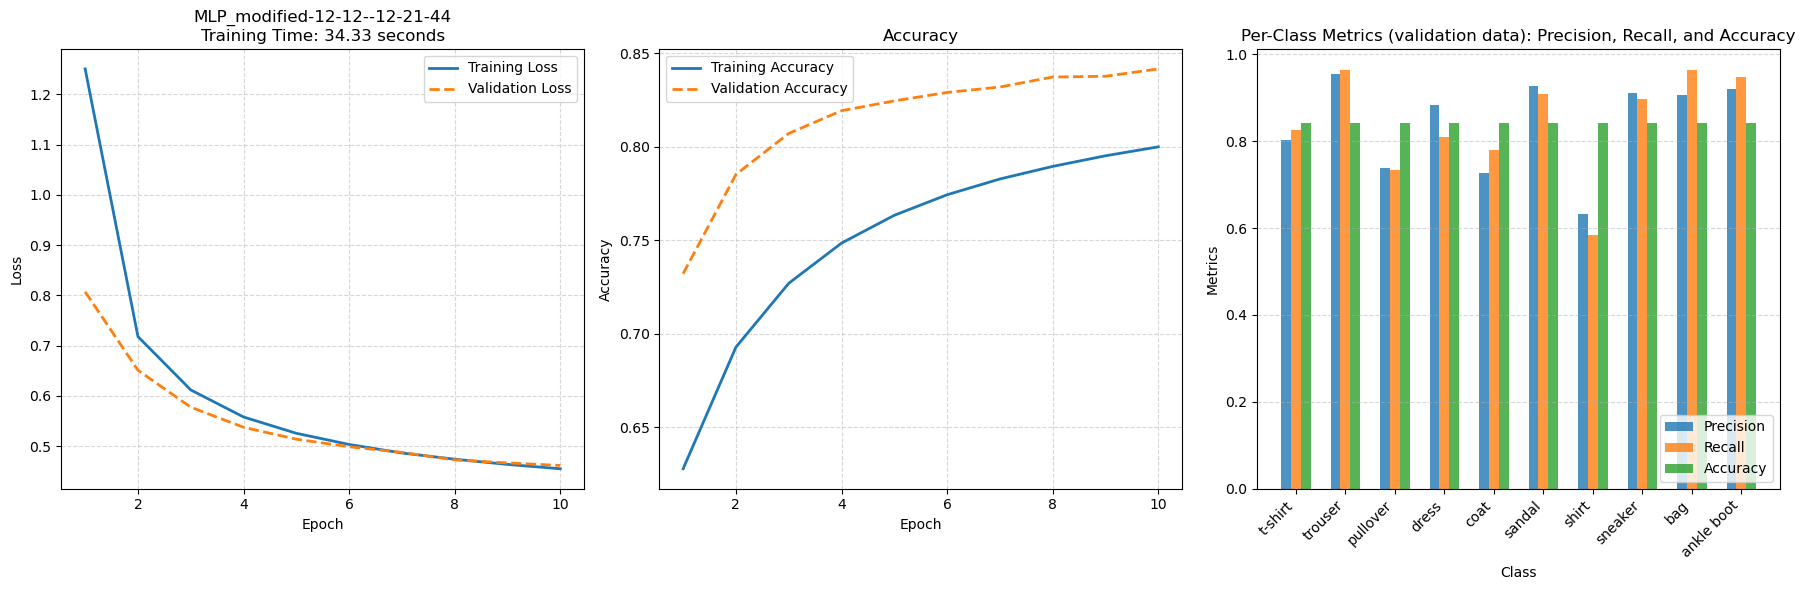

Model saved to: models\MLPBasic_task1_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/MLPBasic_task1_lr0p01_bs128.pkl
MLPBasic model saved at: models/MLPBasic_task1_lr0p01_bs128.pkl


100%|██████████| 79/79 [00:00<00:00, 145.10it/s]


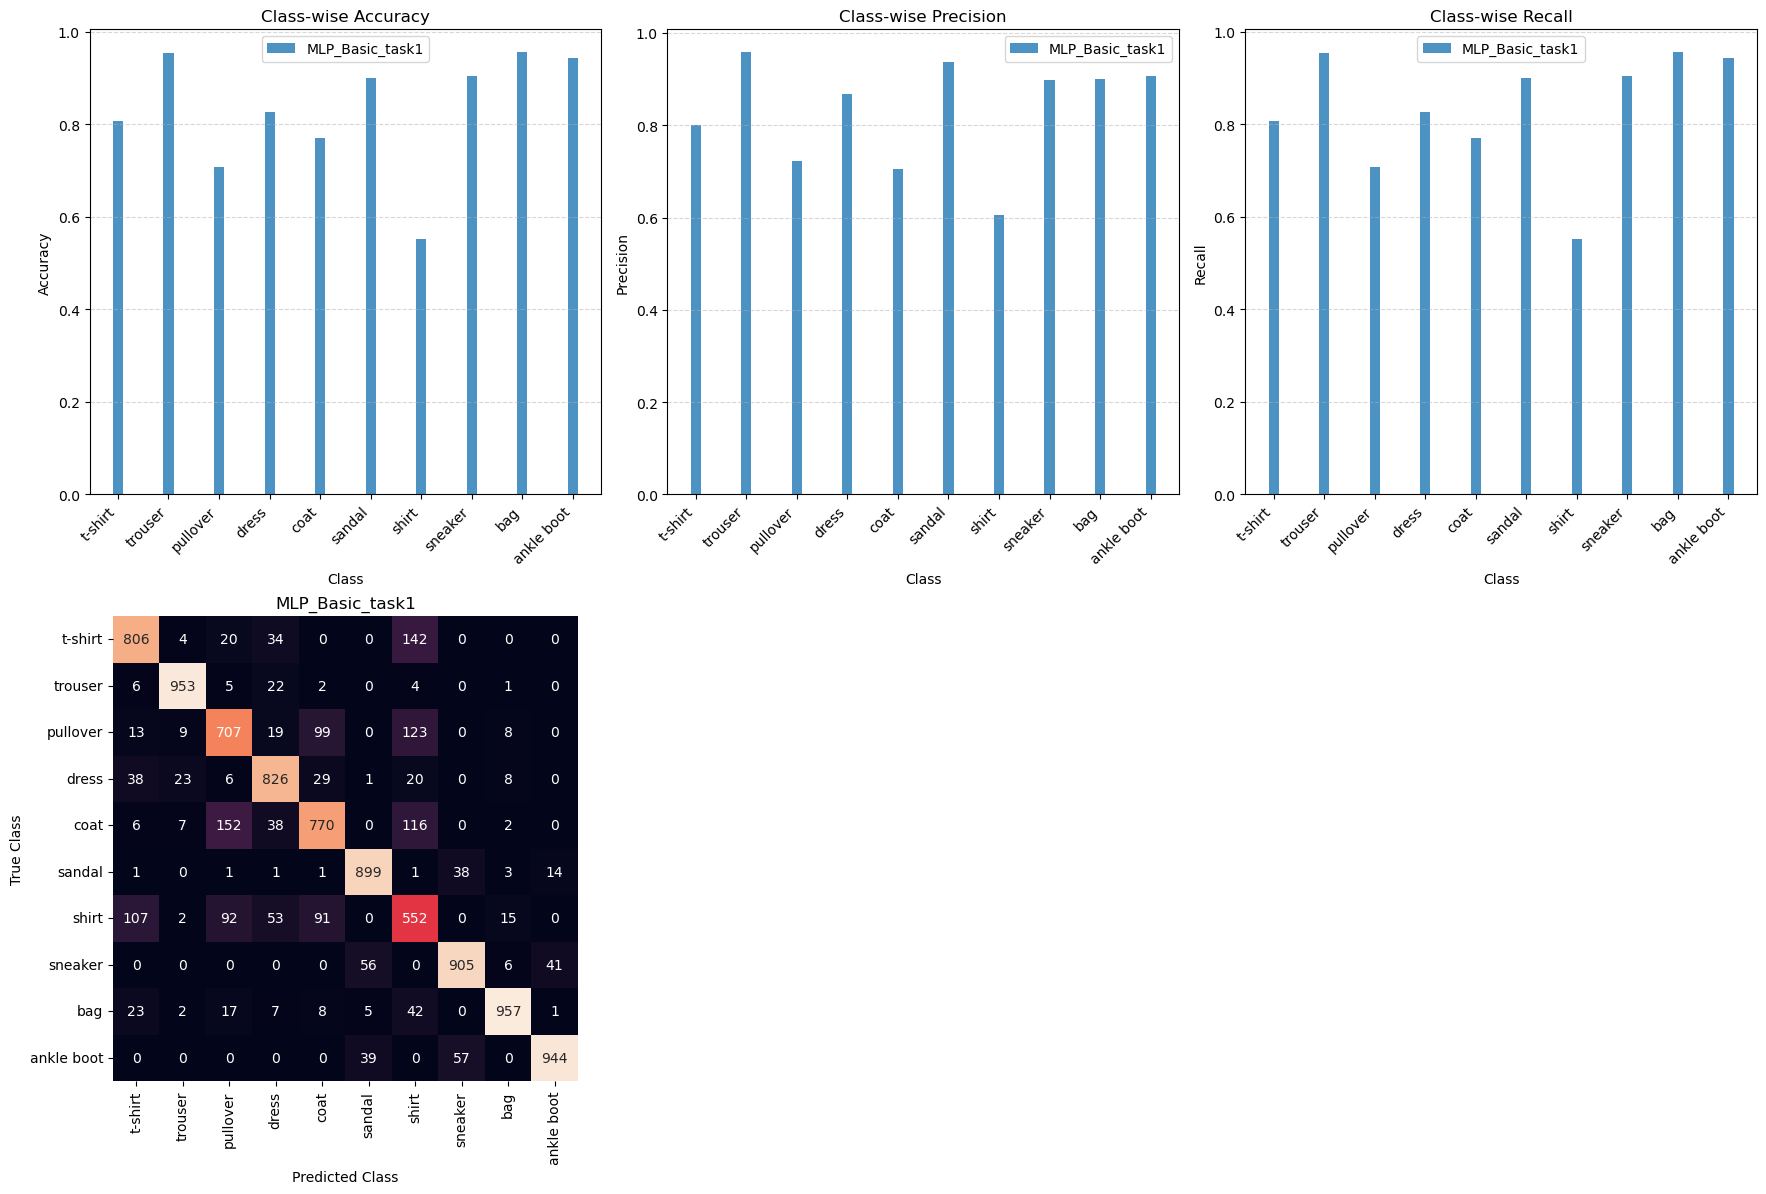

In [6]:
file_mlp_basic = train_pytorch_network_mlp(
    hidden_layers=[100],          # 1 hidden layer with 100 nodes
    output_size=10,               # 10 output classes, one for each in FASHION_MNIST_LABELS
    activation_fn='relu',         
    learning_rate=1e-2,           
    batch_size=128,               
    epochs=10,                   
    model_name="MLPBasic_task1"
)

print(f"MLPBasic model saved at: {file_mlp_basic}")

# Load models dynamically using the returned filenames
MLP_models = {
    'MLP_Basic_task1': PyTorchTrainer.load(file_mlp_basic)
}

# Visualize class-wise metrics
evaluate(MLP_models)


---
**Task 2 (easy): Evaluation💡**
1. Evaluate the performance of the model during training:    - Inspect the accuracy, loss and training time. What patterns or trends do you observe in the loss and accuracy graphs throughout training?




---

## Task 2 reflection

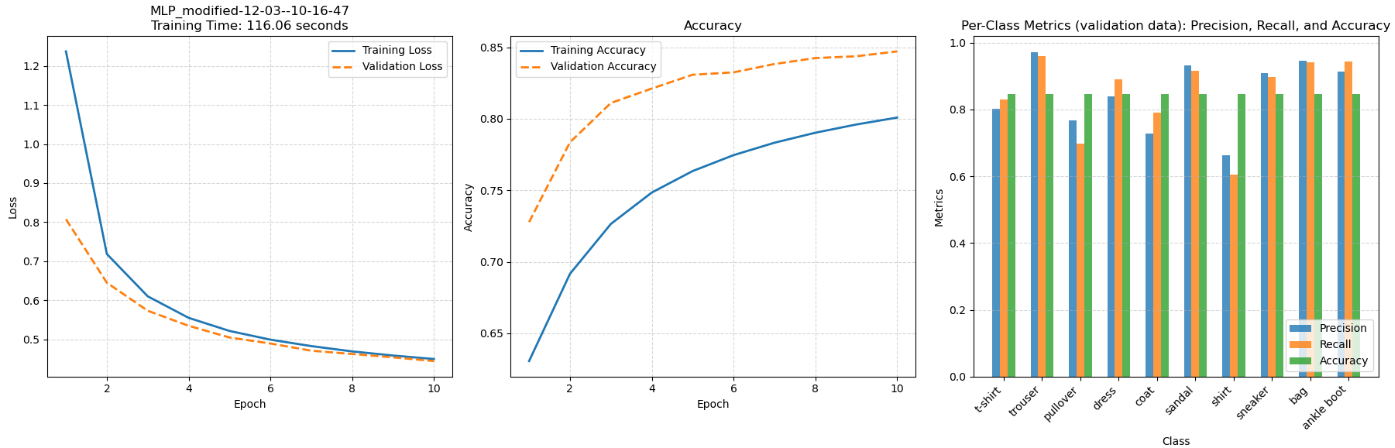

1. **Accuracy**:
   - Both **training accuracy** and **validation accuracy** increased steadily throughout training.
   - By the 10th epoch, the training accuracy reached approximately **80%**, and validation accuracy was around **85%**
   - On class-wise metrics: Some items performs better than others, which might be because they have more distinct features, such as very sharp defined edges being similair on most training and test samples, such as trousers. And other items perform worse such as t-shirt, which might be hard to differentiate from pullovers.

2. **Loss**:
   - The **training loss** decreased consistently, indicating that the model was learning to minimize the classification error on the training set.
   - The **validation loss** also decreases showing improvement in generalization.
   - As **Validation loss** continued to decrease, it is indicating that overfitting was not yet a significant issue after 10 epochs.

3.  **Training Time**:
       - 116.85 seconds for 10 epochs.
       - Each epoch had consistent progress rates
       - As loss is continuously decreasing, at a somewhat "high rate", it suggest we need more epochs to find our minima.


The next task experiments with different hyperparameters. Use the function`evaluate_overall_metrics`
 to visualize and compare the overall performance of the models and use the `evaluate`
 function to visualise and compare the performance of the models class-wise. [Figure 1](#ex) provides an example of the type of plots returned by the functions.
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: left; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="ex">

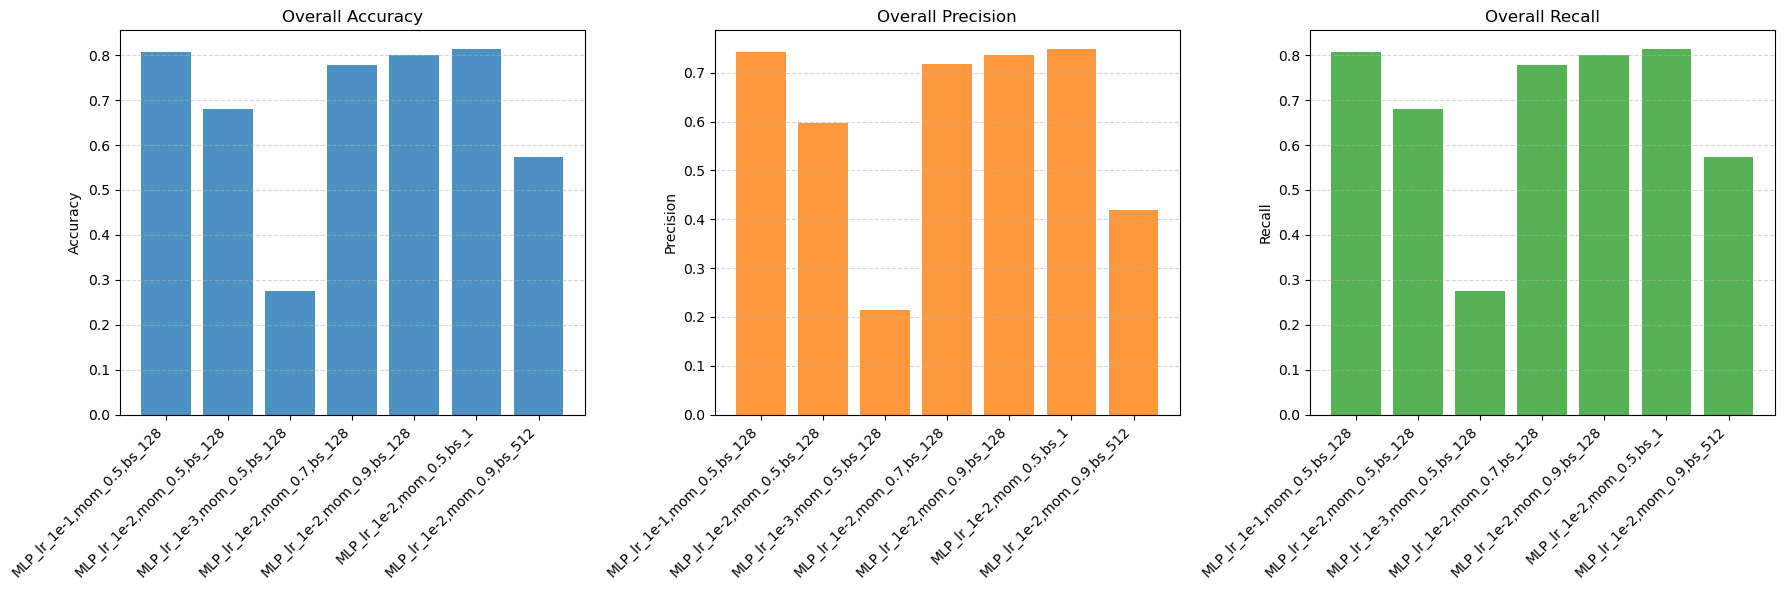

<figcaption class="figure-caption has-text-center">Figure 1: Example of output from the `evaluate_overall_metrics`
 function.
</figcaption>
</figure>
</div>


</div>

<div style="float: right; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="model">

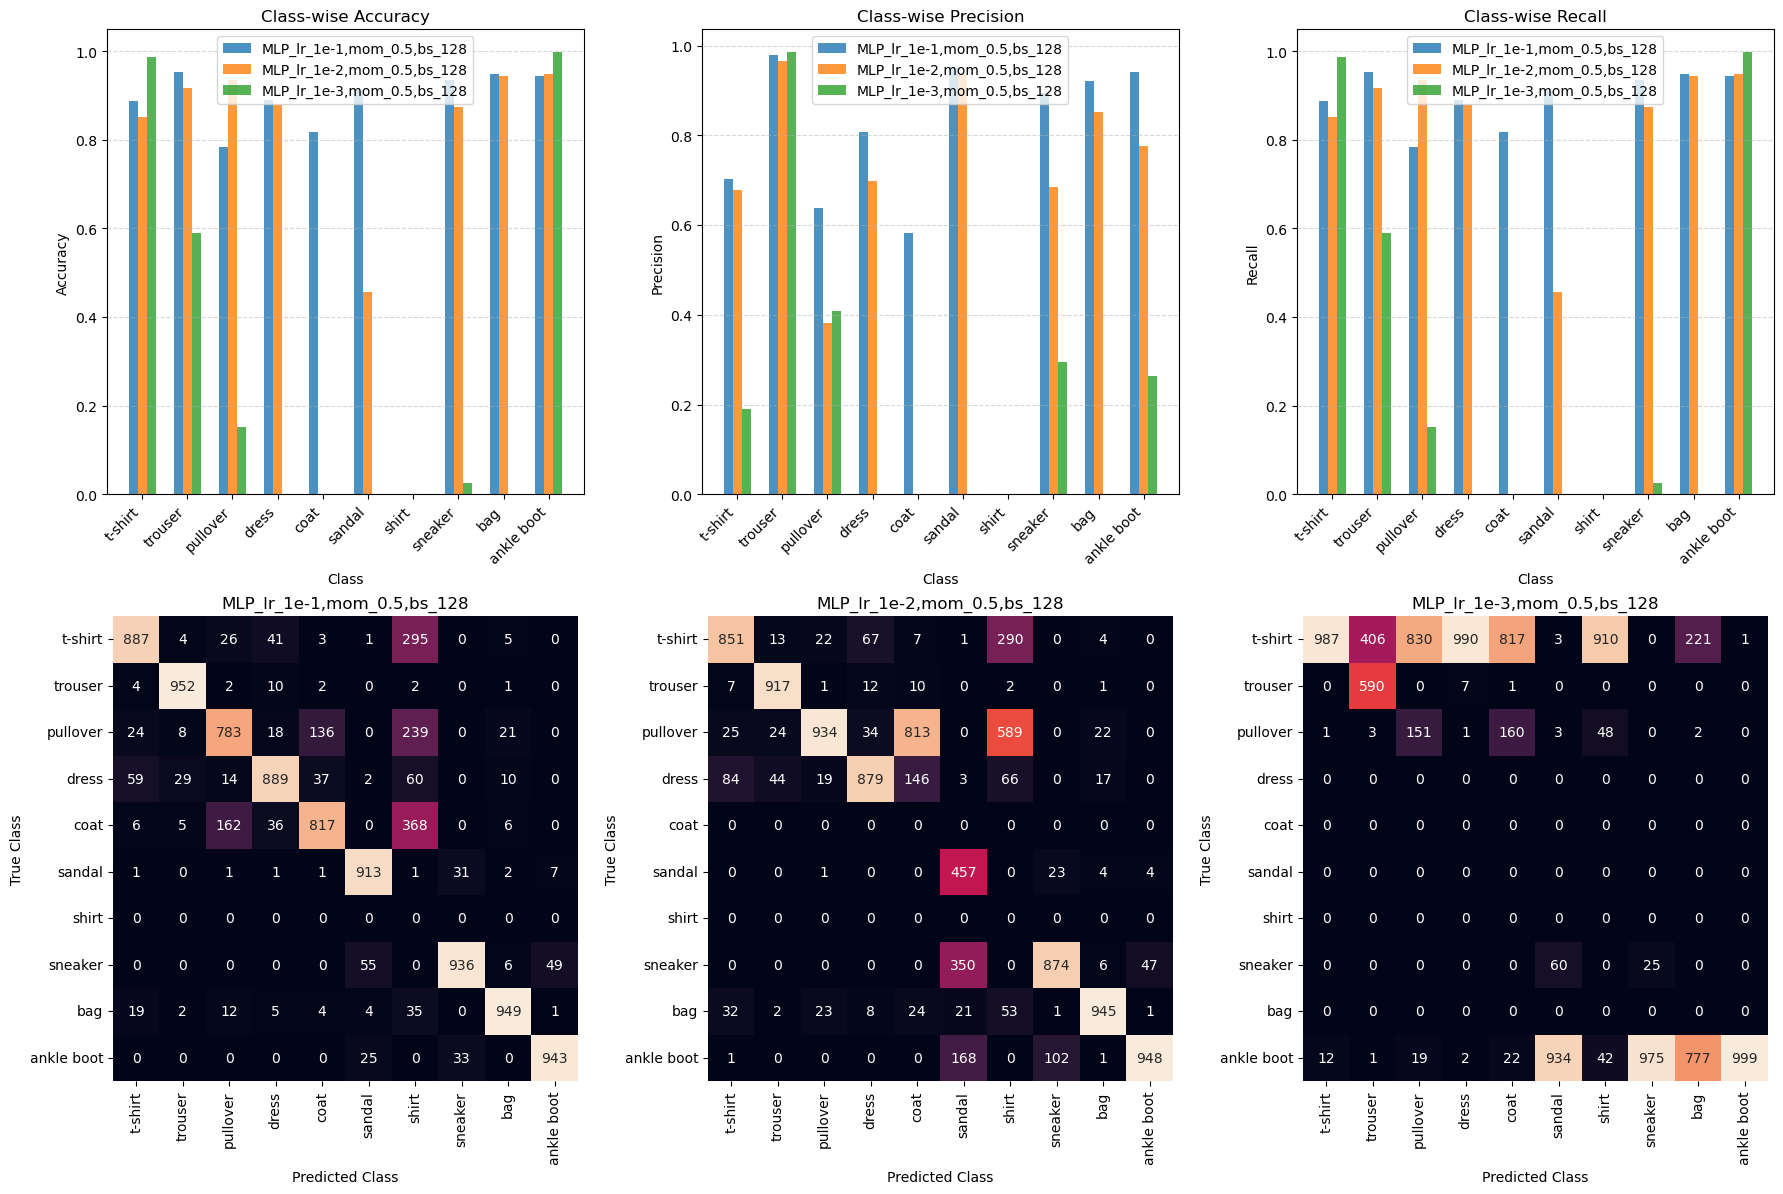

<figcaption class="figure-caption has-text-center">Figure 2: Example of output from the `evaluate`
 function.
</figcaption>
</figure>
</div>


</div>



</div>


---
**Task 3 (easy): Training basic MLP modifying hyperparameters👩‍💻**
1. Explore how different hyperparameters influence the training and performance of the model:
    - Modify training variables and train new models:        - Set the learning rate to 1e-3, and 1e-1. 
        - Reset the learning rate to 1e-2 then modify the batch size to 1 and 512. 


    - Fill the dictionaries below with the paths of the trained models.
    - Visualize the overall metrics of performance for all models trained using the `evaluate_overall_metrics`
 function.
    - Visualize the performance by running the `evaluate`
 function.


**Hint**
The cell below is a guide for how to load the models after training. The models are located in the `models`
 folder.




---

Training MLP_LR_1e-3...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 143.37it/s]


[Validation] Epoch 1: acc: 0.6166, val_loss: 1.9701, train_acc: 0.3897
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 134.67it/s]


[Validation] Epoch 2: acc: 0.6497, val_loss: 1.6077, train_acc: 0.5160
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 142.56it/s]


[Validation] Epoch 3: acc: 0.6544, val_loss: 1.3372, train_acc: 0.5629
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 132.77it/s]


[Validation] Epoch 4: acc: 0.6705, val_loss: 1.1657, train_acc: 0.5872
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 124.44it/s]


[Validation] Epoch 5: acc: 0.6753, val_loss: 1.0531, train_acc: 0.6038
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 140.48it/s]


[Validation] Epoch 6: acc: 0.6819, val_loss: 0.9742, train_acc: 0.6167
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 139.23it/s]


[Validation] Epoch 7: acc: 0.6940, val_loss: 0.9158, train_acc: 0.6273
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 143.76it/s]


[Validation] Epoch 8: acc: 0.7051, val_loss: 0.8712, train_acc: 0.6367
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 146.39it/s]


[Validation] Epoch 9: acc: 0.7133, val_loss: 0.8358, train_acc: 0.6451
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 145.12it/s]


[Validation] Epoch 10: acc: 0.7241, val_loss: 0.8066, train_acc: 0.6527


100%|██████████| 79/79 [00:00<00:00, 143.60it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62E1D3820>


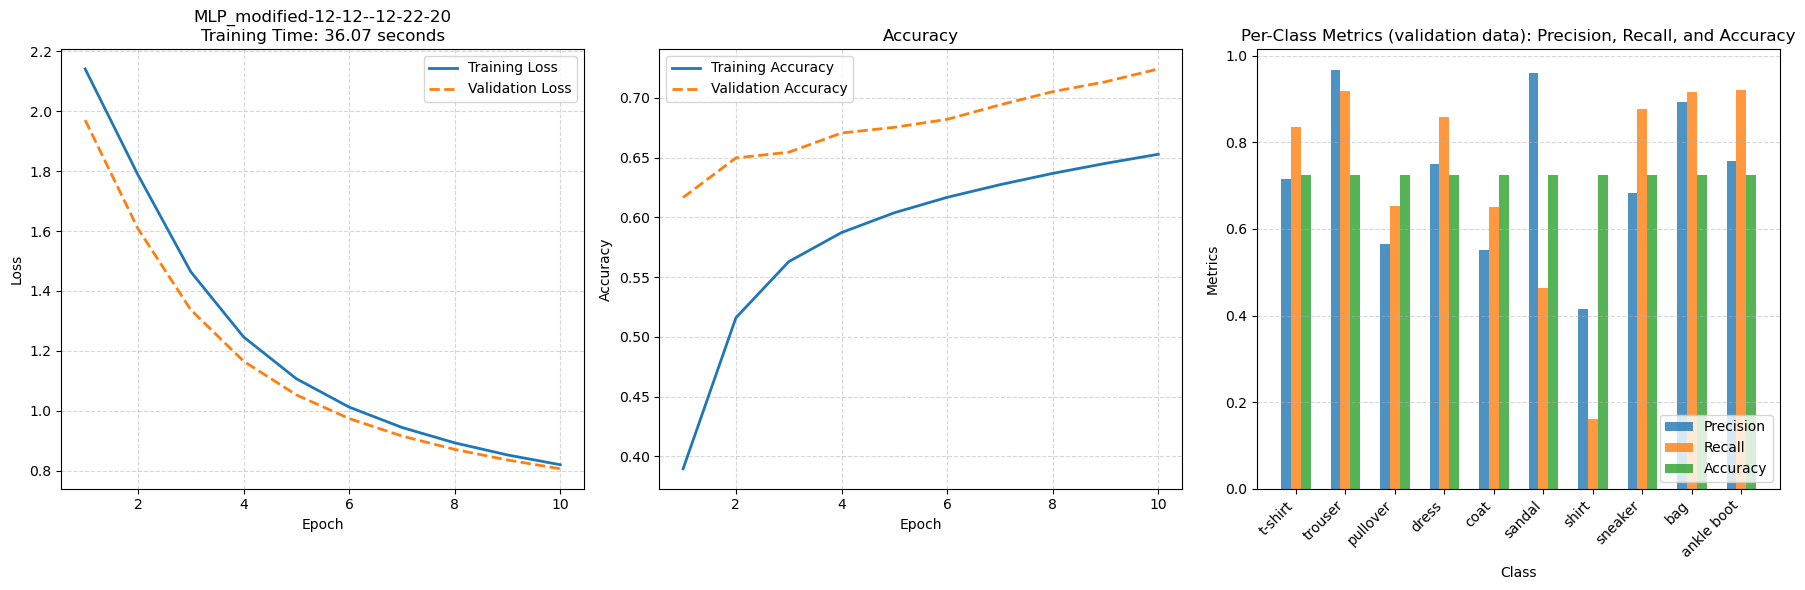

Model saved to: models\MLP_LR_1e-3_lr0p001_bs128.pkl
Training and evaluation completed. Model saved at: models/MLP_LR_1e-3_lr0p001_bs128.pkl
Training MLP_LR_1e-1...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 144.36it/s]


[Validation] Epoch 1: acc: 0.8287, val_loss: 0.4827, train_acc: 0.7701
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 105.92it/s]


[Validation] Epoch 2: acc: 0.8404, val_loss: 0.4441, train_acc: 0.8038
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 145.73it/s]


[Validation] Epoch 3: acc: 0.8459, val_loss: 0.4206, train_acc: 0.8201
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 138.85it/s]


[Validation] Epoch 4: acc: 0.8653, val_loss: 0.3762, train_acc: 0.8306
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 147.63it/s]


[Validation] Epoch 5: acc: 0.8664, val_loss: 0.3689, train_acc: 0.8382
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 147.80it/s]


[Validation] Epoch 6: acc: 0.8702, val_loss: 0.3571, train_acc: 0.8442
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 145.96it/s]


[Validation] Epoch 7: acc: 0.8622, val_loss: 0.3730, train_acc: 0.8488
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 136.28it/s]


[Validation] Epoch 8: acc: 0.8654, val_loss: 0.3641, train_acc: 0.8530
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 134.26it/s]


[Validation] Epoch 9: acc: 0.8720, val_loss: 0.3525, train_acc: 0.8565
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 133.88it/s]


[Validation] Epoch 10: acc: 0.8713, val_loss: 0.3577, train_acc: 0.8596


100%|██████████| 79/79 [00:00<00:00, 139.08it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62F3762C0>


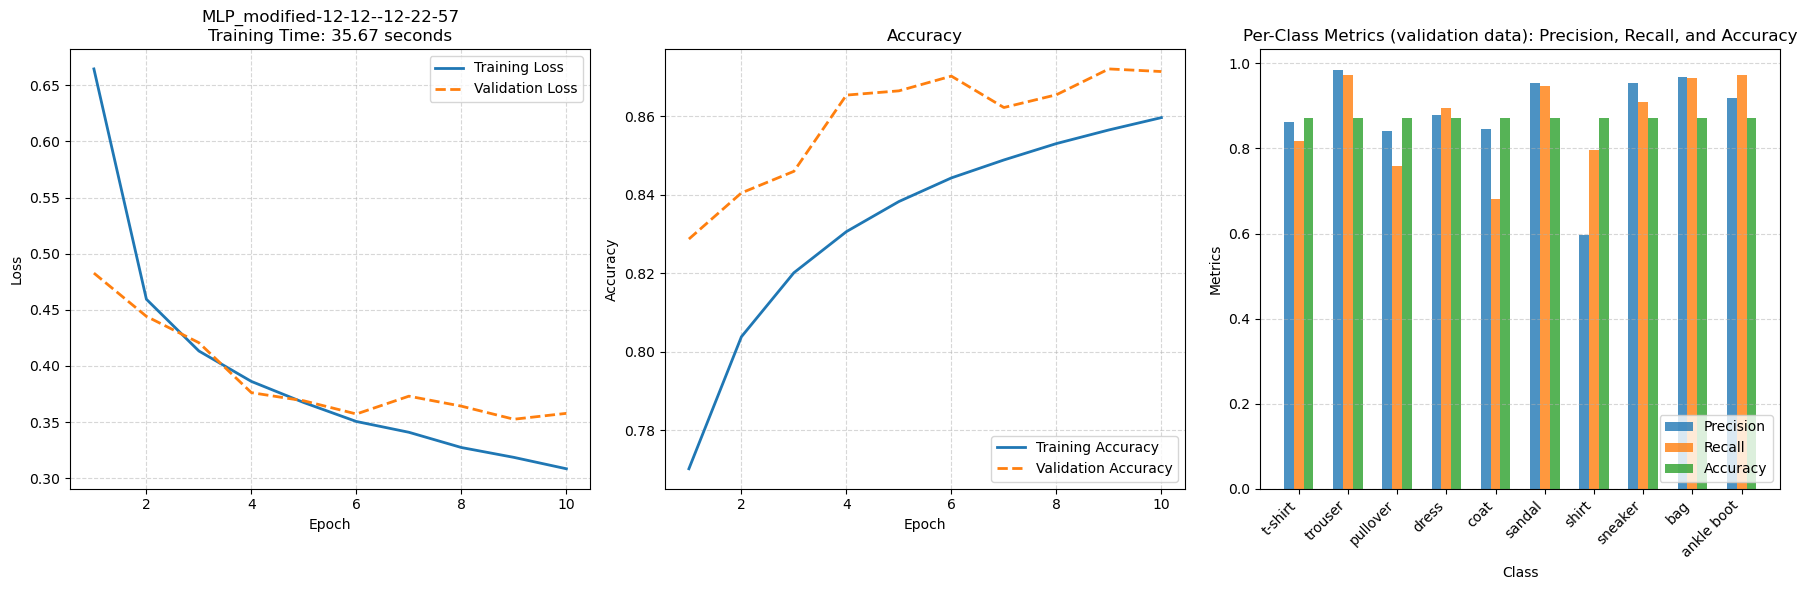

Model saved to: models\MLP_LR_1e-1_lr0p1_bs128.pkl
Training and evaluation completed. Model saved at: models/MLP_LR_1e-1_lr0p1_bs128.pkl
Training MLP_BS_1...
[Epoch 1]


100%|██████████| 12000/12000 [00:02<00:00, 5306.69it/s]


[Validation] Epoch 1: acc: 0.8412, val_loss: 0.4551, train_acc: 0.7897
[Epoch 2]


100%|██████████| 12000/12000 [00:02<00:00, 5359.92it/s]


[Validation] Epoch 2: acc: 0.8208, val_loss: 0.4753, train_acc: 0.8109
[Epoch 3]


100%|██████████| 12000/12000 [00:02<00:00, 5209.99it/s]


[Validation] Epoch 3: acc: 0.8363, val_loss: 0.4447, train_acc: 0.8224
[Epoch 4]


100%|██████████| 12000/12000 [00:02<00:00, 5371.31it/s]


[Validation] Epoch 4: acc: 0.8370, val_loss: 0.4900, train_acc: 0.8302
[Epoch 5]


100%|██████████| 12000/12000 [00:02<00:00, 5323.14it/s]


[Validation] Epoch 5: acc: 0.8668, val_loss: 0.3920, train_acc: 0.8358
[Epoch 6]


100%|██████████| 12000/12000 [00:02<00:00, 4208.09it/s]


[Validation] Epoch 6: acc: 0.8593, val_loss: 0.3997, train_acc: 0.8405
[Epoch 7]


100%|██████████| 12000/12000 [00:02<00:00, 5266.58it/s]


[Validation] Epoch 7: acc: 0.8424, val_loss: 0.4818, train_acc: 0.8444
[Epoch 8]


100%|██████████| 12000/12000 [00:02<00:00, 4494.08it/s]


[Validation] Epoch 8: acc: 0.8598, val_loss: 0.4426, train_acc: 0.8477
[Epoch 9]


100%|██████████| 12000/12000 [00:02<00:00, 4513.36it/s]


[Validation] Epoch 9: acc: 0.8560, val_loss: 0.4362, train_acc: 0.8508
[Epoch 10]


100%|██████████| 12000/12000 [00:02<00:00, 5157.76it/s]


[Validation] Epoch 10: acc: 0.8744, val_loss: 0.4048, train_acc: 0.8535


100%|██████████| 10000/10000 [00:01<00:00, 5568.52it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62E1A1270>


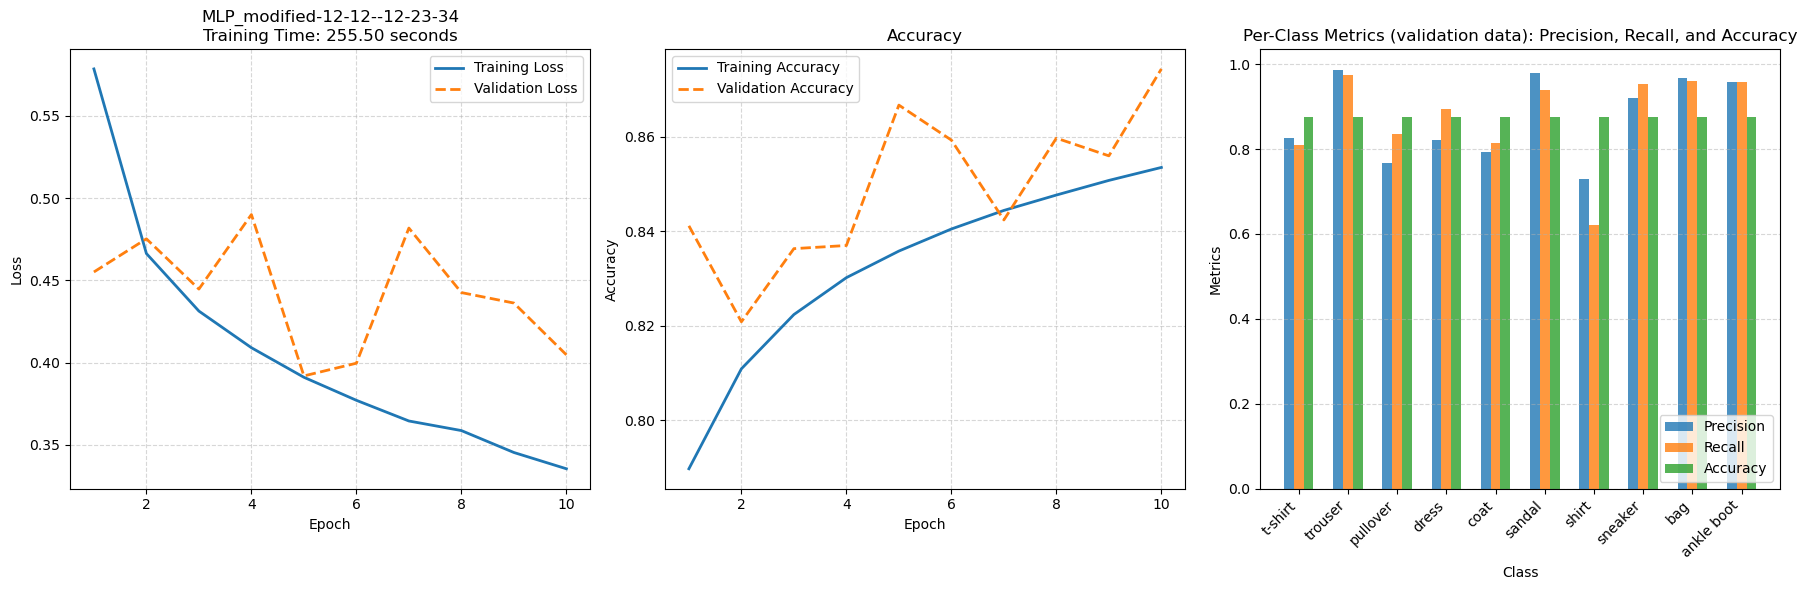

Model saved to: models\MLP_BS_1_lr0p01_bs1.pkl
Training and evaluation completed. Model saved at: models/MLP_BS_1_lr0p01_bs1.pkl
Training MLP_BS_512...
[Epoch 1]


100%|██████████| 24/24 [00:00<00:00, 35.65it/s]


[Validation] Epoch 1: acc: 0.6352, val_loss: 1.5284, train_acc: 0.4534
[Epoch 2]


100%|██████████| 24/24 [00:00<00:00, 36.80it/s]


[Validation] Epoch 2: acc: 0.6643, val_loss: 1.0791, train_acc: 0.5554
[Epoch 3]


100%|██████████| 24/24 [00:00<00:00, 35.92it/s]


[Validation] Epoch 3: acc: 0.6899, val_loss: 0.9028, train_acc: 0.5989
[Epoch 4]


100%|██████████| 24/24 [00:00<00:00, 33.99it/s]


[Validation] Epoch 4: acc: 0.7213, val_loss: 0.8126, train_acc: 0.6275
[Epoch 5]


100%|██████████| 24/24 [00:00<00:00, 35.39it/s]


[Validation] Epoch 5: acc: 0.7453, val_loss: 0.7558, train_acc: 0.6494
[Epoch 6]


100%|██████████| 24/24 [00:00<00:00, 29.12it/s]


[Validation] Epoch 6: acc: 0.7590, val_loss: 0.7148, train_acc: 0.6667
[Epoch 7]


100%|██████████| 24/24 [00:00<00:00, 35.65it/s]


[Validation] Epoch 7: acc: 0.7687, val_loss: 0.6825, train_acc: 0.6812
[Epoch 8]


100%|██████████| 24/24 [00:00<00:00, 33.81it/s]


[Validation] Epoch 8: acc: 0.7812, val_loss: 0.6568, train_acc: 0.6934
[Epoch 9]


100%|██████████| 24/24 [00:00<00:00, 35.18it/s]


[Validation] Epoch 9: acc: 0.7890, val_loss: 0.6349, train_acc: 0.7039
[Epoch 10]


100%|██████████| 24/24 [00:00<00:00, 35.40it/s]


[Validation] Epoch 10: acc: 0.7947, val_loss: 0.6154, train_acc: 0.7131


100%|██████████| 20/20 [00:00<00:00, 36.96it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62CEE3CA0>


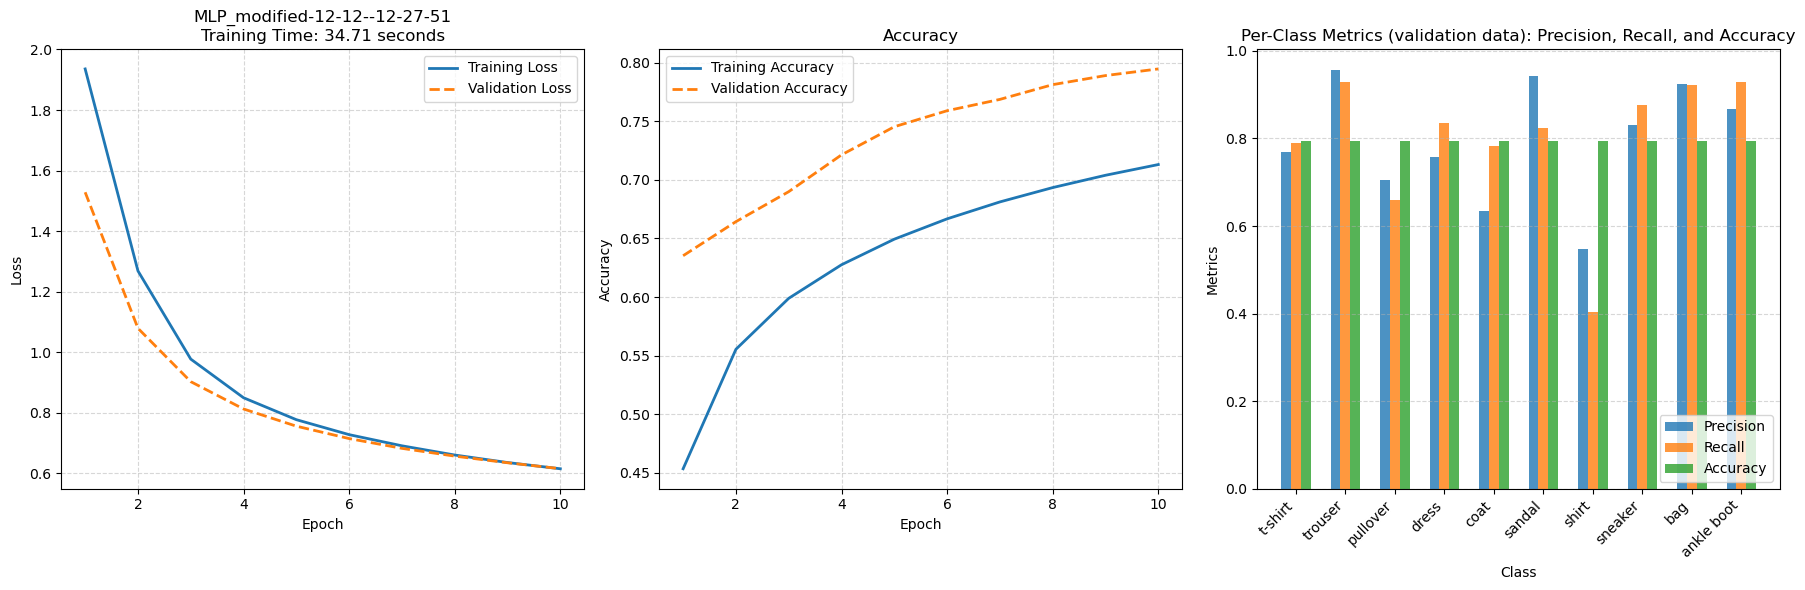

Model saved to: models\MLP_BS_512_lr0p01_bs512.pkl
Training and evaluation completed. Model saved at: models/MLP_BS_512_lr0p01_bs512.pkl


100%|██████████| 20/20 [00:00<00:00, 37.30it/s]


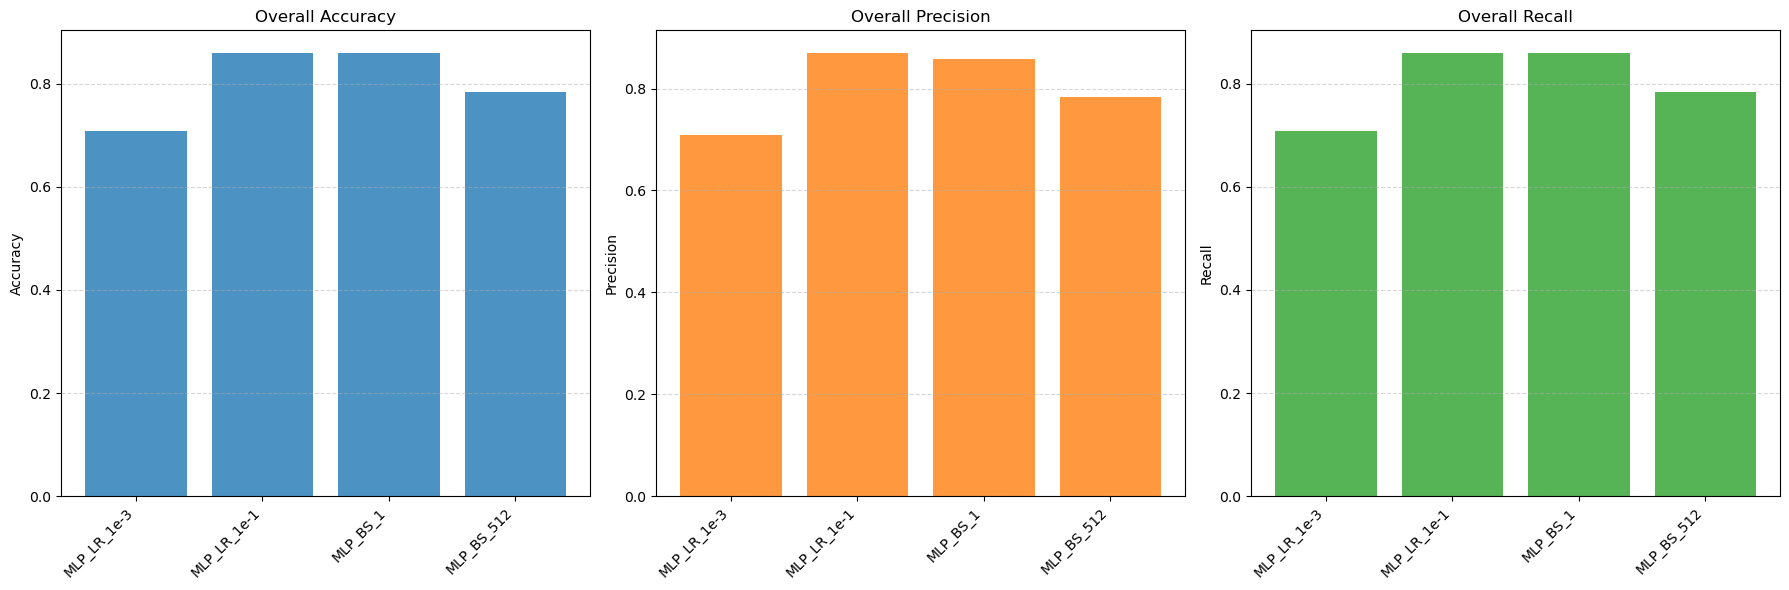

100%|██████████| 20/20 [00:00<00:00, 36.70it/s]


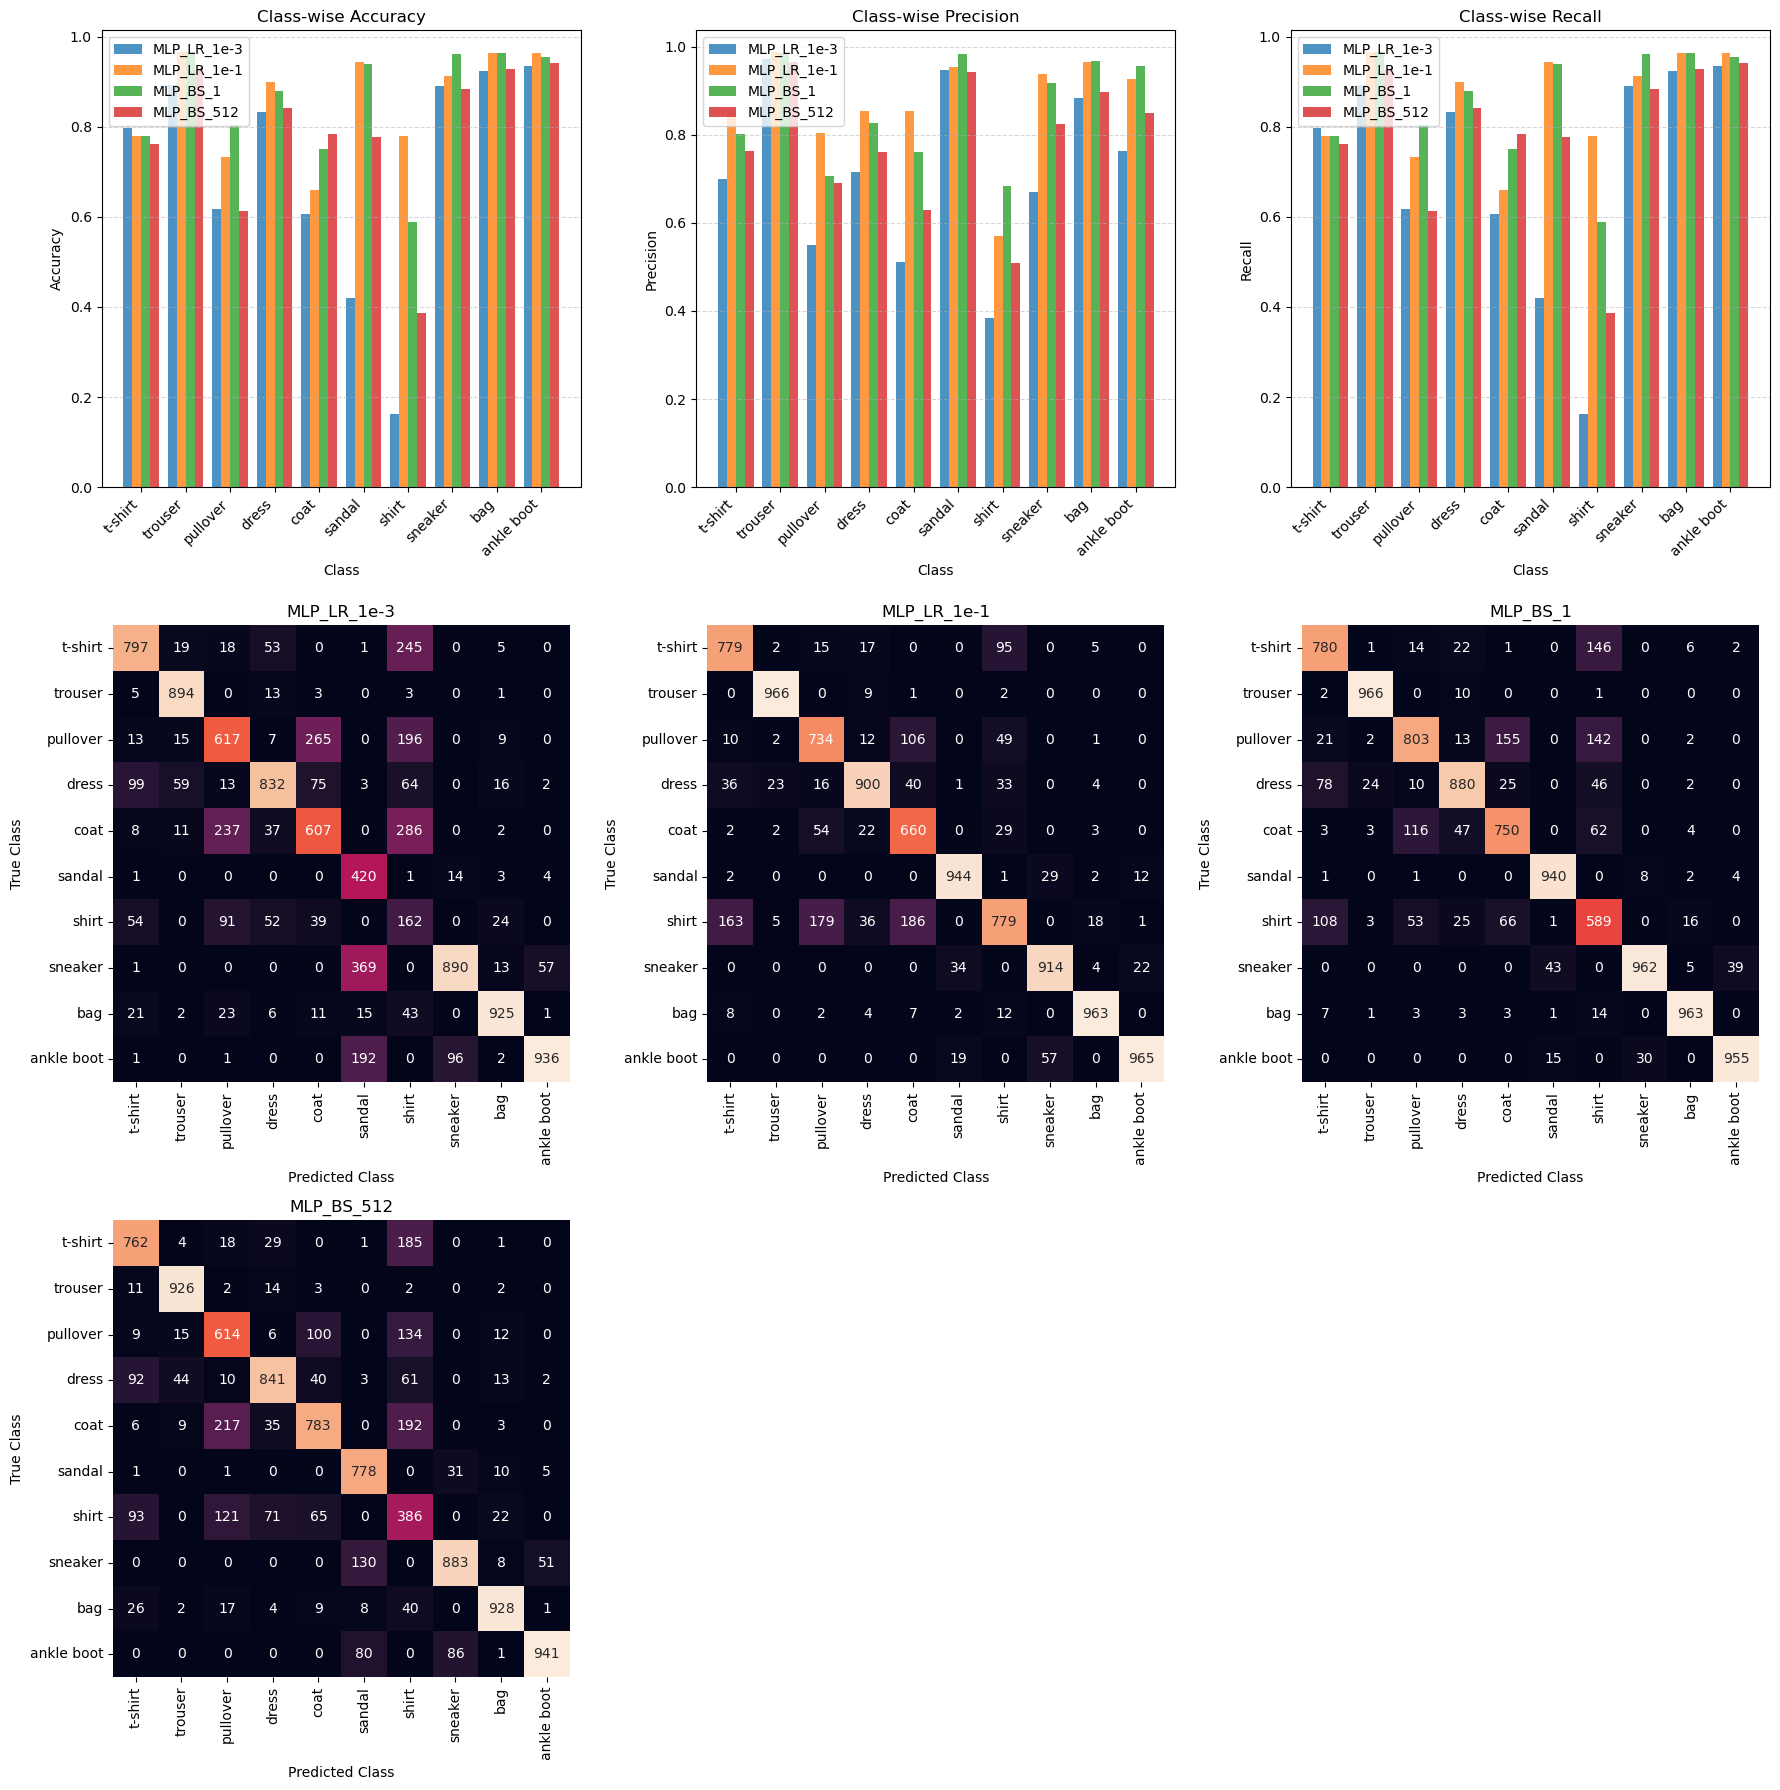

In [7]:
# Train MLP models with different hyperparameters
file_lr_1e3_bs_128 = train_pytorch_network_mlp(
    hidden_layers=[100], 
    activation_fn='relu', 
    learning_rate=1e-3, 
    batch_size=128, 
    epochs=10, 
    model_name="MLP_LR_1e-3"
)

file_lr_1e1_bs_128 = train_pytorch_network_mlp(
    hidden_layers=[100], 
    activation_fn='relu', 
    learning_rate=1e-1, 
    batch_size=128, 
    epochs=10, 
    model_name="MLP_LR_1e-1"
)

file_lr_1e2_bs_1 = train_pytorch_network_mlp(
    hidden_layers=[100], 
    activation_fn='relu', 
    learning_rate=1e-2, 
    batch_size=1, 
    epochs=10, 
    model_name="MLP_BS_1"
)

file_lr_1e2_bs_512 = train_pytorch_network_mlp(
    hidden_layers=[100], 
    activation_fn='relu', 
    learning_rate=1e-2, 
    batch_size=512, 
    epochs=10, 
    model_name="MLP_BS_512"
)

# Load models dynamically using the returned filenames
MLP_models = {
    'MLP_LR_1e-3': PyTorchTrainer.load(file_lr_1e3_bs_128),
    'MLP_LR_1e-1': PyTorchTrainer.load(file_lr_1e1_bs_128),
    'MLP_BS_1': PyTorchTrainer.load(file_lr_1e2_bs_1),
    'MLP_BS_512': PyTorchTrainer.load(file_lr_1e2_bs_512),
}

# Visualize overall metrics
evaluate_overall_metrics(MLP_models)

# Visualize class-wise metrics
evaluate(MLP_models)



---
**Task 4 (easy): Comparison💡**
1. Compare the performance of the models:    - Evaluate the models using accuracy, precision, recall, and heatmaps.
    - Discuss how the changes in hyperparameters, such as learning rate and batch size, influence these performance metrics. Highlight any trends or trade-offs observed, such as improvements in accuracy versus potential declines in precision or recall.


2. How is the training time affected by the different hyperparameters?


---

## Task 4 reflection.

**Batch size**
* **Low:** Example of BS=1: results in very high training time. With 1024 data points, model updates using 1 point each iteration. But it is very subject to noisy data, as if there is 1 outlier, it will be used to calculate step sizes for 1 update iteration.
* **High** Example of BS=512: results in very low training time. With 1024 data points, model updates using 512 point each iteration.
* **Result** Trade-off between accuracy of model and training time. We got highest acc with BS=1 and highest training time, and we got lower acc with higher batch size but lower training time.

**Learning rate:**
* **Low:** It might need an extreme amount of epochs to find a minima. Thus with our 10 epochs, a very low learning rate never ends up finding a minima, and thus gave us a low accuracy.
* **High:** It might overshoot its estimates and end up wasting time oscillating. But a learning rate of 0.1 is not really "high", something like 0.7 would be high.

### Convolutional Neural Network
The following tasks investigate a CNN architecture for the same problem.

---
**Task 5 (easy): CNN architecture💡**
1. Locate the `CNNBasic`
 model defined in `networks.py`
 and explain the architecture.


---

## Task 5 Reflection: `CNNBasic` Architecture

**Activation function** RELU

### 1. Convolutional Layer 1
- **Input**: A grayscale image with 1 channel of `28 * 28` pixels.
- **Operation**: Applies **8 convolutional kernels (filters)**, each of size `9 * 9`.
- **Output Size Calculation**:
  `(28 - 9 + 1) * (28 - 9 + 1) = 20 * 20`
- **Output**: `8` feature maps, each of size `20 * 20`.

---

### 2. Max Pooling 1
- **Operation**: Downsamples the feature maps using a pooling window of `2 * 2` with a stride of `2`. This reduces spatial dimensions while keeping the depth (number of feature maps) the same.
- **Output Size Calculation**:
  `20 / 2 = 10 * 10`
- **Output**: `8` feature maps, each of size `10 * 10`.

---

### 3. Convolutional Layer 2
- **Input**: `8` feature maps, each of size `10 * 10` from the previous layer.
- **Operation**: Applies **16 convolutional kernels**, each of size `3 * 3`.
- **Output Size Calculation**:
  `(10 - 3 + 1) * (10 - 3 + 1) = 8 * 8`
- **Output**: `16` feature maps, each of size `8 * 8`.

---

### 4. Max Pooling 2
- **Operation**: Downsamples the feature maps using a pooling window of `2 * 2` with a stride of `2`.
- **Output Size Calculation**:
  `8 / 2 = 4 * 4`
- **Output**: `16` feature maps, each of size `4 * 4`.

---

### 5. Flattening
- **Operation**: The `16` feature maps of size `4 * 4` are flattened into a single vector.
- **Size Calculation**:
  `4 * 4 * 16 = 256`
- **Output**: A `256`-dimensional vector.

---

### 6. Fully Connected (Linear) Layer 1
- **Input**: The `256`-dimensional vector from the flattening layer.
- **Operation**: Applies a fully connected layer with `60` neurons.
- **Output**: A `60`-dimensional vector.

---

### 7. Fully Connected (Linear) Layer 2
- **Input**: The `60`-dimensional vector from the first fully connected layer.
- **Operation**: Applies a fully connected layer with `10` neurons (one for each class in FashionMNIST).
- **Output**: A `10`-dimensional vector.



---
**Task 6 (easy): Training a basic CNN👩‍💻**
1. Run the cell below to train the `CNNBasic`
 model.


---

Training CNNBasic...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 101.62it/s]


[Validation] Epoch 1: acc: 0.6805, val_loss: 0.8648, train_acc: 0.4562
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 98.60it/s] 


[Validation] Epoch 2: acc: 0.7237, val_loss: 0.7403, train_acc: 0.5755
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 101.04it/s]


[Validation] Epoch 3: acc: 0.7635, val_loss: 0.6297, train_acc: 0.6292
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 98.73it/s] 


[Validation] Epoch 4: acc: 0.7794, val_loss: 0.5968, train_acc: 0.6619
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 101.21it/s]


[Validation] Epoch 5: acc: 0.7973, val_loss: 0.5531, train_acc: 0.6851
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 101.83it/s]


[Validation] Epoch 6: acc: 0.7993, val_loss: 0.5275, train_acc: 0.7032
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 98.12it/s] 


[Validation] Epoch 7: acc: 0.8230, val_loss: 0.4806, train_acc: 0.7184
[Epoch 8]


100%|██████████| 94/94 [00:01<00:00, 92.92it/s]


[Validation] Epoch 8: acc: 0.8247, val_loss: 0.4700, train_acc: 0.7312
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 96.90it/s]


[Validation] Epoch 9: acc: 0.8403, val_loss: 0.4417, train_acc: 0.7423
[Epoch 10]


100%|██████████| 94/94 [00:01<00:00, 90.72it/s]


[Validation] Epoch 10: acc: 0.8424, val_loss: 0.4374, train_acc: 0.7520


100%|██████████| 79/79 [00:00<00:00, 96.30it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62F48B3A0>


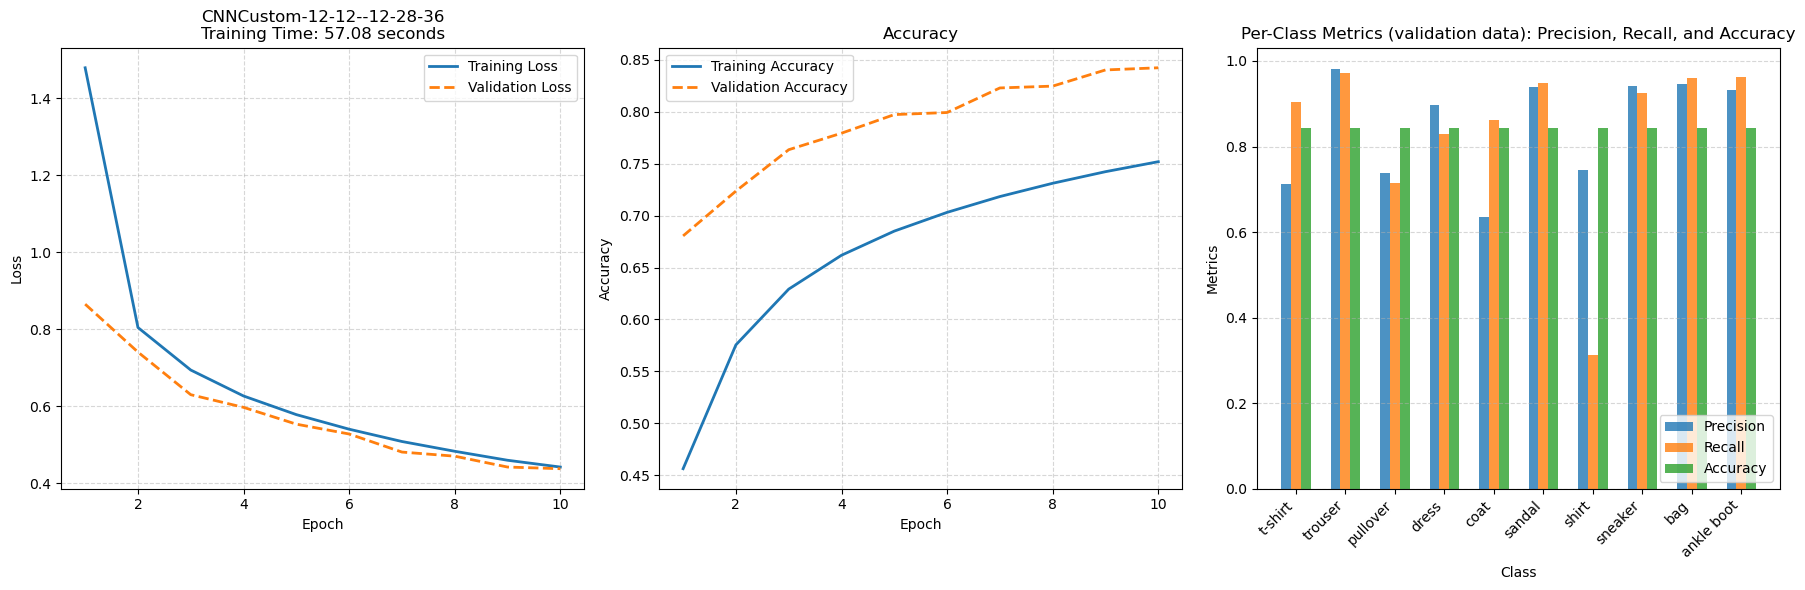

Model saved to: models\CNNBasic_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNNBasic_lr0p01_bs128.pkl
CNNBasic model saved at: models/CNNBasic_lr0p01_bs128.pkl


In [8]:
file_cnn_basic = train_pytorch_network_cnn(
    conv_layers=[(16, 5), (32, 3)], # 1 layer: 16 kernels of 5x5, 2 layer: 32 kernels of 3x3
    fully_connected_hidden_layers=[128, 10],          # Fully connected layers: 1 hidden layer with 128 nodes and 1 output layer with 10 nodes
    activation_fn='relu',         
    learning_rate=1e-2,           
    batch_size=128,               
    epochs=10,                    
    model_name="CNNBasic"         
)

print(f"CNNBasic model saved at: {file_cnn_basic}")


---
**Task 7 (easy): Evaluation👩‍💻💡**
1. Analyze the training figures and describe the key characteristics of the model’s training process.


---

## Task 7 reflection

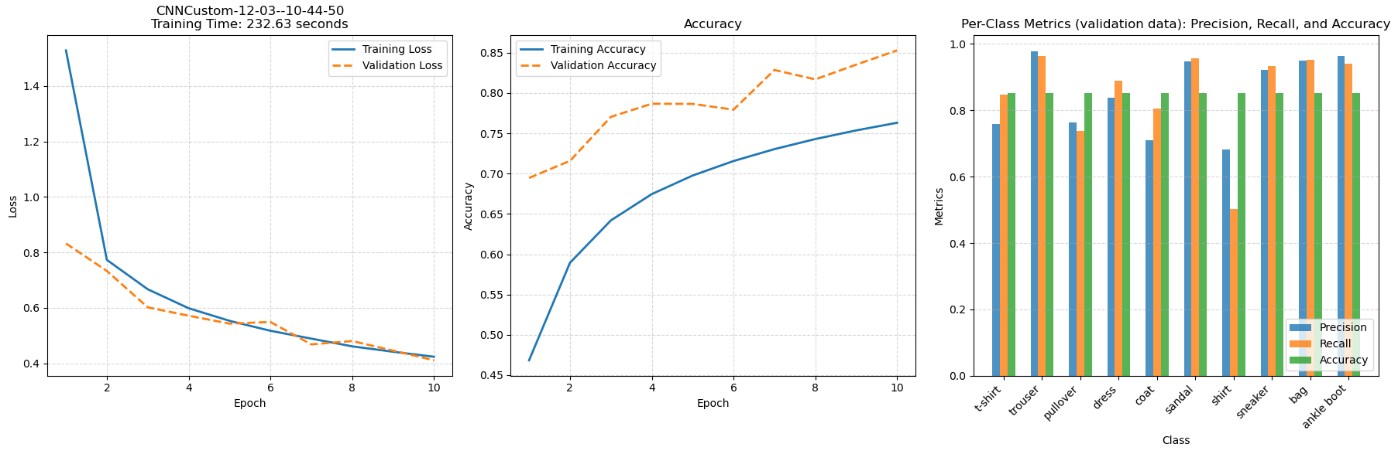

Almost same performance as Task 2, with MLP.
This might be due to the low amount of epochs, where neither model reaches a very optimized place.


---
**Task 8 (easy): Training a basic CNN modifying hyperparameters👩‍💻💡**
1. Experiment with the different hyperparameters affecting the training and performance of the model.    - Modify the following hyperparameters and train new model:        - Set the learning rate to 1e-4, and 1e-5. 
        - Modify the batch size to 256 and 1024. 


    - Fill the dictionary below with the paths of the trained models.
    - Visualize the overall performance by running `evaluate_overall_metrics`
 function.
    - Visualize the class-wise performance by running the `evaluate`
 function.




---

Training CNN_LR_1e-4_BS128...
[Epoch 1]


100%|██████████| 94/94 [00:01<00:00, 93.84it/s]


[Validation] Epoch 1: acc: 0.1010, val_loss: 2.2973, train_acc: 0.0999
[Epoch 2]


100%|██████████| 94/94 [00:01<00:00, 92.73it/s]


[Validation] Epoch 2: acc: 0.1009, val_loss: 2.2949, train_acc: 0.0999
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 101.39it/s]


[Validation] Epoch 3: acc: 0.1009, val_loss: 2.2927, train_acc: 0.0999
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 97.55it/s] 


[Validation] Epoch 4: acc: 0.1013, val_loss: 2.2906, train_acc: 0.0999
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 102.15it/s]


[Validation] Epoch 5: acc: 0.1034, val_loss: 2.2884, train_acc: 0.1001
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 100.82it/s]


[Validation] Epoch 6: acc: 0.1091, val_loss: 2.2863, train_acc: 0.1008
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 101.04it/s]


[Validation] Epoch 7: acc: 0.1237, val_loss: 2.2842, train_acc: 0.1024
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 99.58it/s] 


[Validation] Epoch 8: acc: 0.1507, val_loss: 2.2820, train_acc: 0.1061
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 98.66it/s]


[Validation] Epoch 9: acc: 0.1873, val_loss: 2.2796, train_acc: 0.1124
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 103.62it/s]


[Validation] Epoch 10: acc: 0.2280, val_loss: 2.2772, train_acc: 0.1213


100%|██████████| 79/79 [00:00<00:00, 101.33it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62F578B50>


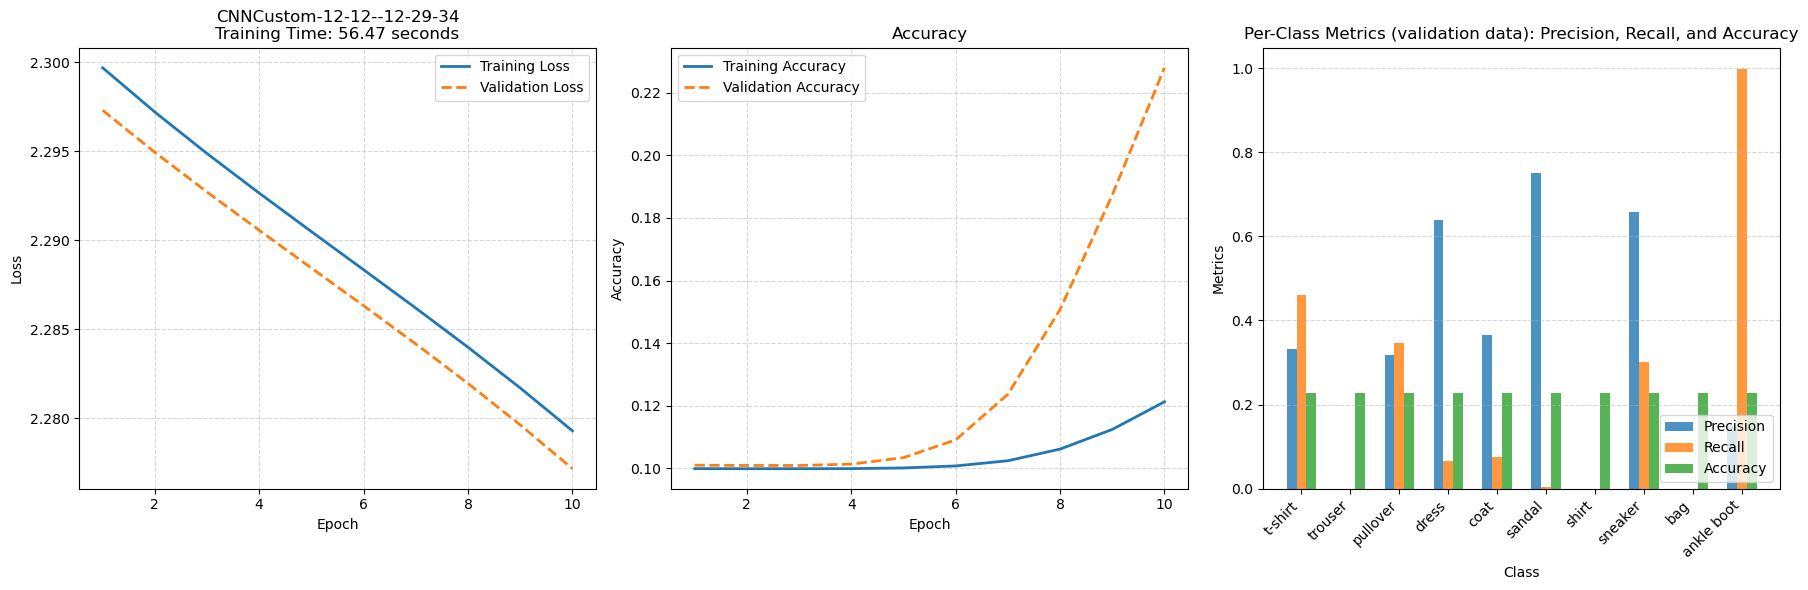

Model saved to: models\CNN_LR_1e-4_BS128_lr0p0001_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_LR_1e-4_BS128_lr0p0001_bs128.pkl
Training CNN_LR_1e-5_BS128...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 96.74it/s]


[Validation] Epoch 1: acc: 0.1022, val_loss: 2.3031, train_acc: 0.0979
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 102.14it/s]


[Validation] Epoch 2: acc: 0.1045, val_loss: 2.3027, train_acc: 0.0988
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 97.86it/s] 


[Validation] Epoch 3: acc: 0.1062, val_loss: 2.3023, train_acc: 0.0997
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 99.96it/s] 


[Validation] Epoch 4: acc: 0.1085, val_loss: 2.3019, train_acc: 0.1009
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 100.52it/s]


[Validation] Epoch 5: acc: 0.1110, val_loss: 2.3015, train_acc: 0.1022
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 98.42it/s]


[Validation] Epoch 6: acc: 0.1153, val_loss: 2.3011, train_acc: 0.1035
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 97.39it/s] 


[Validation] Epoch 7: acc: 0.1182, val_loss: 2.3007, train_acc: 0.1049
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 101.60it/s]


[Validation] Epoch 8: acc: 0.1212, val_loss: 2.3003, train_acc: 0.1063
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 100.70it/s]


[Validation] Epoch 9: acc: 0.1243, val_loss: 2.2999, train_acc: 0.1077
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 99.49it/s] 


[Validation] Epoch 10: acc: 0.1275, val_loss: 2.2996, train_acc: 0.1091


100%|██████████| 79/79 [00:00<00:00, 99.69it/s] 


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62E3EBBB0>


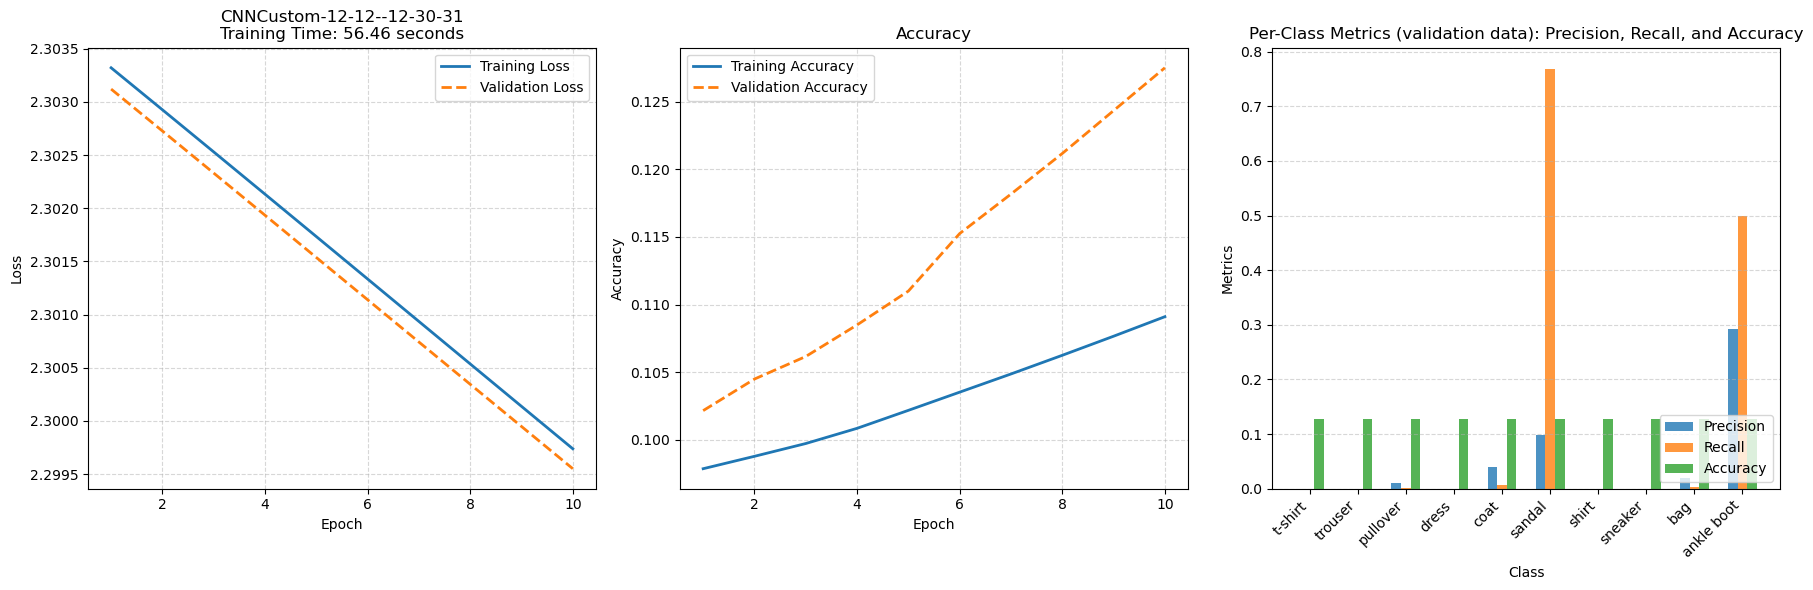

Model saved to: models\CNN_LR_1e-5_BS128_lr1e-05_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_LR_1e-5_BS128_lr1e-05_bs128.pkl
Training CNN_LR_1e-4_BS256...
[Epoch 1]


100%|██████████| 47/47 [00:00<00:00, 48.95it/s]


[Validation] Epoch 1: acc: 0.1009, val_loss: 2.3024, train_acc: 0.0998
[Epoch 2]


100%|██████████| 47/47 [00:00<00:00, 52.15it/s]


[Validation] Epoch 2: acc: 0.1011, val_loss: 2.3016, train_acc: 0.0999
[Epoch 3]


100%|██████████| 47/47 [00:00<00:00, 49.91it/s]


[Validation] Epoch 3: acc: 0.1027, val_loss: 2.3009, train_acc: 0.1003
[Epoch 4]


100%|██████████| 47/47 [00:00<00:00, 50.41it/s]


[Validation] Epoch 4: acc: 0.1042, val_loss: 2.3002, train_acc: 0.1008
[Epoch 5]


100%|██████████| 47/47 [00:00<00:00, 50.11it/s]


[Validation] Epoch 5: acc: 0.1056, val_loss: 2.2994, train_acc: 0.1015
[Epoch 6]


100%|██████████| 47/47 [00:00<00:00, 50.30it/s]


[Validation] Epoch 6: acc: 0.1070, val_loss: 2.2987, train_acc: 0.1022
[Epoch 7]


100%|██████████| 47/47 [00:01<00:00, 42.52it/s]


[Validation] Epoch 7: acc: 0.1099, val_loss: 2.2979, train_acc: 0.1032
[Epoch 8]


100%|██████████| 47/47 [00:00<00:00, 49.46it/s]


[Validation] Epoch 8: acc: 0.1133, val_loss: 2.2971, train_acc: 0.1042
[Epoch 9]


100%|██████████| 47/47 [00:00<00:00, 49.58it/s]


[Validation] Epoch 9: acc: 0.1171, val_loss: 2.2963, train_acc: 0.1055
[Epoch 10]


100%|██████████| 47/47 [00:00<00:00, 48.04it/s]


[Validation] Epoch 10: acc: 0.1207, val_loss: 2.2955, train_acc: 0.1070


100%|██████████| 40/40 [00:00<00:00, 51.40it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F633C13070>


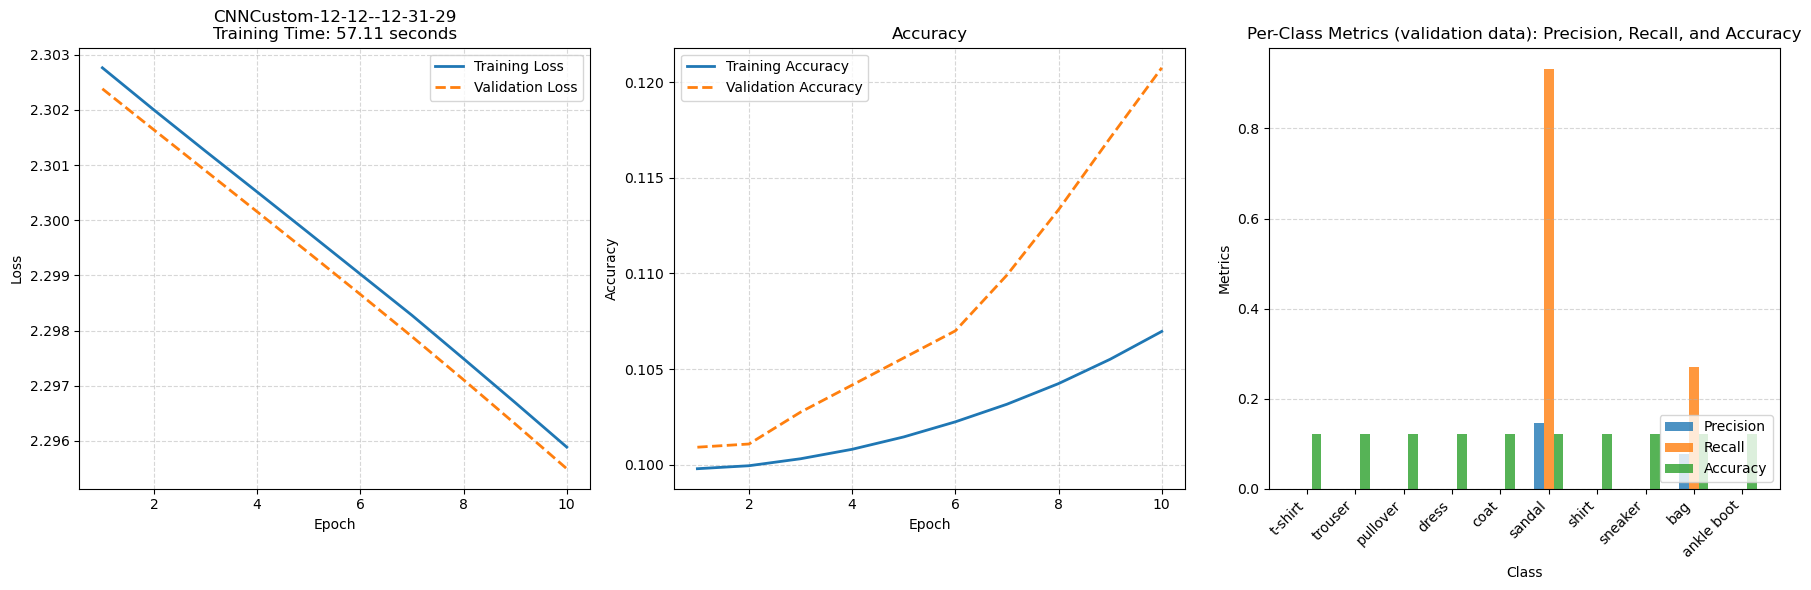

Model saved to: models\CNN_LR_1e-4_BS256_lr0p0001_bs256.pkl
Training and evaluation completed. Model saved at: models/CNN_LR_1e-4_BS256_lr0p0001_bs256.pkl
Training CNN_LR_1e-4_BS1024...
[Epoch 1]


100%|██████████| 12/12 [00:00<00:00, 12.34it/s]


[Validation] Epoch 1: acc: 0.1241, val_loss: 2.3031, train_acc: 0.1191
[Epoch 2]


100%|██████████| 12/12 [00:00<00:00, 12.68it/s]


[Validation] Epoch 2: acc: 0.1282, val_loss: 2.3028, train_acc: 0.1212
[Epoch 3]


100%|██████████| 12/12 [00:00<00:00, 12.42it/s]


[Validation] Epoch 3: acc: 0.1320, val_loss: 2.3026, train_acc: 0.1230
[Epoch 4]


100%|██████████| 12/12 [00:00<00:00, 12.92it/s]


[Validation] Epoch 4: acc: 0.1358, val_loss: 2.3024, train_acc: 0.1250
[Epoch 5]


100%|██████████| 12/12 [00:00<00:00, 12.92it/s]


[Validation] Epoch 5: acc: 0.1393, val_loss: 2.3022, train_acc: 0.1269
[Epoch 6]


100%|██████████| 12/12 [00:00<00:00, 12.59it/s]


[Validation] Epoch 6: acc: 0.1427, val_loss: 2.3020, train_acc: 0.1288
[Epoch 7]


100%|██████████| 12/12 [00:00<00:00, 12.60it/s]


[Validation] Epoch 7: acc: 0.1473, val_loss: 2.3018, train_acc: 0.1306
[Epoch 8]


100%|██████████| 12/12 [00:00<00:00, 12.53it/s]


[Validation] Epoch 8: acc: 0.1501, val_loss: 2.3015, train_acc: 0.1324
[Epoch 9]


100%|██████████| 12/12 [00:00<00:00, 12.74it/s]


[Validation] Epoch 9: acc: 0.1534, val_loss: 2.3013, train_acc: 0.1342
[Epoch 10]


100%|██████████| 12/12 [00:00<00:00, 12.77it/s]


[Validation] Epoch 10: acc: 0.1565, val_loss: 2.3011, train_acc: 0.1360


100%|██████████| 10/10 [00:00<00:00, 12.45it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62DF89E10>


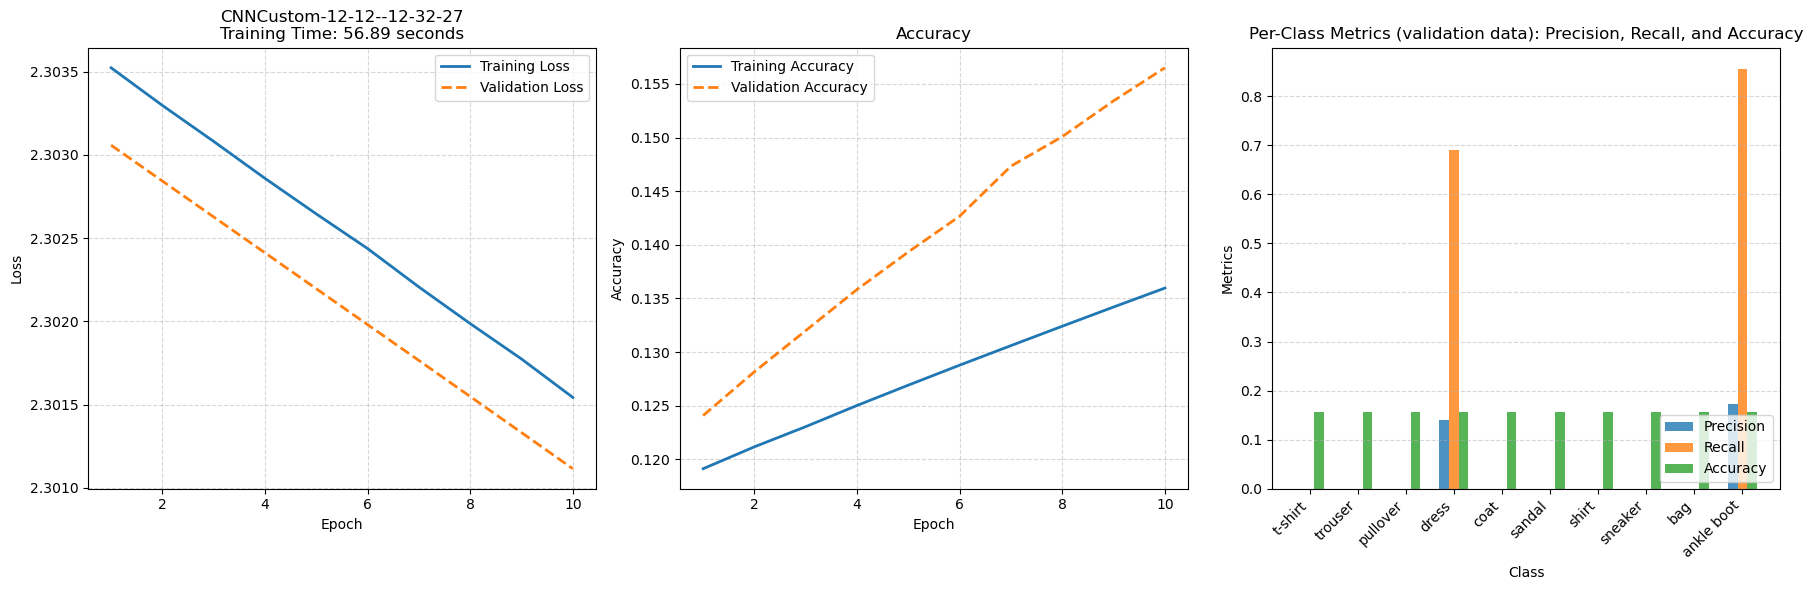

Model saved to: models\CNN_LR_1e-4_BS1024_lr0p0001_bs1024.pkl
Training and evaluation completed. Model saved at: models/CNN_LR_1e-4_BS1024_lr0p0001_bs1024.pkl


100%|██████████| 10/10 [00:00<00:00, 13.46it/s]


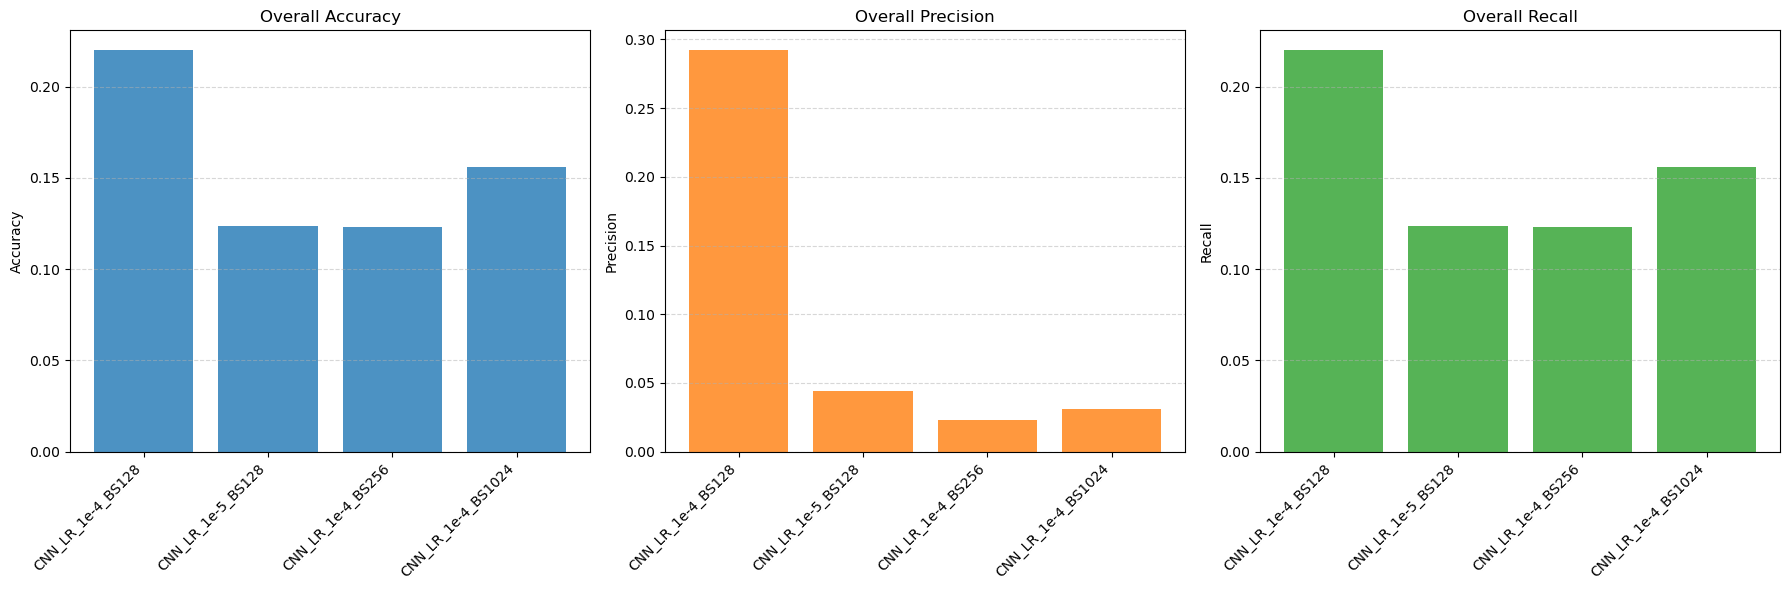

100%|██████████| 10/10 [00:00<00:00, 13.00it/s]


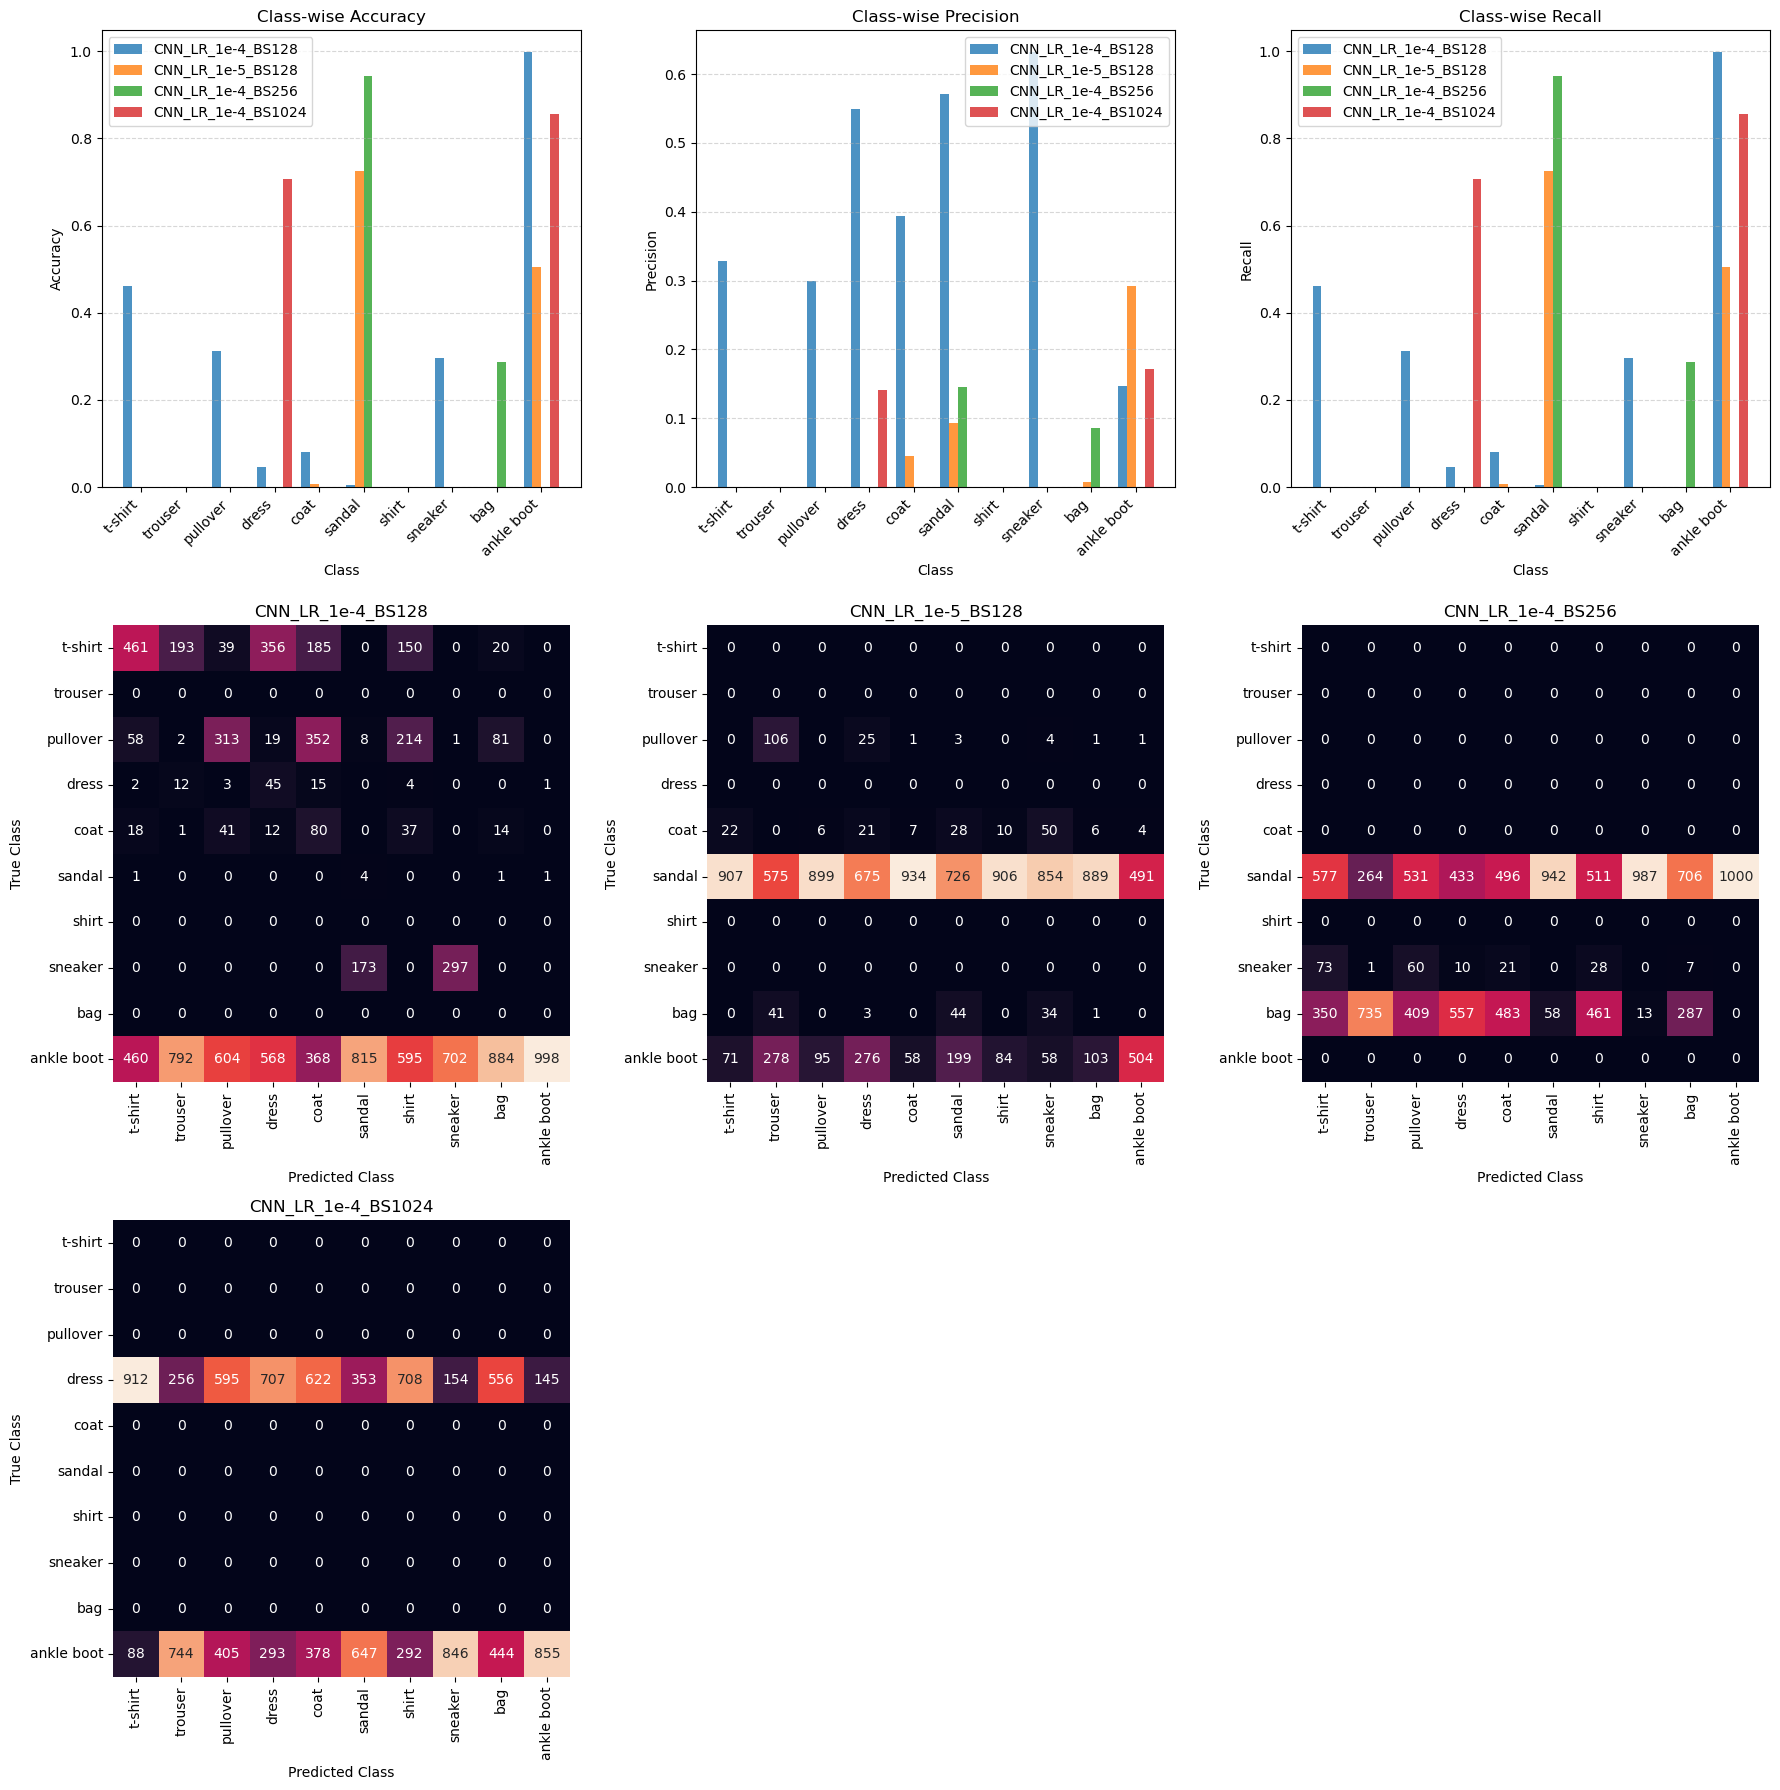

In [9]:
# Train CNN models with different hyperparameters
file_lr_1e4_bs_128 = train_pytorch_network_cnn(
    conv_layers=[(16, 5), (32, 3)], # CNNBasic architecture
    fully_connected_hidden_layers=[128, 10],          # Fully connected layers
    activation_fn='relu',         
    learning_rate=1e-4,           
    batch_size=128,               
    epochs=10,                    
    model_name="CNN_LR_1e-4_BS128"
)

file_lr_1e5_bs_128 = train_pytorch_network_cnn(
    conv_layers=[(16, 5), (32, 3)],
    fully_connected_hidden_layers=[128, 10],
    activation_fn='relu',
    learning_rate=1e-5,
    batch_size=128,
    epochs=10,
    model_name="CNN_LR_1e-5_BS128"
)

file_lr_1e4_bs_256 = train_pytorch_network_cnn(
    conv_layers=[(16, 5), (32, 3)],
    fully_connected_hidden_layers=[128, 10],
    activation_fn='relu',
    learning_rate=1e-4,
    batch_size=256,
    epochs=10,
    model_name="CNN_LR_1e-4_BS256"
)

file_lr_1e4_bs_1024 = train_pytorch_network_cnn(
    conv_layers=[(16, 5), (32, 3)],
    fully_connected_hidden_layers=[128, 10],
    activation_fn='relu',
    learning_rate=1e-4,
    batch_size=1024,
    epochs=10,
    model_name="CNN_LR_1e-4_BS1024"
)

# Load the trained models into a dictionary
CNN_models = {
    'CNN_LR_1e-4_BS128': PyTorchTrainer.load(file_lr_1e4_bs_128),
    'CNN_LR_1e-5_BS128': PyTorchTrainer.load(file_lr_1e5_bs_128),
    'CNN_LR_1e-4_BS256': PyTorchTrainer.load(file_lr_1e4_bs_256),
    'CNN_LR_1e-4_BS1024': PyTorchTrainer.load(file_lr_1e4_bs_1024),
}

# Evaluate overall performance metrics
evaluate_overall_metrics(CNN_models)

# Evaluate class-wise performance
evaluate(CNN_models)


## Task 8 reflection

With such a low learning rate, together with few epochs, no model gets good results.
This would require that our initial random guess, was quite close to ground truth.

## Comparing the different model architectures

---
**Task 9 (easy): Evaluation👩‍💻💡**
In the cell below:
1. Select the best performing MLP and CNN and update the cell below to store these models in the `MLPCNN_models`
 dictionary.
2. Use the  `evaluate_overall_metrics`
 function to visualize the overall performance of the models.
3. Use the `evaluate`
 function to visualize the class-wise performance of the models.


---

100%|██████████| 79/79 [00:00<00:00, 103.06it/s]


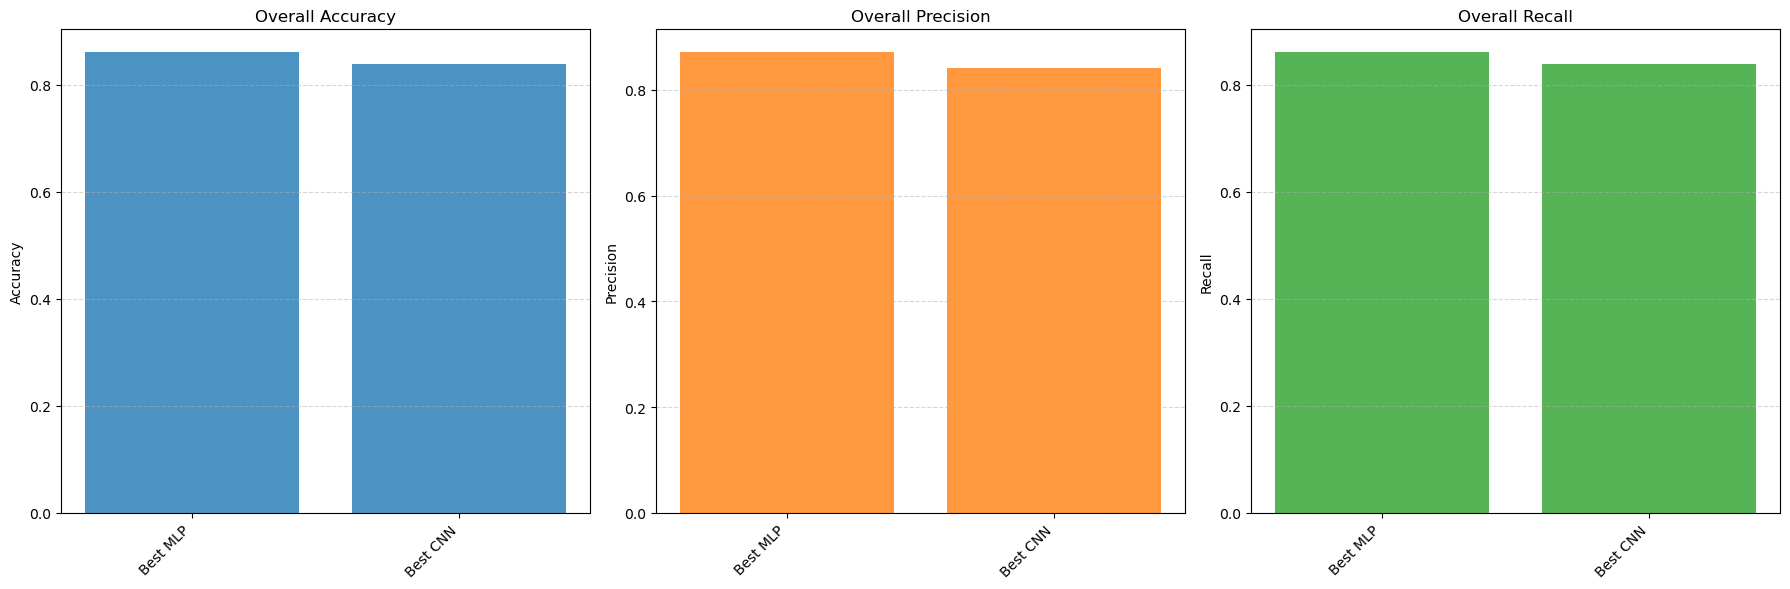

100%|██████████| 79/79 [00:00<00:00, 92.61it/s]


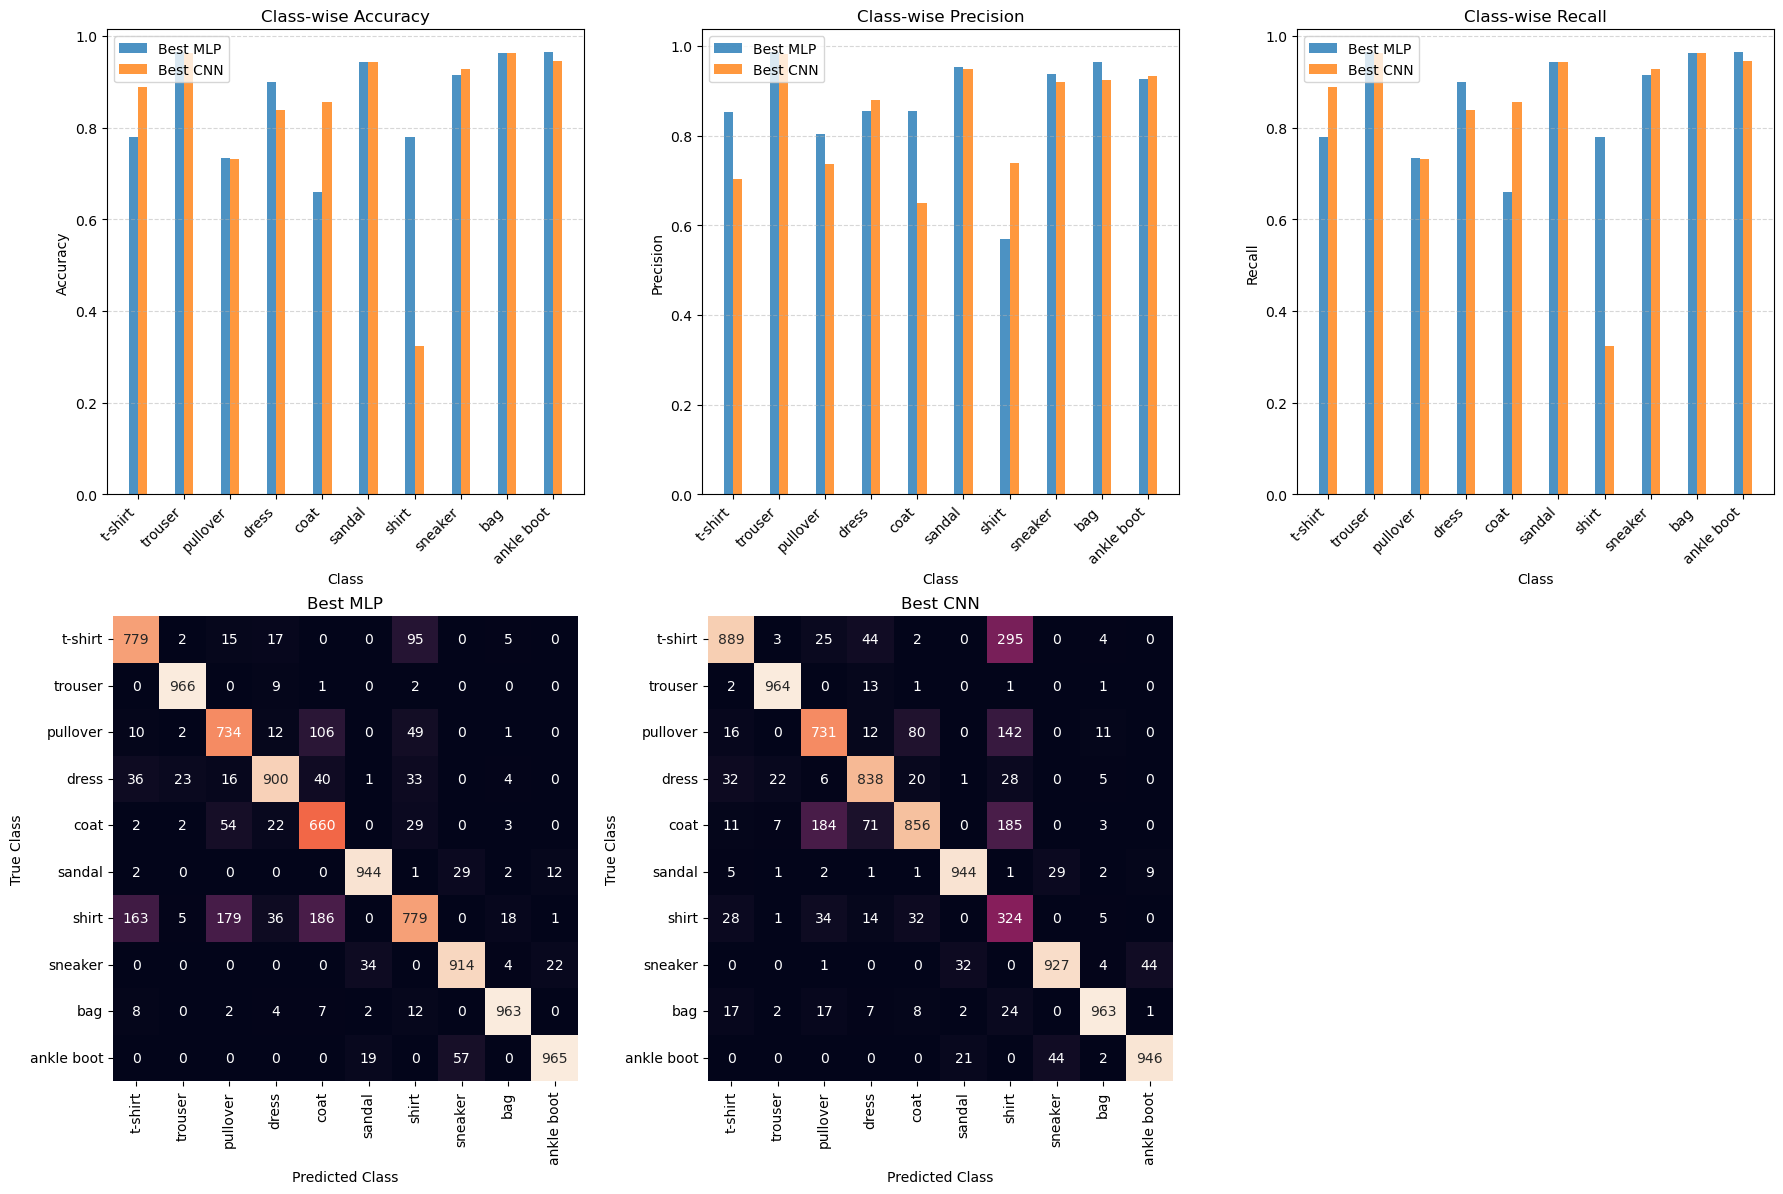

In [10]:
MLPCNN_models = {
    'Best MLP': PyTorchTrainer.load(file_lr_1e1_bs_128),
    'Best CNN': PyTorchTrainer.load(file_cnn_basic),
    }

# Visualize overall performance of MLP and CNN
evaluate_overall_metrics(MLPCNN_models)

# Visualize class-wise performance
evaluate(MLPCNN_models)


Evaluate the performance of the different architectures.

---
**Task 10 (easy): Evaluation💡**
1. Training
    - Analyze the figures and explain the key characteristics of the training process for the models.


2. Metrics
    - Assess the performance of the models by examining the confusion matrices and comparing the MLP and CNN models in terms of accuracy, precision, and recall. Discuss the strengths and weaknesses of each model based on the metrics.




---

## Task 10 reflection

**Best MLP:**
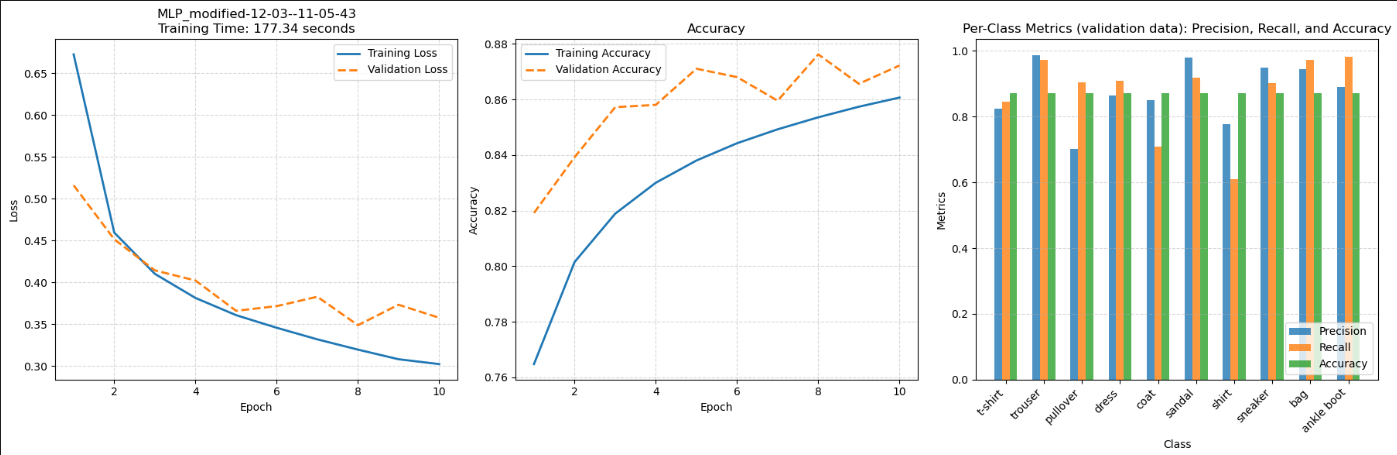

**Best CNN:**
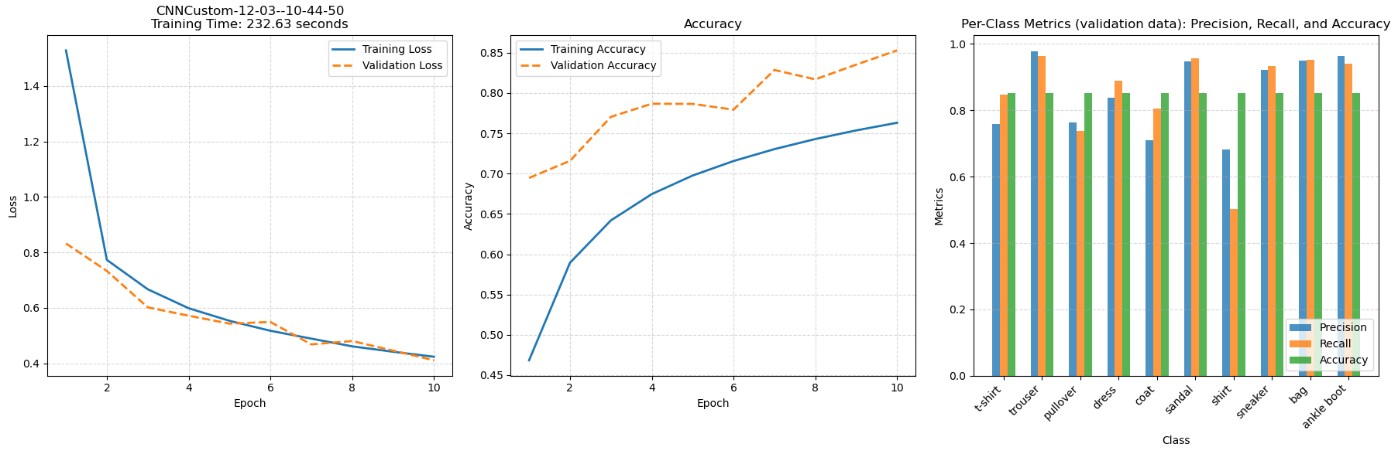

**Training:**
* CNN: 232.63
* MLP:177.
  * In this case it was faster to directly train a MLP on 28x28 = 784 input nodes. Compared to CNN where we use some time to reduce our input size from 784 to 256 in our MLP. If the original image for example had been 1600x1980 it would be faster to train CNN.


**Metrics:**
* MLP Acc: 0.87
* CNN ACc: 0.85
  * On all 3 metrics, they perform quite close to each other, with a slight edge towards MLP. But if we were to give them different parameters / input size image, this would change.

## Modifying architectures
The next part of the exercise is about experimenting with the architecture of an NN such as _number of layers_, _number of perceptrons (nodes)_ and _kernel size_.
### MLP
The following task will add a hidden layer to the MLP model. 

---
**Task 11 (medium): Adding a hidden layer👩‍💻**
1. Locate the class `MLP_modified`
 in the `networks.py`
 file. The `MLP_modified`
 class is a copy of the `MLPBasic`
 and the following steps are about making changes in the architecture.
2. Modify the architecture by adding a new hidden layer with 256 nodes, by updating the constructor. Ensure that the number of input and output features match between the layers.
3. Update the `forward`
 function to ensure this new hidden layer is used in the predictions. 
4. Train the model by running the cell below.


---

Training MLP_Task11...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 131.41it/s]


[Validation] Epoch 1: acc: 0.6773, val_loss: 0.8629, train_acc: 0.5497
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 143.92it/s]


[Validation] Epoch 2: acc: 0.7673, val_loss: 0.6635, train_acc: 0.6383
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 146.19it/s]


[Validation] Epoch 3: acc: 0.7997, val_loss: 0.5803, train_acc: 0.6868
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 141.02it/s]


[Validation] Epoch 4: acc: 0.8170, val_loss: 0.5309, train_acc: 0.7172
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 139.26it/s]


[Validation] Epoch 5: acc: 0.8265, val_loss: 0.5063, train_acc: 0.7376
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 138.44it/s]


[Validation] Epoch 6: acc: 0.8281, val_loss: 0.4917, train_acc: 0.7528
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 145.67it/s]


[Validation] Epoch 7: acc: 0.8417, val_loss: 0.4590, train_acc: 0.7646
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 145.26it/s]


[Validation] Epoch 8: acc: 0.8463, val_loss: 0.4475, train_acc: 0.7739
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 145.57it/s]


[Validation] Epoch 9: acc: 0.8457, val_loss: 0.4448, train_acc: 0.7816
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 139.67it/s]


[Validation] Epoch 10: acc: 0.8456, val_loss: 0.4560, train_acc: 0.7881


100%|██████████| 79/79 [00:00<00:00, 147.87it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62E3E9DE0>


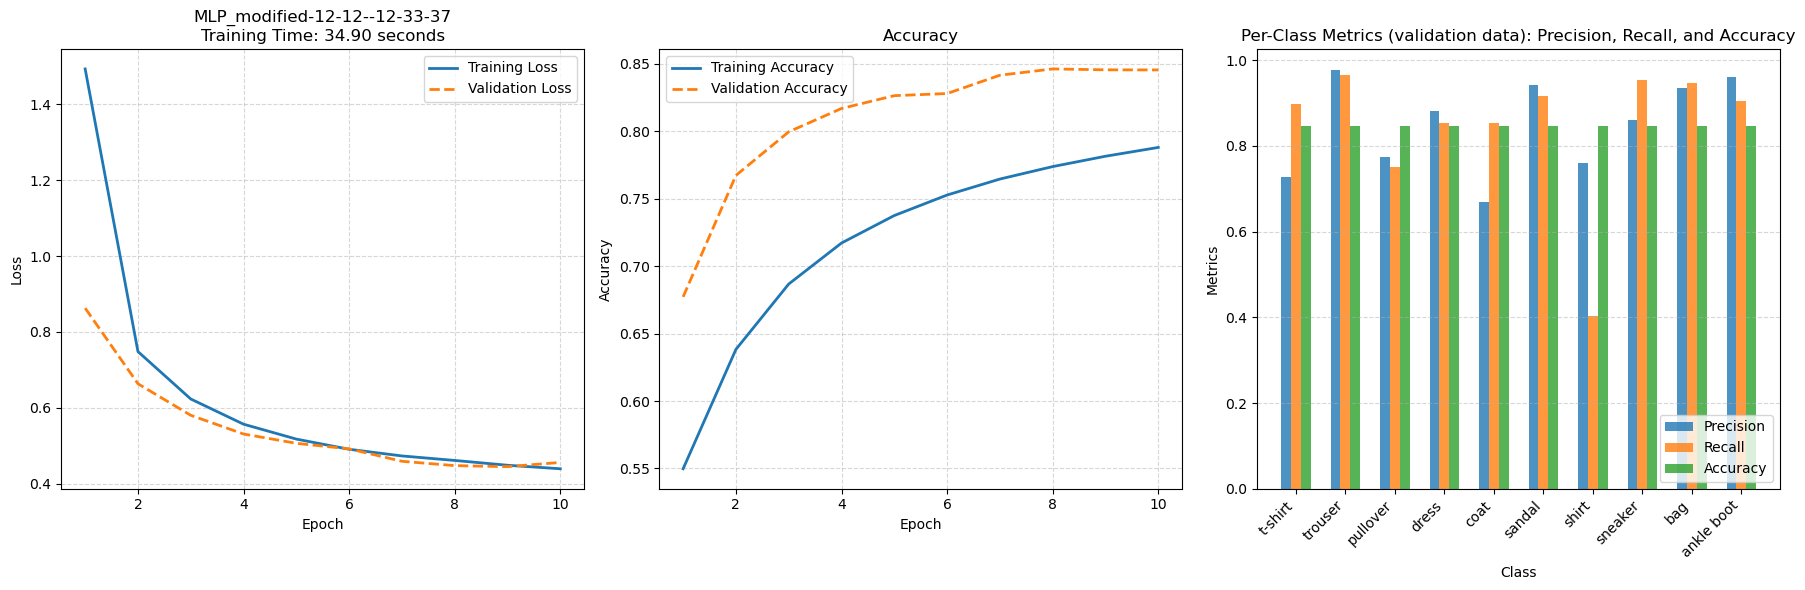

Model saved to: models\MLP_Task11_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/MLP_Task11_lr0p01_bs128.pkl
MLP_Task11 model saved at: models/MLP_Task11_lr0p01_bs128.pkl


In [11]:
# Train the modified MLP model with an additional hidden layer
file_mlp_task11 = train_pytorch_network_mlp(
    hidden_layers=[100, 256],     #Here we add the new hidden layer with 256 nodes
    activation_fn='relu',         
    learning_rate=1e-2,           
    batch_size=128,               
    epochs=10,                    
    model_name="MLP_Task11"      
)

print(f"MLP_Task11 model saved at: {file_mlp_task11}")


---
**Task 12 (easy): Compare performance💡**
1. Examine the training figures to identify and explain the characteristics of the model’s training process. 


---

## Task 12 reflection

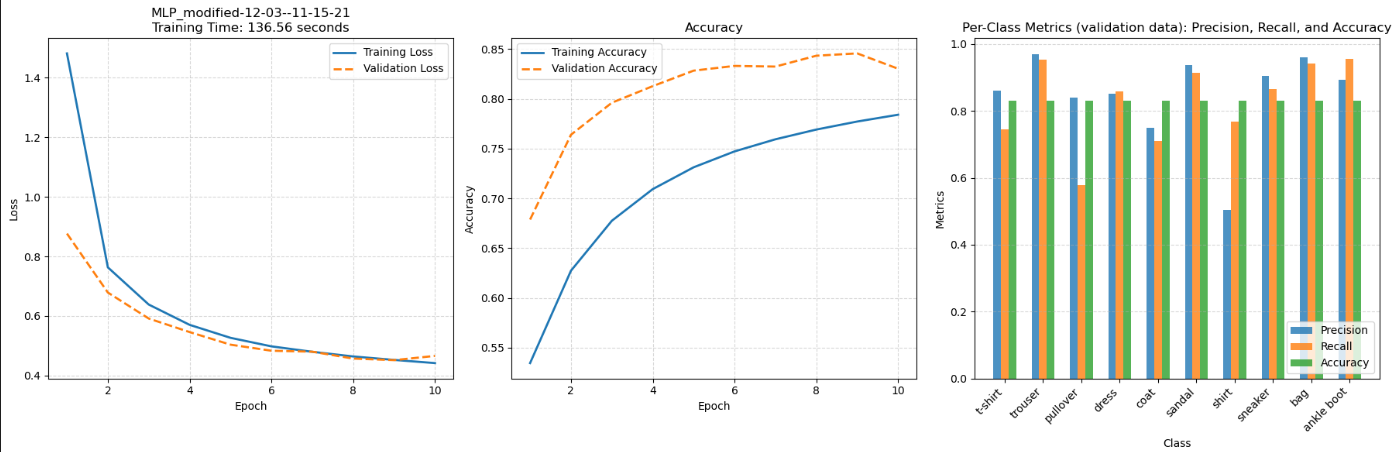
The more layers and nodes we add, the more flexibility the model has, but this might also lead to overfitting. This indication can also be seen, as the layer epochs have reduced validation loss and acc.

Evaluate the modified MLP against the `MLPBasic()`


---
**Task 13 (easy): Compare architectures👩‍💻💡**
In the cell below:
1. Identify the best-performing `MLP`
 and `MLPModified`
 models based on the evaluation metrics. Update the cell below to store these selected models in the `modelsMLPModified`
 dictionary.
2. Use the `evaluate_overall_metrics`
 function to visualize the overall performance of the models.
3. Use the `evaluate`
 function to visualize the class-wise performance of the models.


---

100%|██████████| 79/79 [00:00<00:00, 149.87it/s]


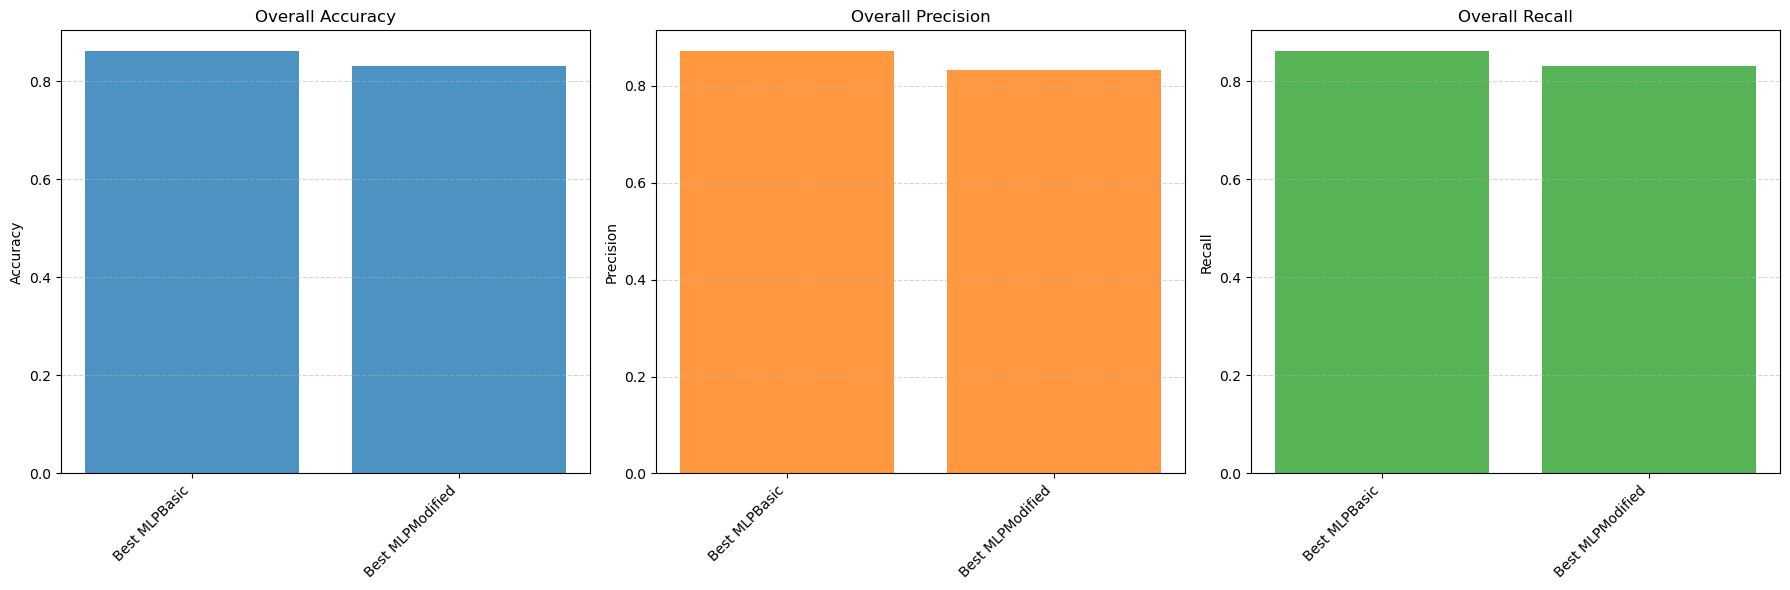

100%|██████████| 79/79 [00:00<00:00, 140.29it/s]


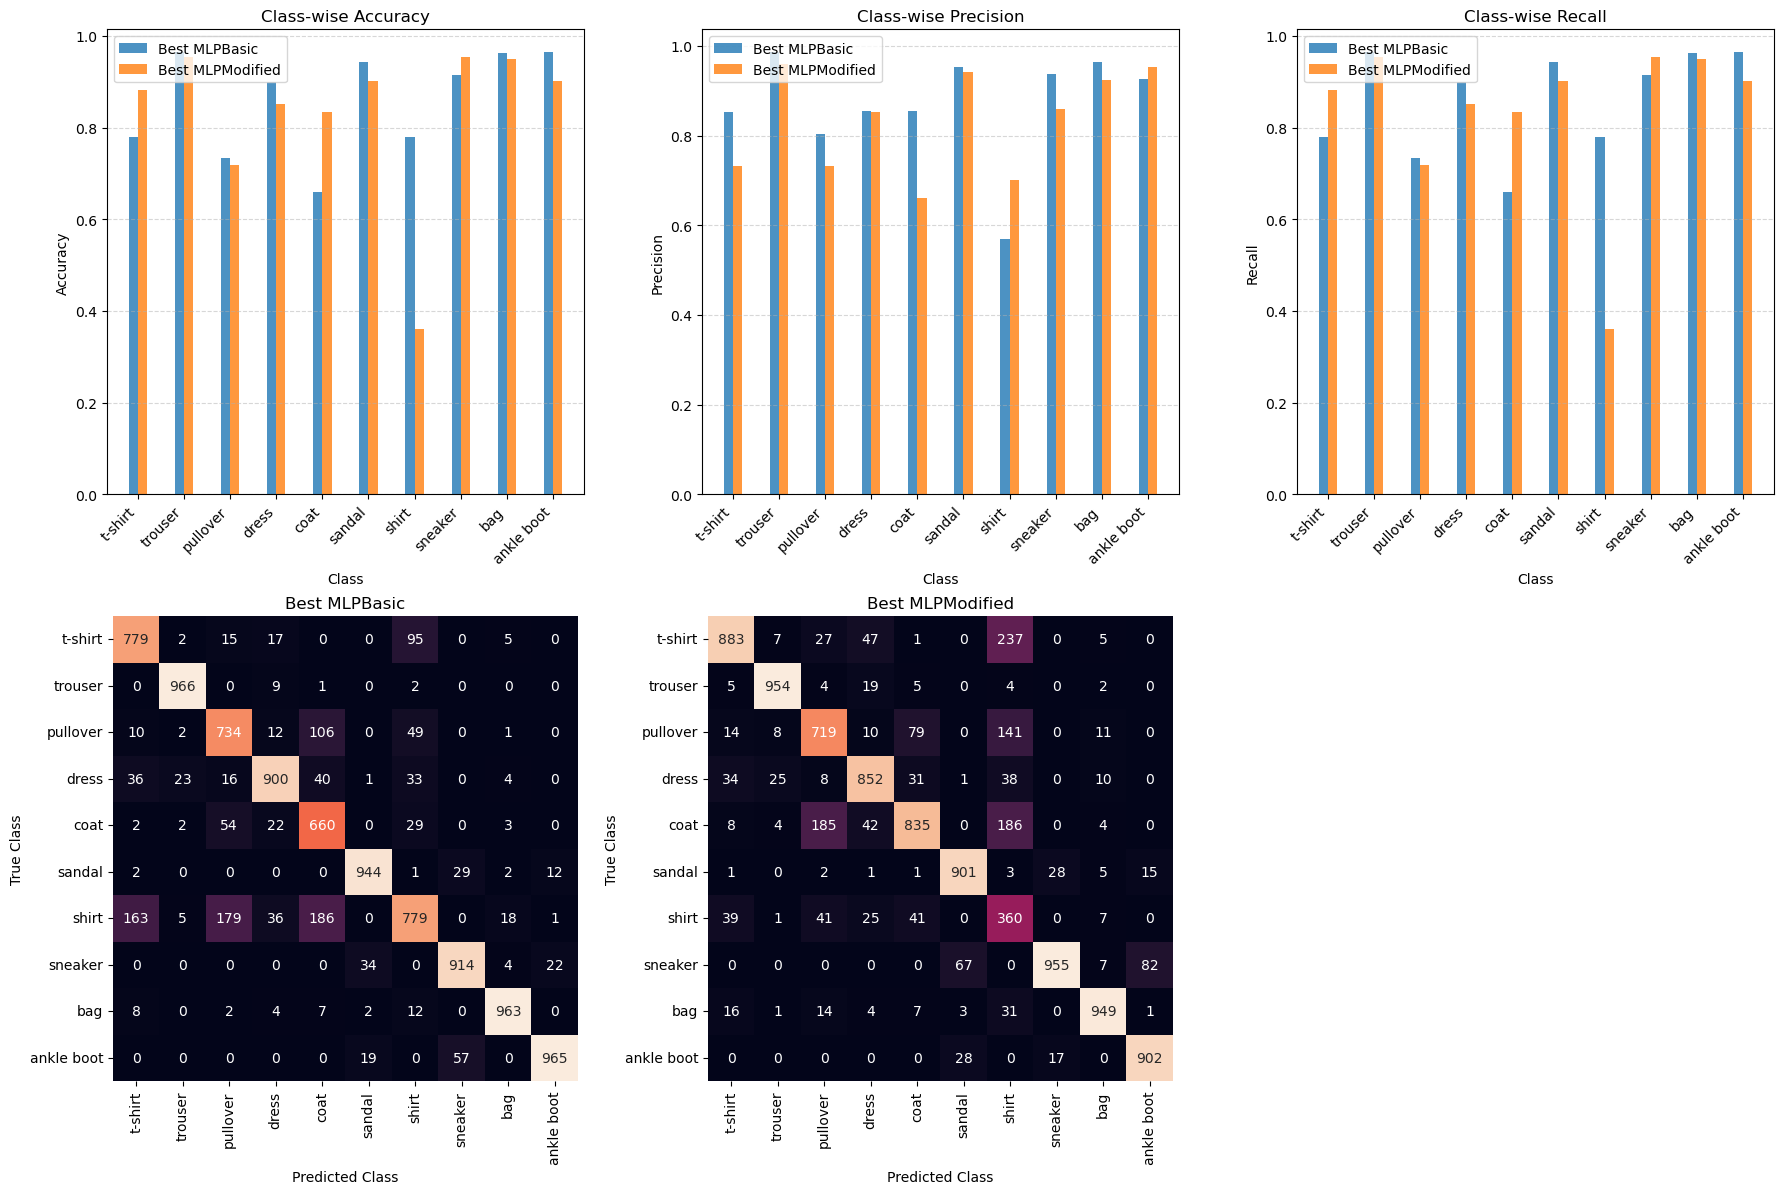

In [12]:
# Load models into a dictionary
MLPModified_model = {
    'Best MLPBasic': PyTorchTrainer.load(file_lr_1e1_bs_128), 
    'Best MLPModified': PyTorchTrainer.load(file_mlp_task11)
}

# Compare overall metrics
evaluate_overall_metrics(MLPModified_model)

# Compare class-wise metrics
evaluate(MLPModified_model)


---
**Task 14 (easy): Compare performance💡**
1. Evaluate the performance of the models by analyzing the confusion matrices. Compare the MLP and MLPModified models in terms of key metrics such as accuracy, precision, and recall, and provide a detailed explanation of their relative strengths and weaknesses based on these metrics


---

## Task 14 reflection

MLP performs better than our MLPModified. Suggesting that adding additional hidden layers introduced some overfitting, making the models perform worse on validation data.

---
**Task 15 (easy): Update architecture👩‍💻💡**
1. Change the number of hidden nodes to 512 (adjust the other layers accordingly). 
2. Rerun the cell above to train the new model. 
3. Include the new model in the dictionary. 
4. Evaluate the model and compare it with the others as in [Task 13](#CNN_mod).

Training MLP_Task15...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 137.98it/s]


[Validation] Epoch 1: acc: 0.7133, val_loss: 0.8242, train_acc: 0.5528
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 135.17it/s]


[Validation] Epoch 2: acc: 0.7742, val_loss: 0.6396, train_acc: 0.6512
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 137.37it/s]


[Validation] Epoch 3: acc: 0.8007, val_loss: 0.5674, train_acc: 0.7001
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 142.40it/s]


[Validation] Epoch 4: acc: 0.8186, val_loss: 0.5252, train_acc: 0.7297
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 143.80it/s]


[Validation] Epoch 5: acc: 0.8296, val_loss: 0.4950, train_acc: 0.7491
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 145.03it/s]


[Validation] Epoch 6: acc: 0.8377, val_loss: 0.4716, train_acc: 0.7632
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 146.39it/s]


[Validation] Epoch 7: acc: 0.8309, val_loss: 0.4887, train_acc: 0.7742
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 141.77it/s]


[Validation] Epoch 8: acc: 0.8433, val_loss: 0.4525, train_acc: 0.7829
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 143.48it/s]


[Validation] Epoch 9: acc: 0.8366, val_loss: 0.4646, train_acc: 0.7901
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 146.65it/s]


[Validation] Epoch 10: acc: 0.8367, val_loss: 0.4653, train_acc: 0.7962


100%|██████████| 79/79 [00:00<00:00, 142.31it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F642BD5960>


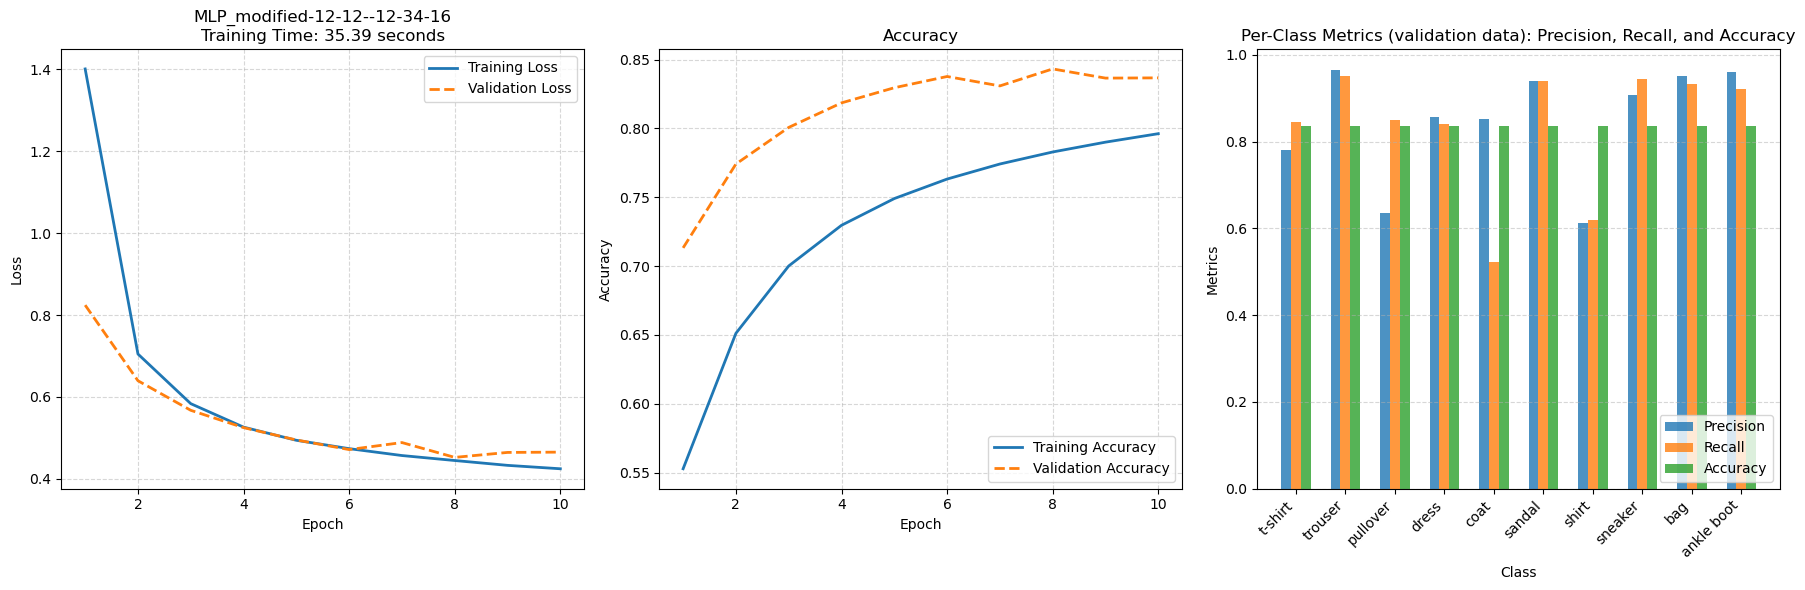

Model saved to: models\MLP_Task15_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/MLP_Task15_lr0p01_bs128.pkl


100%|██████████| 79/79 [00:00<00:00, 142.31it/s]


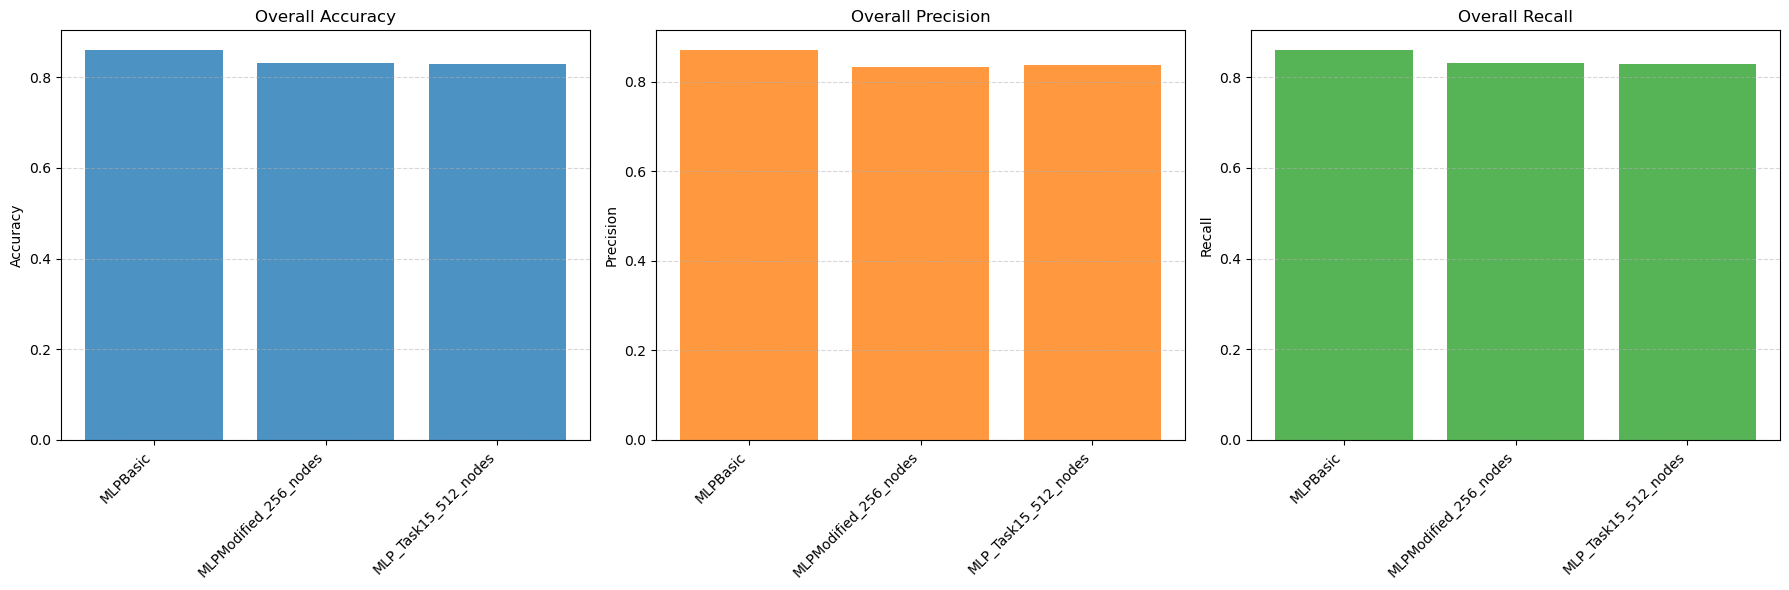

100%|██████████| 79/79 [00:00<00:00, 138.80it/s]


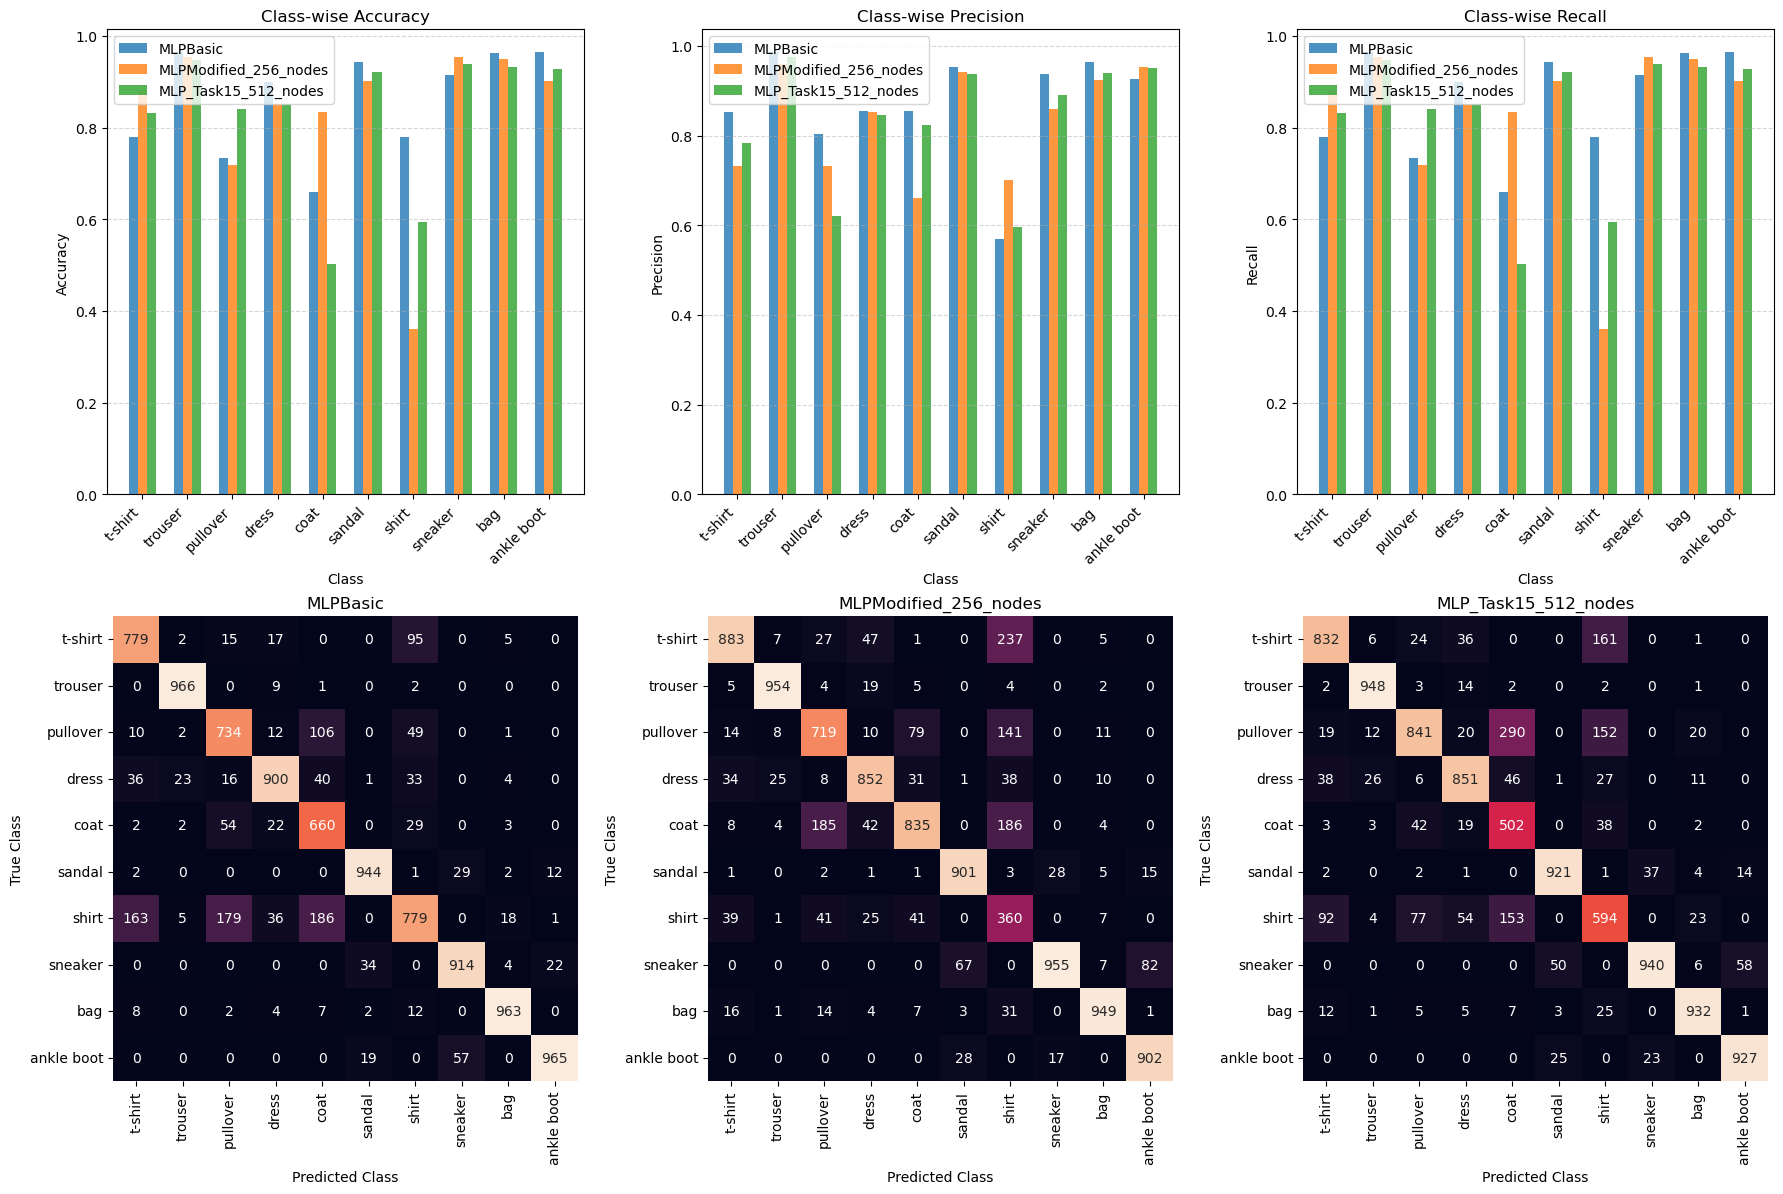

In [13]:
trainer_task_15 = train_pytorch_network_mlp(
    hidden_layers=[100, 512],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="MLP_Task15"
)

MLPModified_model = {
    'MLPBasic': PyTorchTrainer.load(file_lr_1e1_bs_128),
    'MLPModified_256_nodes': PyTorchTrainer.load(file_mlp_task11),
    'MLP_Task15_512_nodes': PyTorchTrainer.load(trainer_task_15)
}

# Evaluate overall metrics
evaluate_overall_metrics(MLPModified_model)

# Evaluate class-wise metrics
evaluate(MLPModified_model)

## Task 15 reflection

**Result of changing 256 nodes to 512 nodes in the second hidden layer:**
Improved all 3 metrics. Suggesting that perhaps more nodes capture the needed flexibility to identify features of the objects.


## Convolutional Neural Network
The following task will involve modifying the architechture of the CNN. 

**Hint**
- Recall that the kernel size influences the size of the output image. Specifically, for kernel size $k$, the output has dimensions $w-(k-1) \times h-(k-1)$ where $w$ is the width and $h$ is the height of an image. Adding a convolutional layer is consequently a bit more tricky than a linear layer because the dimensions between the layers need to match. You will likely need to debug the model a few times to get it right, therefor we encourage you to carefully examine the structure of the network before modifying it.
- Convolutional layers MAY be accompanied with a max pooling layer, but remember to use an activation function.
- The `max_pool2d`
 operation in the`forward`
 function halves the image resolution. 



---
**Task 16 (medium): Adding a convolutional layer👩‍💻**
1. Locate the class `CNN_modified()`
 in the `networks.py`
 file.
1. Examine the class to gain an overview of the network architecture. _Note that it is a copy of the CNNBasic() class_.
2. Add a new `Conv2d`
 layer to the `CNN_modified`
 class by decreasing the kernel size of the existing first layer and add the new layer as the second layer.


**Hint**
Use `tensor.size`
 to get the size of any tensor.

4. Update the `forward`
 method to ensure this new hidden layer is used in the predictions. 
5. Train the model by running the cell below.


---

Training CNN_Task16...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 99.76it/s] 


[Validation] Epoch 1: acc: 0.3145, val_loss: 2.1759, train_acc: 0.1757
[Epoch 2]


100%|██████████| 94/94 [00:01<00:00, 74.06it/s]


[Validation] Epoch 2: acc: 0.6677, val_loss: 0.9168, train_acc: 0.3586
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 99.88it/s] 


[Validation] Epoch 3: acc: 0.7163, val_loss: 0.7698, train_acc: 0.4651
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 99.57it/s] 


[Validation] Epoch 4: acc: 0.7024, val_loss: 0.7853, train_acc: 0.5269
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 102.81it/s]


[Validation] Epoch 5: acc: 0.7422, val_loss: 0.6923, train_acc: 0.5674
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 100.21it/s]


[Validation] Epoch 6: acc: 0.7397, val_loss: 0.6840, train_acc: 0.5967
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 100.99it/s]


[Validation] Epoch 7: acc: 0.7668, val_loss: 0.6427, train_acc: 0.6190
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 102.31it/s]


[Validation] Epoch 8: acc: 0.7652, val_loss: 0.6342, train_acc: 0.6369
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 105.01it/s]


[Validation] Epoch 9: acc: 0.7719, val_loss: 0.6104, train_acc: 0.6518
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 97.62it/s]


[Validation] Epoch 10: acc: 0.7912, val_loss: 0.5653, train_acc: 0.6644


100%|██████████| 79/79 [00:00<00:00, 104.74it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F633D13B80>


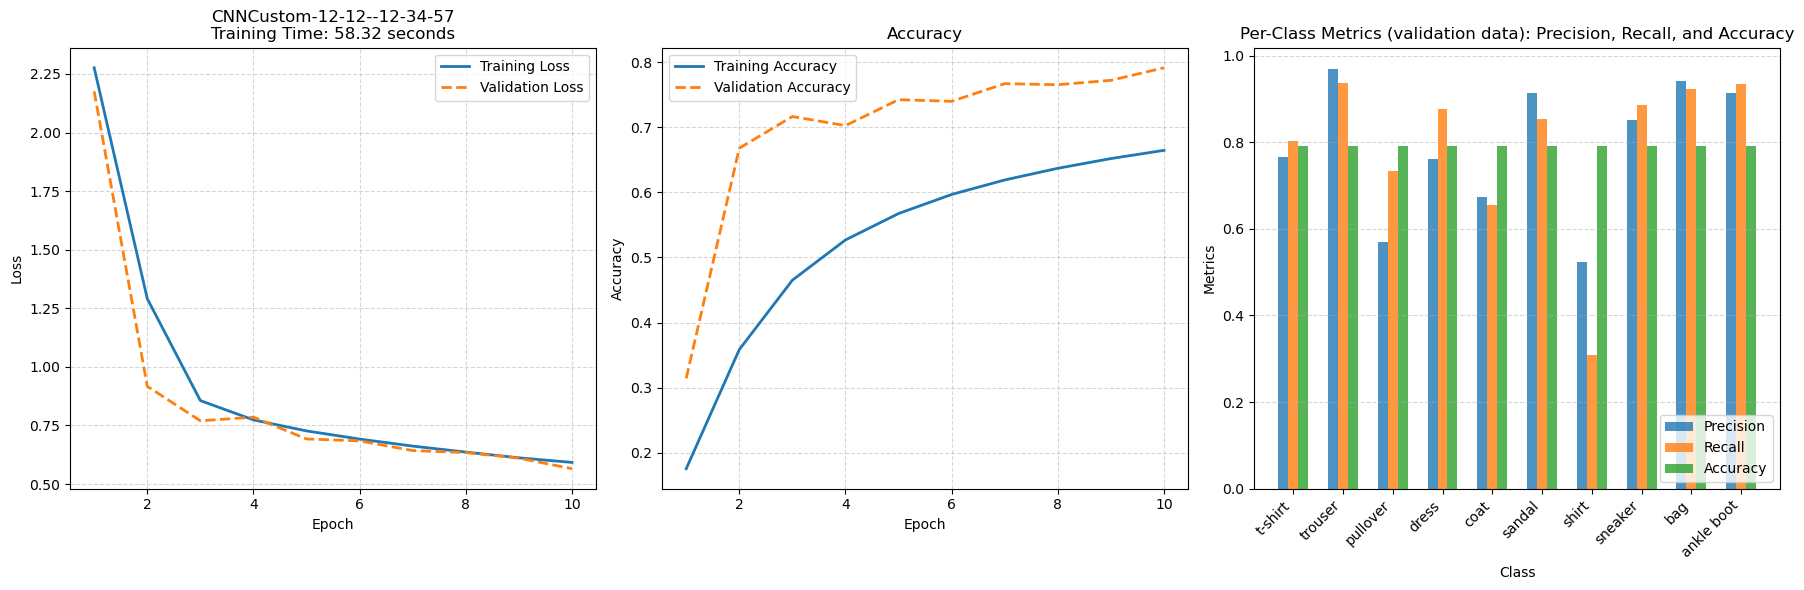

Model saved to: models\CNN_Task16_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_Task16_lr0p01_bs128.pkl


In [14]:
trainer_task_16 = train_pytorch_network_cnn(
    conv_layers=[(16, 5), (32, 3), (64, 3)], #3 layers. 16 kernels of size 5, 32 kernels of size 3, 64 kernels of size 3
    fully_connected_hidden_layers=[128, 10], # 2 layers. 128 nodes in the hidden layer, 10 nodes in the output layer
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_Task16"
)


## Task 16 Reflection: `CNN_Task16` Architecture


**See task 18 for analysis of results.**

**Activation Function**: ReLU

---

### 1. Convolutional Layer 1
- **Input**: A grayscale image with 1 channel of `28 * 28` pixels.
- **Operation**: Applies **16 convolutional kernels (filters)**, each of size `5 * 5`.
- **Output Size Calculation**:  
  \((28 - 5 + 1) * (28 - 5 + 1) = 24 * 24\)
- **Output**: `16` feature maps, each of size `24 * 24`.

---

### 2. Max Pooling 1
- **Operation**: Downsamples the feature maps using a pooling window of `2 * 2` with a stride of `2`. This reduces spatial dimensions while keeping the depth (number of feature maps) the same.
- **Output Size Calculation**:  
  \(24 / 2 = 12 * 12\)
- **Output**: `16` feature maps, each of size `12 * 12`.

---

### 3. Convolutional Layer 2
- **Input**: `16` feature maps, each of size `12 * 12` from the previous layer.
- **Operation**: Applies **32 convolutional kernels (filters)**, each of size `3 * 3`.
- **Output Size Calculation**:  
  \((12 - 3 + 1) * (12 - 3 + 1) = 10 * 10\)
- **Output**: `32` feature maps, each of size `10 * 10`.

---

### 4. Max Pooling 2
- **Operation**: Downsamples the feature maps using a pooling window of `2 * 2` with a stride of `2`.
- **Output Size Calculation**:  
  \(10 / 2 = 5 * 5\)
- **Output**: `32` feature maps, each of size `5 * 5`.

---

### 5. Convolutional Layer 3
- **Input**: `32` feature maps, each of size `5 * 5` from the previous layer.
- **Operation**: Applies **64 convolutional kernels (filters)**, each of size `3 * 3`.
- **Output Size Calculation**:  
  \((5 - 3 + 1) * (5 - 3 + 1) = 3 * 3\)
- **Output**: `64` feature maps, each of size `3 * 3`.

---

### 6. Max Pooling 3
- **Operation**: Downsamples the feature maps using a pooling window of `2 * 2` with a stride of `2`.
- **Output Size Calculation**:  
  \(3 / 2 = 1 * 1\)
- **Output**: `64` feature maps, each of size `1 * 1`.

---

### 7. Flattening
- **Operation**: The `64` feature maps of size `1 * 1` are flattened into a single vector.
- **Size Calculation**:  
  \(1 * 1 * 64 = 64\)
- **Output**: A `64`-dimensional vector.

---

### 8. Fully Connected (Linear) Layer 1
- **Input**: The `64`-dimensional vector from the flattening layer.
- **Operation**: Applies a fully connected layer with `128` neurons.
- **Output**: A `128`-dimensional vector.

---

### 9. Fully Connected (Linear) Layer 2 (Output Layer)
- **Input**: The `128`-dimensional vector from the first fully connected layer.
- **Operation**: Applies a fully connected layer with `10` neurons (one for each class in FashionMNIST).
- **Output**: A `10`-dimensional vector.

---

### Summary
- **Input Dimensions**: `28 * 28` grayscale images.
- **Convolutional Layers**: 3.
- **Fully Connected Layers**: 2.
- **Output**: 10 classes for classification.



---
**Task 17 (easy): Compare architectures👩‍💻💡**

**See task 18 for analysis of results**

1. Fill in the dictionary below with the best performing `CNNBasic()`
 model and the `CNNModified()`
.
2. Visualize the overall performance by running `evaluate_overall_metrics`
 function.
3. Visualize the class-wise performance by running the `evaluate`
 function.


---

100%|██████████| 79/79 [00:00<00:00, 101.02it/s]


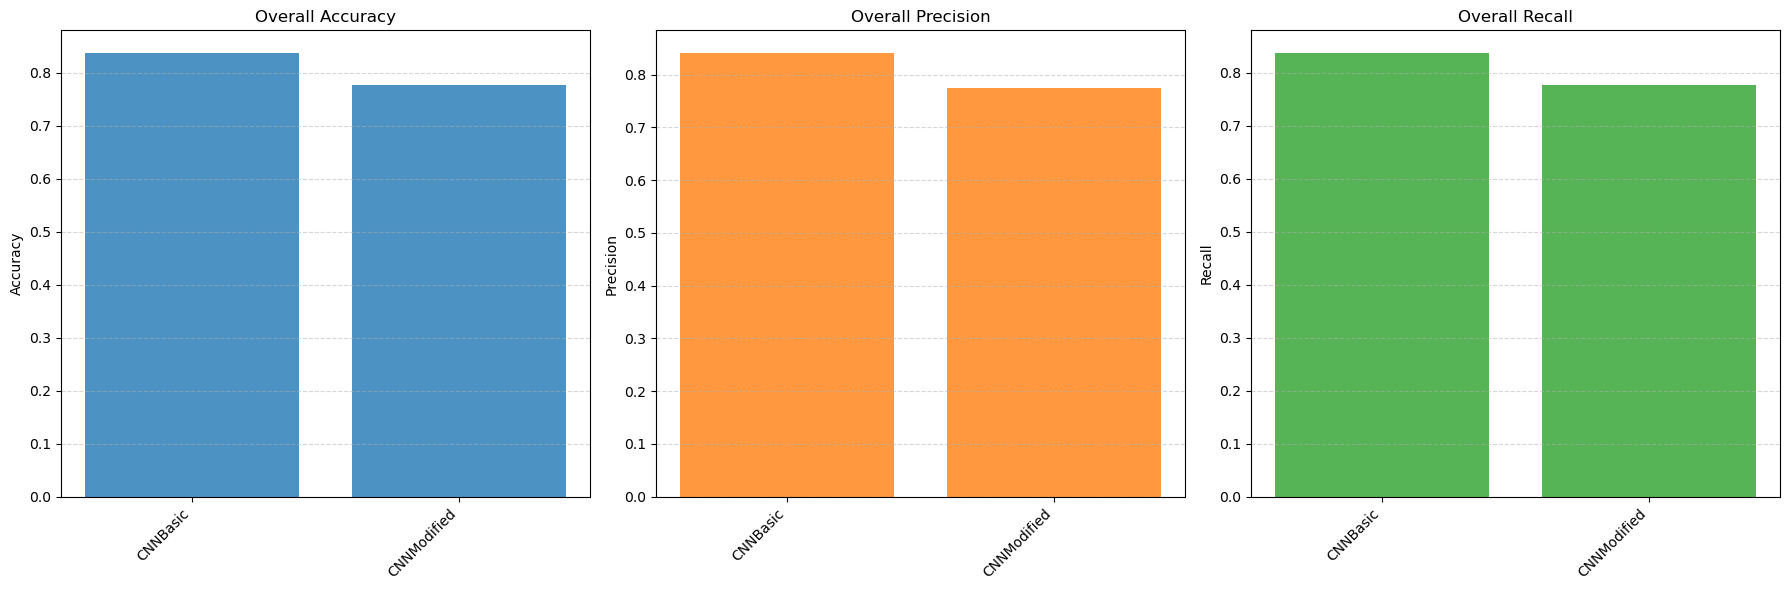

100%|██████████| 79/79 [00:00<00:00, 103.67it/s]


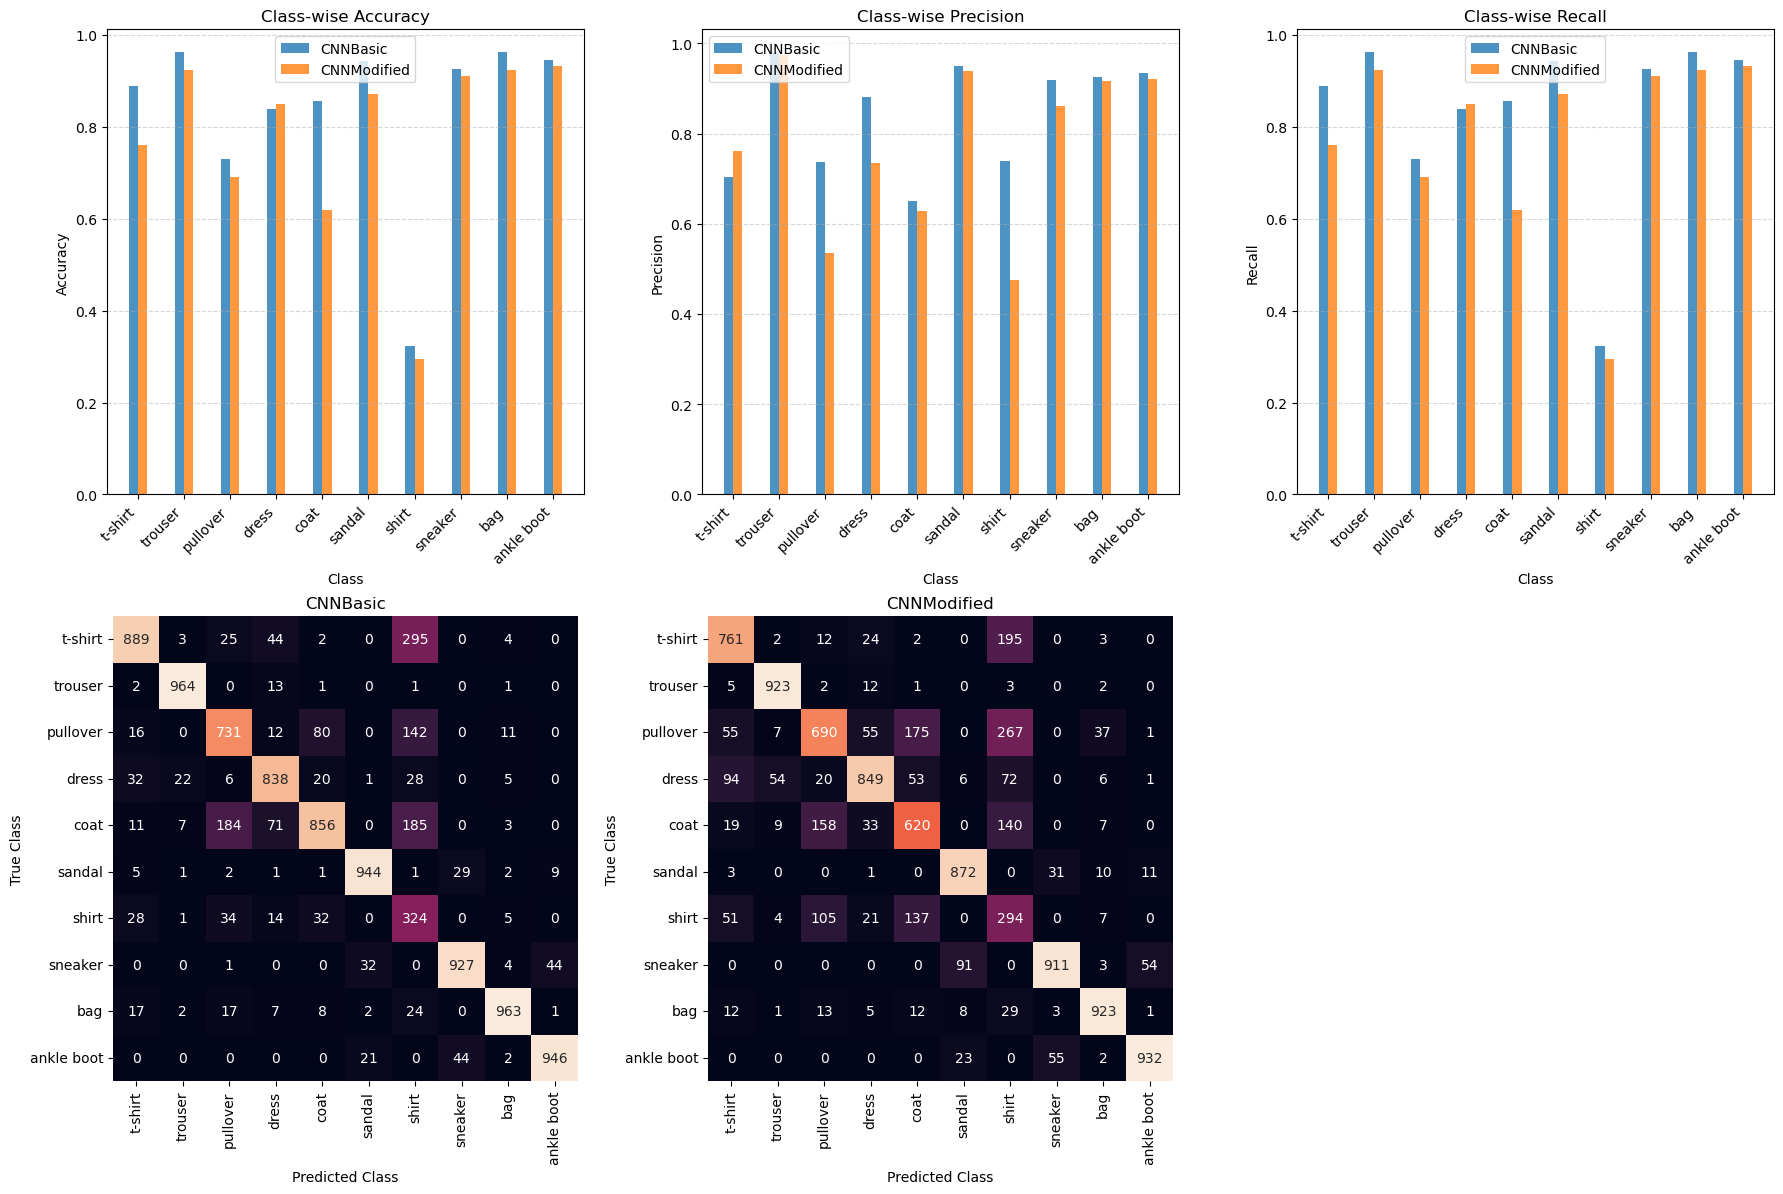

In [15]:
# Load the best-performing models
CNNModified_model = {
    'CNNBasic': PyTorchTrainer.load(file_cnn_basic),  # Replace with your best CNNBasic model
    'CNNModified': PyTorchTrainer.load(trainer_task_16)  # Replace with your best CNNModified model
}

# Compare overall metrics
evaluate_overall_metrics(CNNModified_model)

# Compare class-wise metrics
evaluate(CNNModified_model)


---
**Task 18 (medium): Compare architectures💡**
Evaluate the modified CNN against the `CNNBasic()`
 following the steps: 
1. During training:
    - Include the trained `CNNBasic()`
and the `CNNModified()`
 in the graphs (leave out the rest).
    - What patterns or trends do you observe in the loss and accuracy graphs and training time throughout training?


2. Update the dictionary below with the trained models and execute the cell. Compare the performance of the models, providing an analysis and explanation of the observed differences.

3. Change the kernel size and the number of kernels to achieve the best performing model, while avoiding overfitting. Run the cell above to train the new model. Include the new model in the dictionary, evaluate the model and compare it with the others.



---

Training CNN_TwoLayers_SmallAndFewKernels...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 115.13it/s]


[Validation] Epoch 1: acc: 0.6651, val_loss: 0.8808, train_acc: 0.4312
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 113.65it/s]


[Validation] Epoch 2: acc: 0.7183, val_loss: 0.7329, train_acc: 0.5679
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 117.04it/s]


[Validation] Epoch 3: acc: 0.7382, val_loss: 0.6467, train_acc: 0.6252
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 117.94it/s]


[Validation] Epoch 4: acc: 0.7688, val_loss: 0.6140, train_acc: 0.6598
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 114.52it/s]


[Validation] Epoch 5: acc: 0.7902, val_loss: 0.5599, train_acc: 0.6843
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 116.51it/s]


[Validation] Epoch 6: acc: 0.7988, val_loss: 0.5379, train_acc: 0.7031
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 117.92it/s]


[Validation] Epoch 7: acc: 0.8185, val_loss: 0.4960, train_acc: 0.7186
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 117.48it/s]


[Validation] Epoch 8: acc: 0.8177, val_loss: 0.4893, train_acc: 0.7311
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 118.07it/s]


[Validation] Epoch 9: acc: 0.8208, val_loss: 0.4819, train_acc: 0.7419
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 113.25it/s]


[Validation] Epoch 10: acc: 0.8347, val_loss: 0.4587, train_acc: 0.7510


100%|██████████| 79/79 [00:00<00:00, 117.56it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62E3EA380>


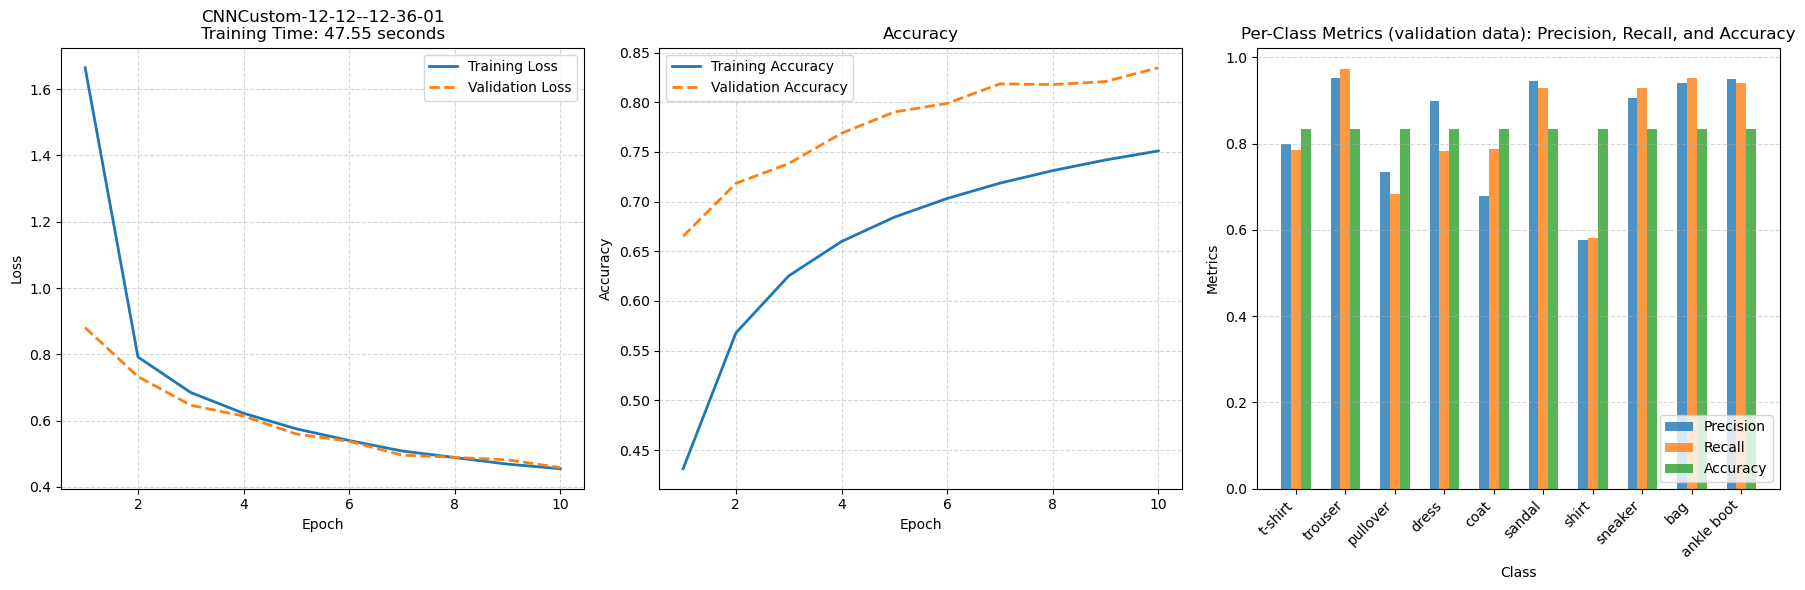

Model saved to: models\CNN_TwoLayers_SmallAndFewKernels_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_TwoLayers_SmallAndFewKernels_lr0p01_bs128.pkl
Training CNN_TwoLayers_SmallKernels...
[Epoch 1]


100%|██████████| 94/94 [00:01<00:00, 72.28it/s]


[Validation] Epoch 1: acc: 0.6975, val_loss: 0.8322, train_acc: 0.4936
[Epoch 2]


100%|██████████| 94/94 [00:01<00:00, 73.08it/s]


[Validation] Epoch 2: acc: 0.7221, val_loss: 0.7161, train_acc: 0.6060
[Epoch 3]


100%|██████████| 94/94 [00:01<00:00, 73.77it/s]


[Validation] Epoch 3: acc: 0.7631, val_loss: 0.6186, train_acc: 0.6542
[Epoch 4]


100%|██████████| 94/94 [00:01<00:00, 74.01it/s]


[Validation] Epoch 4: acc: 0.7907, val_loss: 0.5601, train_acc: 0.6848
[Epoch 5]


100%|██████████| 94/94 [00:01<00:00, 70.20it/s]


[Validation] Epoch 5: acc: 0.8057, val_loss: 0.5253, train_acc: 0.7069
[Epoch 6]


100%|██████████| 94/94 [00:01<00:00, 70.58it/s]


[Validation] Epoch 6: acc: 0.8093, val_loss: 0.5059, train_acc: 0.7242
[Epoch 7]


100%|██████████| 94/94 [00:01<00:00, 72.64it/s]


[Validation] Epoch 7: acc: 0.8347, val_loss: 0.4717, train_acc: 0.7381
[Epoch 8]


100%|██████████| 94/94 [00:01<00:00, 73.44it/s]


[Validation] Epoch 8: acc: 0.8343, val_loss: 0.4539, train_acc: 0.7498
[Epoch 9]


100%|██████████| 94/94 [00:01<00:00, 58.05it/s]


[Validation] Epoch 9: acc: 0.8492, val_loss: 0.4303, train_acc: 0.7599
[Epoch 10]


100%|██████████| 94/94 [00:01<00:00, 73.54it/s]


[Validation] Epoch 10: acc: 0.8403, val_loss: 0.4355, train_acc: 0.7685


100%|██████████| 79/79 [00:01<00:00, 73.28it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F633CA3640>


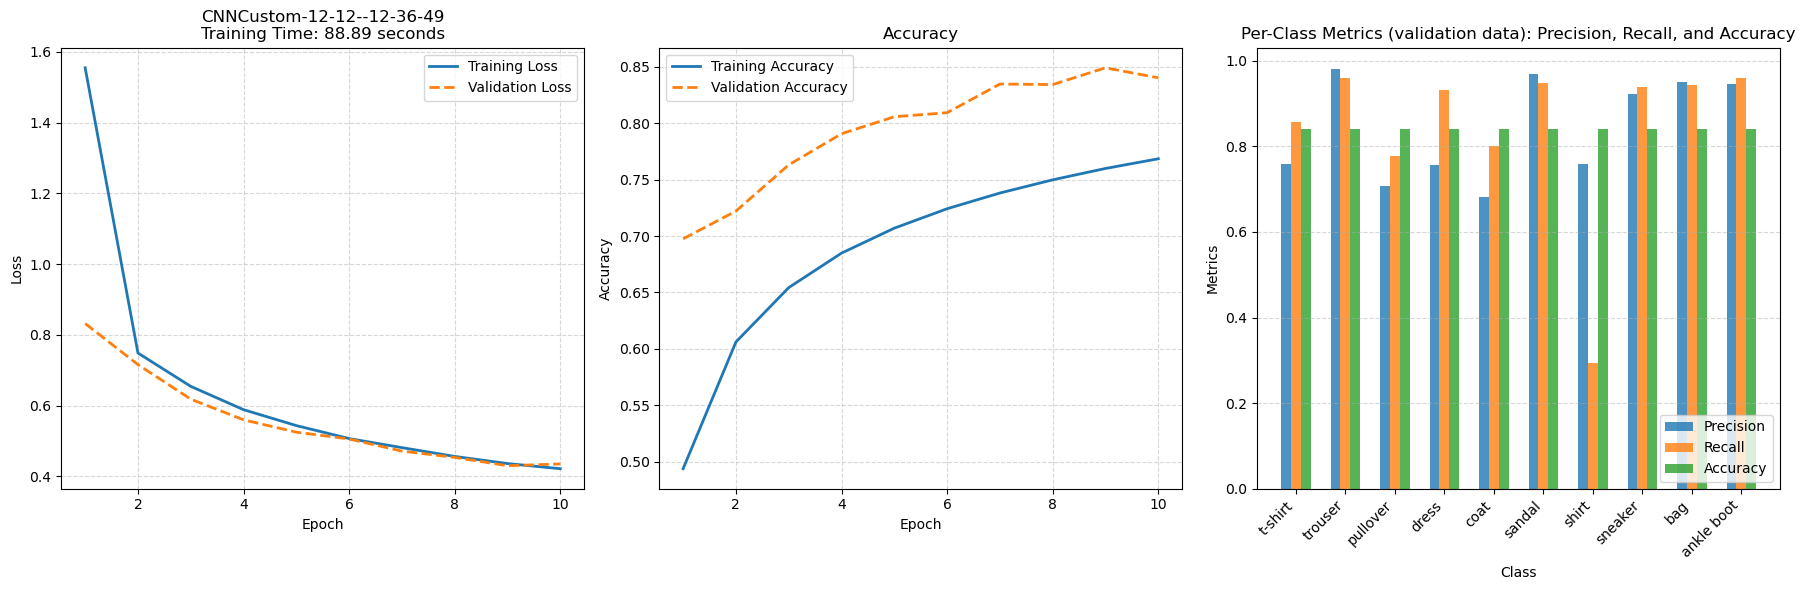

Model saved to: models\CNN_TwoLayers_SmallKernels_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_TwoLayers_SmallKernels_lr0p01_bs128.pkl
Training CNN_TwoLayers_MediumKernels...
[Epoch 1]


100%|██████████| 94/94 [00:01<00:00, 74.52it/s]


[Validation] Epoch 1: acc: 0.7043, val_loss: 0.7989, train_acc: 0.5325
[Epoch 2]


100%|██████████| 94/94 [00:01<00:00, 76.26it/s]


[Validation] Epoch 2: acc: 0.7358, val_loss: 0.6878, train_acc: 0.6258
[Epoch 3]


100%|██████████| 94/94 [00:01<00:00, 76.27it/s]


[Validation] Epoch 3: acc: 0.7397, val_loss: 0.6688, train_acc: 0.6681
[Epoch 4]


100%|██████████| 94/94 [00:01<00:00, 74.32it/s]


[Validation] Epoch 4: acc: 0.7808, val_loss: 0.6037, train_acc: 0.6968
[Epoch 5]


100%|██████████| 94/94 [00:01<00:00, 75.99it/s]


[Validation] Epoch 5: acc: 0.8082, val_loss: 0.5313, train_acc: 0.7178
[Epoch 6]


100%|██████████| 94/94 [00:01<00:00, 77.14it/s]


[Validation] Epoch 6: acc: 0.8231, val_loss: 0.4904, train_acc: 0.7342
[Epoch 7]


100%|██████████| 94/94 [00:01<00:00, 75.81it/s]


[Validation] Epoch 7: acc: 0.8297, val_loss: 0.4735, train_acc: 0.7480
[Epoch 8]


100%|██████████| 94/94 [00:01<00:00, 77.31it/s]


[Validation] Epoch 8: acc: 0.8363, val_loss: 0.4526, train_acc: 0.7593
[Epoch 9]


100%|██████████| 94/94 [00:01<00:00, 73.99it/s]


[Validation] Epoch 9: acc: 0.8399, val_loss: 0.4397, train_acc: 0.7690
[Epoch 10]


100%|██████████| 94/94 [00:01<00:00, 77.73it/s]


[Validation] Epoch 10: acc: 0.8407, val_loss: 0.4365, train_acc: 0.7773


100%|██████████| 79/79 [00:01<00:00, 78.44it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62E3E8EB0>


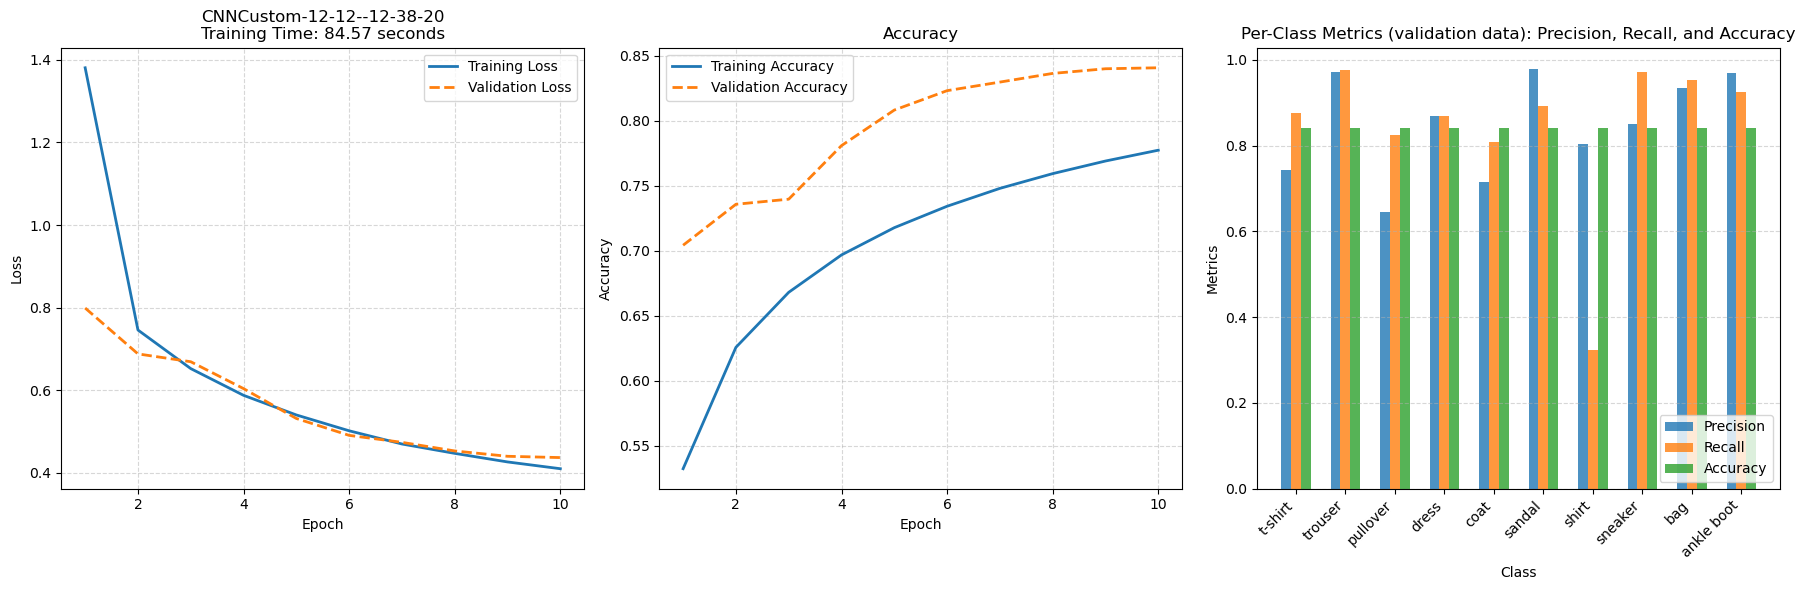

Model saved to: models\CNN_TwoLayers_MediumKernels_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_TwoLayers_MediumKernels_lr0p01_bs128.pkl
Training CNN_TwoLayers_LargeInitial...
[Epoch 1]


100%|██████████| 94/94 [00:01<00:00, 83.06it/s]


[Validation] Epoch 1: acc: 0.6472, val_loss: 0.9402, train_acc: 0.4577
[Epoch 2]


100%|██████████| 94/94 [00:01<00:00, 81.02it/s]


[Validation] Epoch 2: acc: 0.7083, val_loss: 0.7620, train_acc: 0.5800
[Epoch 3]


100%|██████████| 94/94 [00:01<00:00, 82.23it/s]


[Validation] Epoch 3: acc: 0.7581, val_loss: 0.6371, train_acc: 0.6326
[Epoch 4]


100%|██████████| 94/94 [00:01<00:00, 81.89it/s]


[Validation] Epoch 4: acc: 0.7677, val_loss: 0.6188, train_acc: 0.6646
[Epoch 5]


100%|██████████| 94/94 [00:01<00:00, 82.97it/s]


[Validation] Epoch 5: acc: 0.7835, val_loss: 0.5775, train_acc: 0.6868
[Epoch 6]


100%|██████████| 94/94 [00:01<00:00, 81.87it/s]


[Validation] Epoch 6: acc: 0.7975, val_loss: 0.5396, train_acc: 0.7036
[Epoch 7]


100%|██████████| 94/94 [00:01<00:00, 78.76it/s]


[Validation] Epoch 7: acc: 0.8117, val_loss: 0.5308, train_acc: 0.7172
[Epoch 8]


100%|██████████| 94/94 [00:01<00:00, 80.46it/s]


[Validation] Epoch 8: acc: 0.8207, val_loss: 0.4939, train_acc: 0.7287
[Epoch 9]


100%|██████████| 94/94 [00:01<00:00, 78.57it/s]


[Validation] Epoch 9: acc: 0.8107, val_loss: 0.5135, train_acc: 0.7384
[Epoch 10]


100%|██████████| 94/94 [00:01<00:00, 80.29it/s]


[Validation] Epoch 10: acc: 0.8318, val_loss: 0.4664, train_acc: 0.7470


100%|██████████| 79/79 [00:00<00:00, 83.50it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62F21BD90>


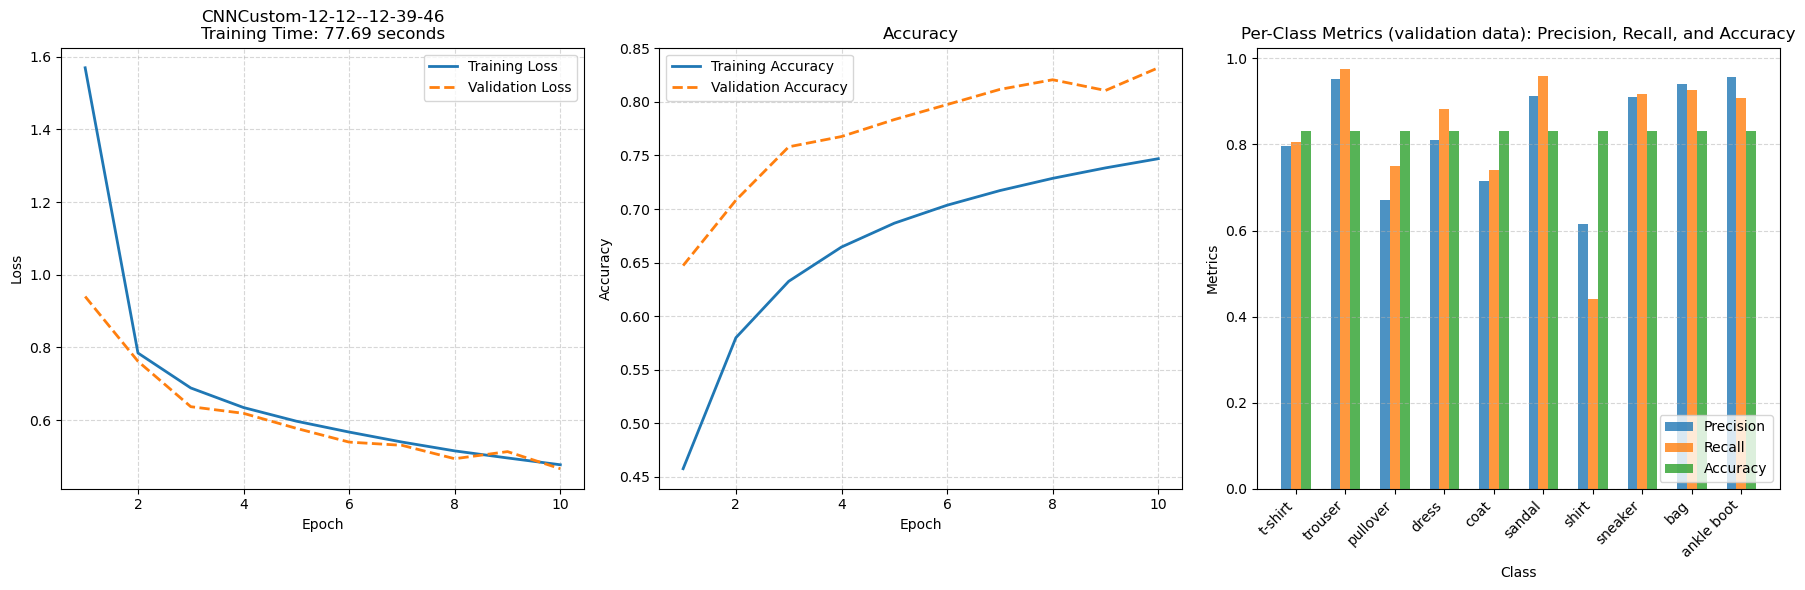

Model saved to: models\CNN_TwoLayers_LargeInitial_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_TwoLayers_LargeInitial_lr0p01_bs128.pkl
Training CNN_ThreeLayers_DecreasingKernels...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 104.80it/s]


[Validation] Epoch 1: acc: 0.6255, val_loss: 0.9779, train_acc: 0.3897
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 104.31it/s]


[Validation] Epoch 2: acc: 0.6833, val_loss: 0.7656, train_acc: 0.5338
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 100.97it/s]


[Validation] Epoch 3: acc: 0.7474, val_loss: 0.6873, train_acc: 0.5967
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 104.43it/s]


[Validation] Epoch 4: acc: 0.7194, val_loss: 0.6653, train_acc: 0.6338
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 104.20it/s]


[Validation] Epoch 5: acc: 0.7738, val_loss: 0.5896, train_acc: 0.6599
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 107.09it/s]


[Validation] Epoch 6: acc: 0.7930, val_loss: 0.5525, train_acc: 0.6793
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 106.30it/s]


[Validation] Epoch 7: acc: 0.7847, val_loss: 0.5703, train_acc: 0.6952
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 110.81it/s]


[Validation] Epoch 8: acc: 0.7890, val_loss: 0.5462, train_acc: 0.7085
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 104.36it/s]


[Validation] Epoch 9: acc: 0.8313, val_loss: 0.4843, train_acc: 0.7199
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 110.20it/s]


[Validation] Epoch 10: acc: 0.8045, val_loss: 0.5176, train_acc: 0.7301


100%|██████████| 79/79 [00:00<00:00, 108.17it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62F357520>


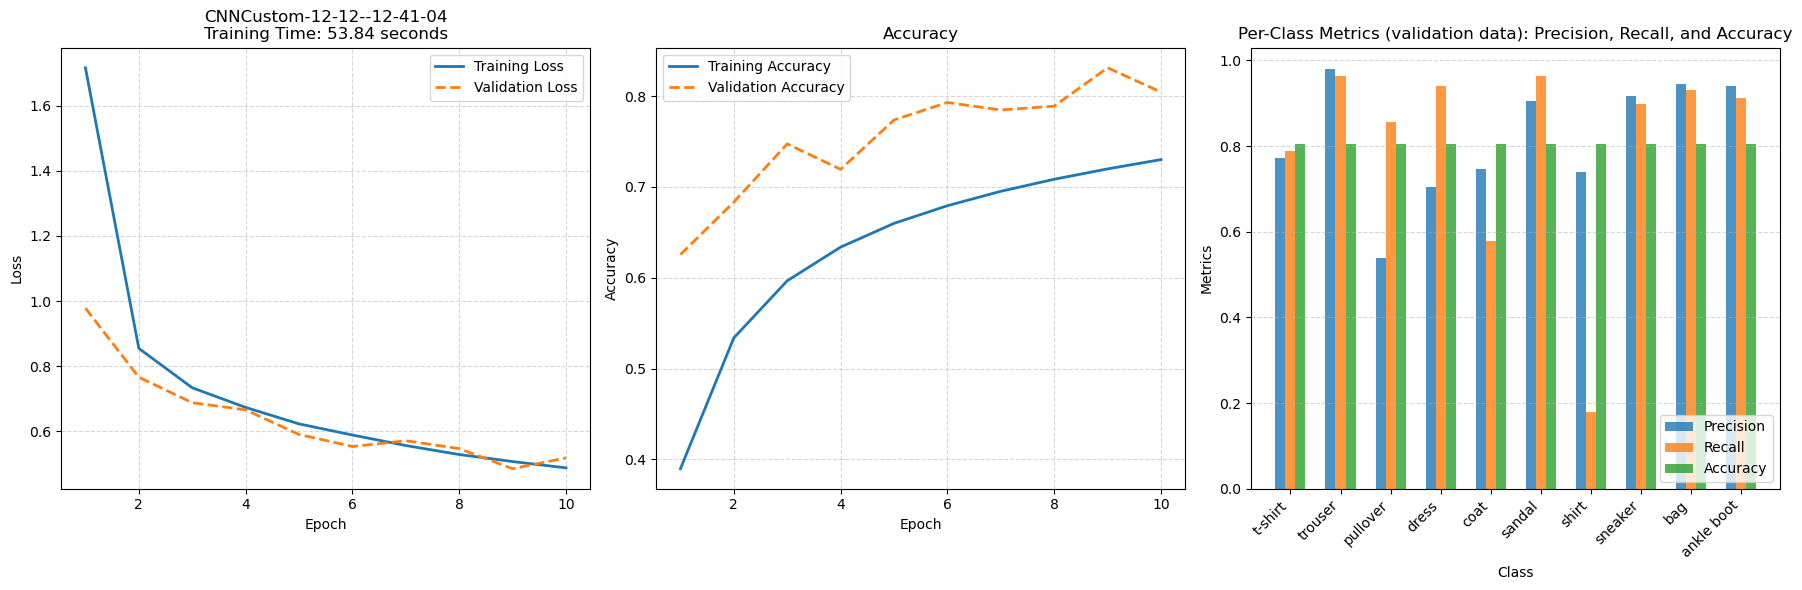

Model saved to: models\CNN_ThreeLayers_DecreasingKernels_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_ThreeLayers_DecreasingKernels_lr0p01_bs128.pkl
Training CNN_ThreeLayers_UniformSmallKernels...
[Epoch 1]


100%|██████████| 94/94 [00:01<00:00, 70.45it/s]


[Validation] Epoch 1: acc: 0.4502, val_loss: 1.4314, train_acc: 0.2526
[Epoch 2]


100%|██████████| 94/94 [00:01<00:00, 73.42it/s]


[Validation] Epoch 2: acc: 0.6837, val_loss: 0.8531, train_acc: 0.4294
[Epoch 3]


100%|██████████| 94/94 [00:01<00:00, 70.14it/s]


[Validation] Epoch 3: acc: 0.7167, val_loss: 0.7585, train_acc: 0.5163
[Epoch 4]


100%|██████████| 94/94 [00:01<00:00, 71.70it/s]


[Validation] Epoch 4: acc: 0.7314, val_loss: 0.7160, train_acc: 0.5673
[Epoch 5]


100%|██████████| 94/94 [00:01<00:00, 72.78it/s]


[Validation] Epoch 5: acc: 0.7617, val_loss: 0.6529, train_acc: 0.6020
[Epoch 6]


100%|██████████| 94/94 [00:01<00:00, 70.27it/s]


[Validation] Epoch 6: acc: 0.7587, val_loss: 0.6383, train_acc: 0.6277
[Epoch 7]


100%|██████████| 94/94 [00:01<00:00, 70.80it/s]


[Validation] Epoch 7: acc: 0.7787, val_loss: 0.6006, train_acc: 0.6478
[Epoch 8]


100%|██████████| 94/94 [00:01<00:00, 61.53it/s]


[Validation] Epoch 8: acc: 0.7602, val_loss: 0.6139, train_acc: 0.6643
[Epoch 9]


100%|██████████| 94/94 [00:01<00:00, 65.88it/s]


[Validation] Epoch 9: acc: 0.7871, val_loss: 0.5821, train_acc: 0.6782
[Epoch 10]


100%|██████████| 94/94 [00:01<00:00, 66.43it/s]


[Validation] Epoch 10: acc: 0.7972, val_loss: 0.5515, train_acc: 0.6899


100%|██████████| 79/79 [00:01<00:00, 68.44it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F63536C730>


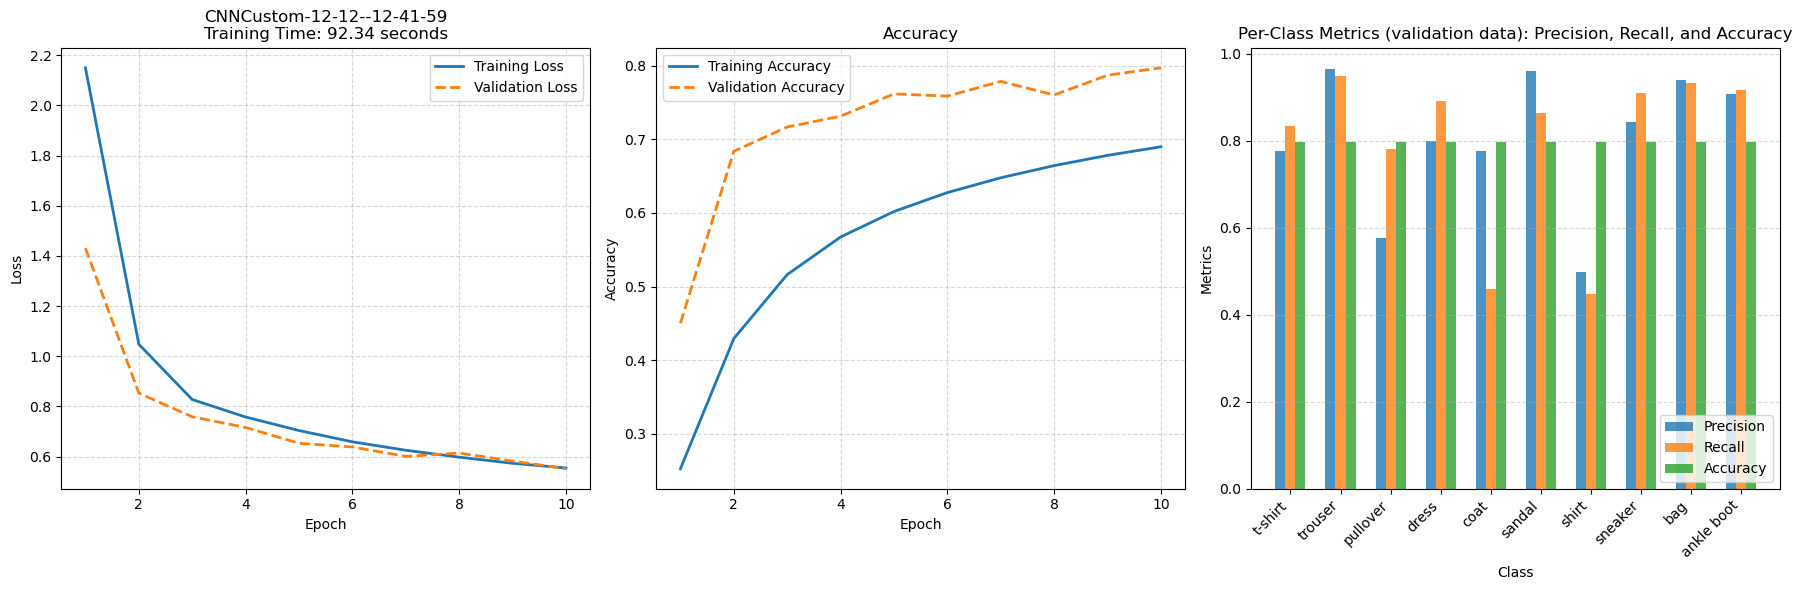

Model saved to: models\CNN_ThreeLayers_UniformSmallKernels_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_ThreeLayers_UniformSmallKernels_lr0p01_bs128.pkl
Training CNN_ThreeLayers_LargeKernels...
[Epoch 1]


100%|██████████| 94/94 [00:01<00:00, 72.33it/s]


[Validation] Epoch 1: acc: 0.3718, val_loss: 2.2223, train_acc: 0.2102
[Epoch 2]


100%|██████████| 94/94 [00:01<00:00, 66.98it/s]


[Validation] Epoch 2: acc: 0.6428, val_loss: 0.9832, train_acc: 0.3585
[Epoch 3]


100%|██████████| 94/94 [00:01<00:00, 73.76it/s]


[Validation] Epoch 3: acc: 0.6901, val_loss: 0.8173, train_acc: 0.4570
[Epoch 4]


100%|██████████| 94/94 [00:01<00:00, 55.48it/s]


[Validation] Epoch 4: acc: 0.7341, val_loss: 0.7343, train_acc: 0.5171
[Epoch 5]


100%|██████████| 94/94 [00:01<00:00, 71.47it/s]


[Validation] Epoch 5: acc: 0.7391, val_loss: 0.7097, train_acc: 0.5582
[Epoch 6]


100%|██████████| 94/94 [00:01<00:00, 74.41it/s]


[Validation] Epoch 6: acc: 0.7428, val_loss: 0.6894, train_acc: 0.5884
[Epoch 7]


100%|██████████| 94/94 [00:01<00:00, 73.22it/s]


[Validation] Epoch 7: acc: 0.7561, val_loss: 0.6626, train_acc: 0.6113
[Epoch 8]


100%|██████████| 94/94 [00:01<00:00, 72.80it/s]


[Validation] Epoch 8: acc: 0.7794, val_loss: 0.6065, train_acc: 0.6300
[Epoch 9]


100%|██████████| 94/94 [00:01<00:00, 67.07it/s]


[Validation] Epoch 9: acc: 0.7632, val_loss: 0.6281, train_acc: 0.6455
[Epoch 10]


100%|██████████| 94/94 [00:01<00:00, 63.40it/s]


[Validation] Epoch 10: acc: 0.7807, val_loss: 0.5842, train_acc: 0.6589


100%|██████████| 79/79 [00:01<00:00, 43.89it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F64346C190>


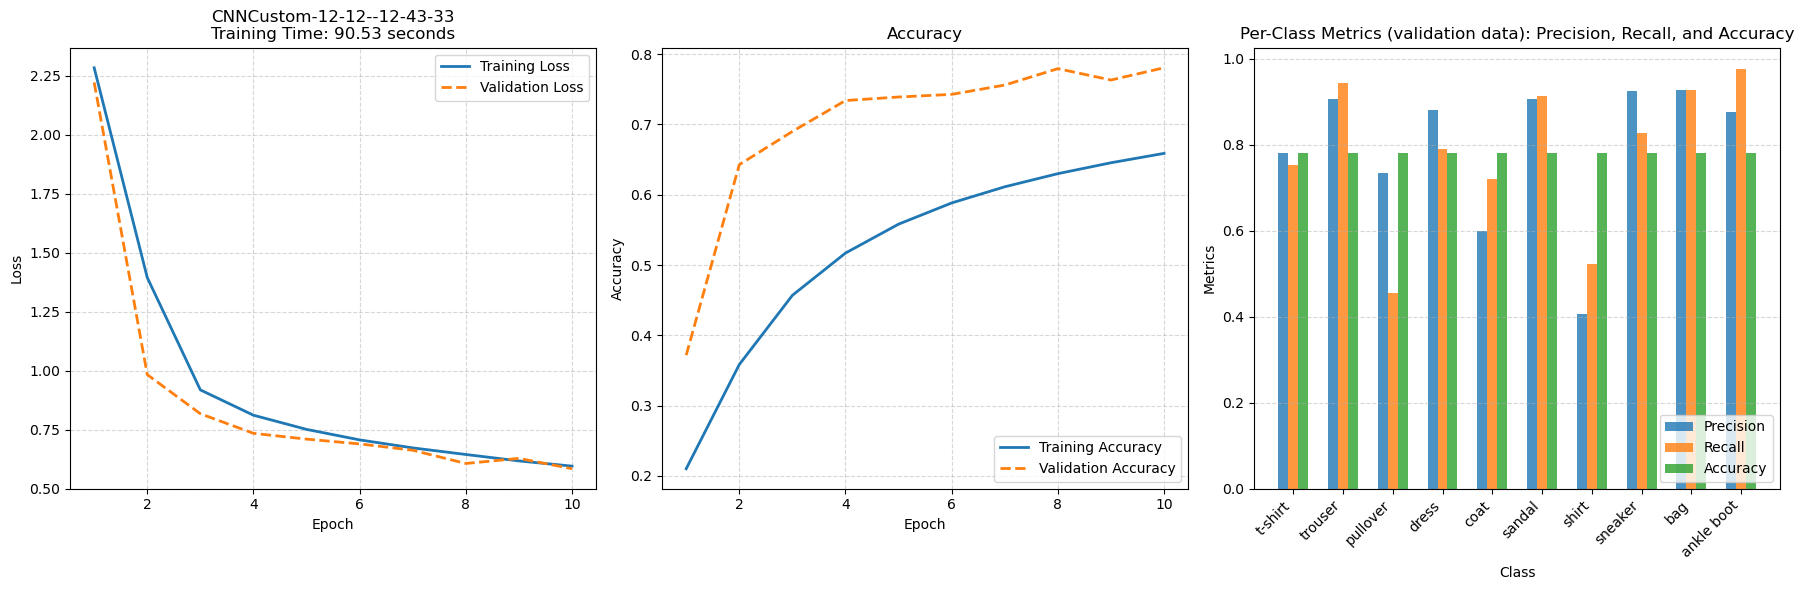

Model saved to: models\CNN_ThreeLayers_LargeKernels_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_ThreeLayers_LargeKernels_lr0p01_bs128.pkl


100%|██████████| 79/79 [00:01<00:00, 70.91it/s]


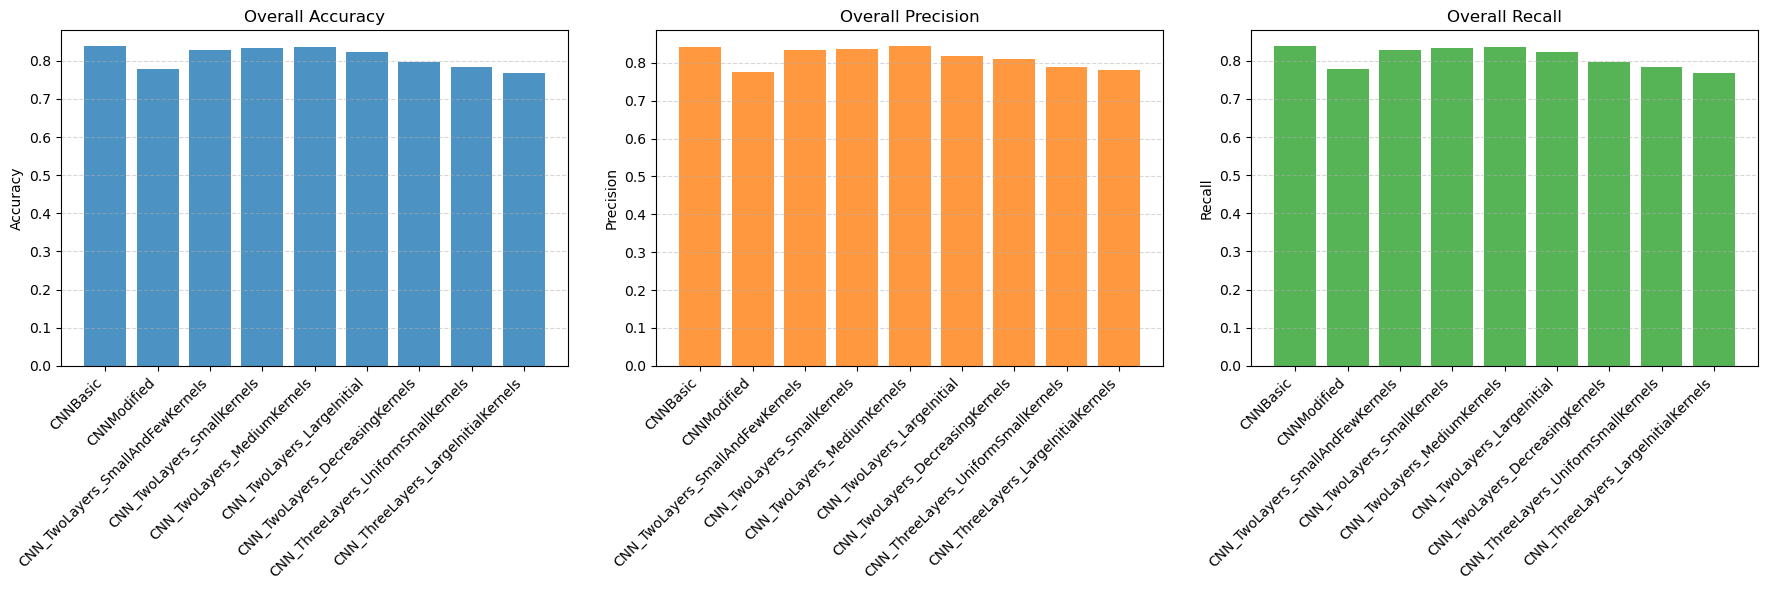

100%|██████████| 79/79 [00:01<00:00, 71.11it/s]


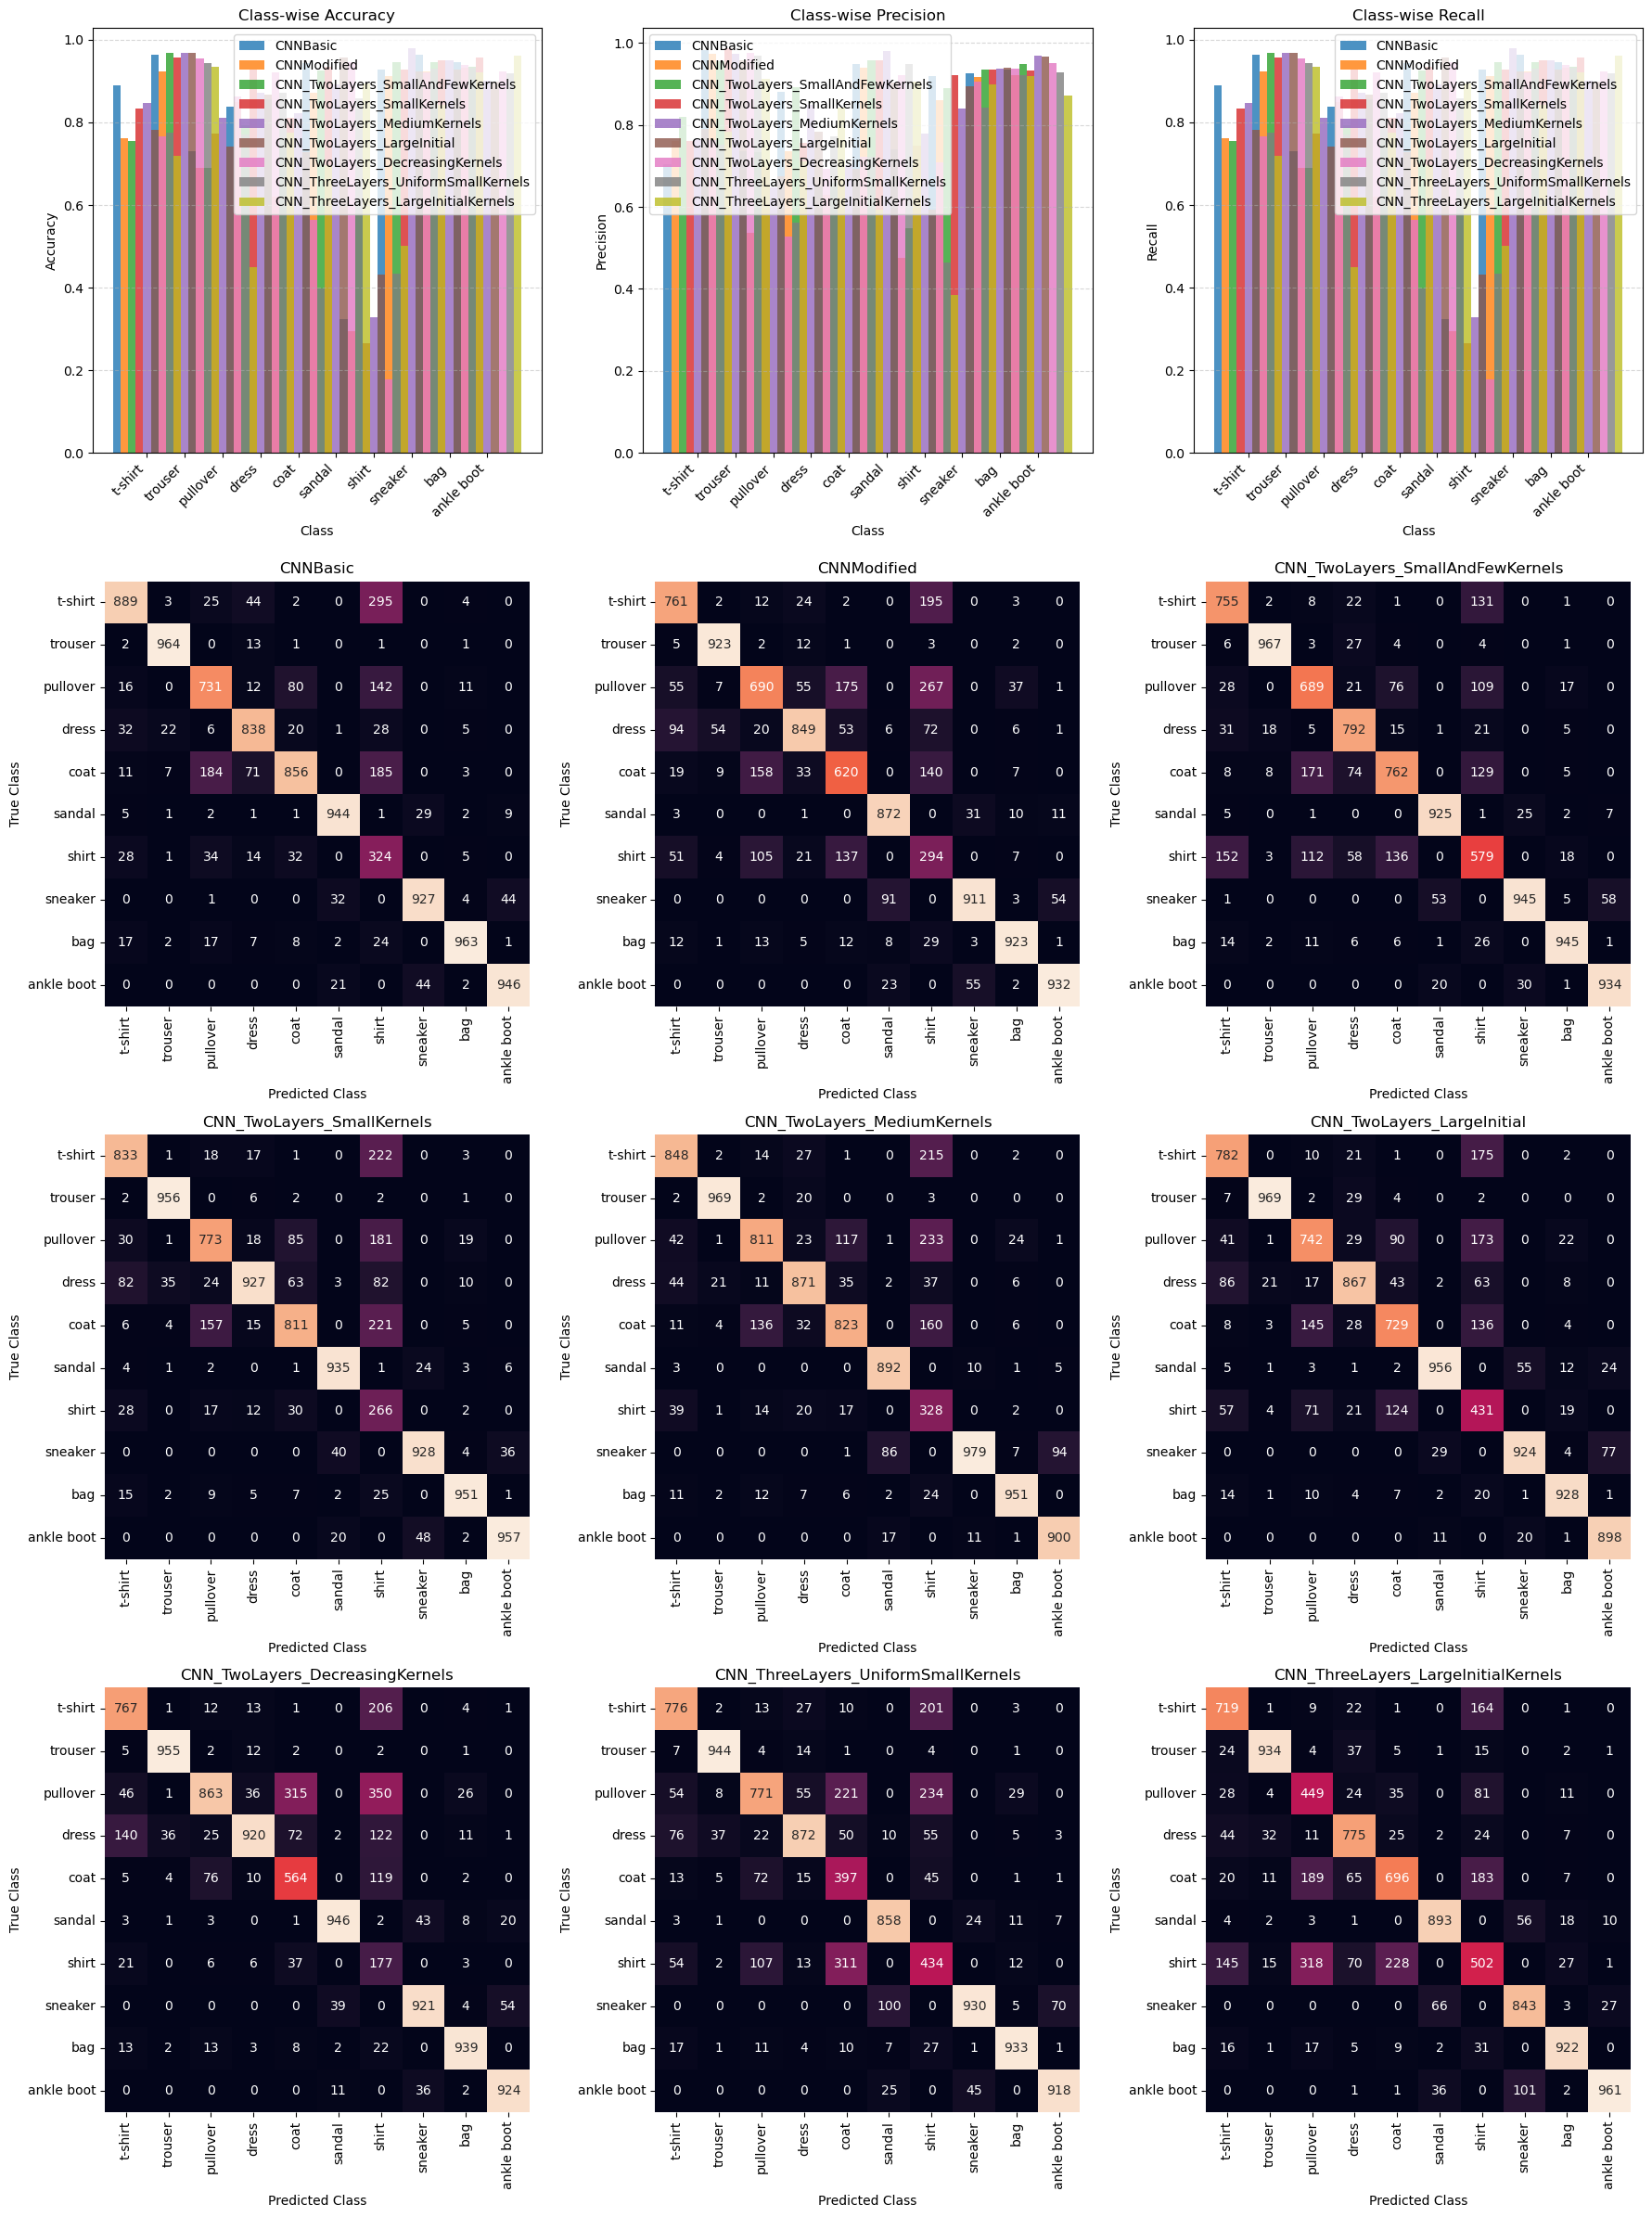

In [16]:
# Two convolutional layers with small kernels and few kernels
trainer_two_layers_Small_And_Few_kernels = train_pytorch_network_cnn(
    conv_layers=[(8, 3), (16, 3)],  # Small kernel sizes
    fully_connected_hidden_layers=[256, 10],            # Fully connected layers
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_TwoLayers_SmallAndFewKernels"
)

# Two convolutional layers with small kernels
trainer_two_layers_Small_kernels = train_pytorch_network_cnn(
    conv_layers=[(32, 3), (64, 3)],  # Small kernel sizes
    fully_connected_hidden_layers=[256, 10],            # Fully connected layers
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_TwoLayers_SmallKernels"
)

# Two convolutional layers with medium kernels
trainer_two_layers_medium_kernels = train_pytorch_network_cnn(
    conv_layers=[(32, 5), (64, 5)],  # Medium kernel sizes
    fully_connected_hidden_layers=[256, 10],            # Fully connected layers
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_TwoLayers_MediumKernels"
)

# Two convolutional layers with larger initial kernel
trainer_two_layers_large_initial = train_pytorch_network_cnn(
    conv_layers=[(32, 7), (64, 5)],  # Larger kernel in the first layer
    fully_connected_hidden_layers=[256, 10],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_TwoLayers_LargeInitial"
)


# Three convolutional layers with decreasing kernel sizes
trainer_two_layers_decreasing_kernels = train_pytorch_network_cnn(
    conv_layers=[(16, 7), (32, 3)],  # Larger initial kernel decreasing in later layers
    fully_connected_hidden_layers=[256, 10],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_ThreeLayers_DecreasingKernels"
)


# Three convolutional layers with uniform small kernels
trainer_three_layers_uniform_small_kernels = train_pytorch_network_cnn(
    conv_layers=[(32, 3), (64, 3), (128, 3)],  # Uniform small kernels
    fully_connected_hidden_layers=[256, 10],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_ThreeLayers_UniformSmallKernels"
)

# Three convolutional layers with larger kernels
trainer_three_layers_large_kernels = train_pytorch_network_cnn(
    conv_layers=[(32, 5), (64, 3), (128, 3)],  # Large kernels in all layers
    fully_connected_hidden_layers=[512, 256, 10],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_ThreeLayers_LargeKernels"
)

# Load trained models
CNNKernelExperiments = {
    'CNNBasic': PyTorchTrainer.load(file_cnn_basic),
    'CNNModified': PyTorchTrainer.load(trainer_task_16),
    'CNN_TwoLayers_SmallAndFewKernels': PyTorchTrainer.load(trainer_two_layers_Small_And_Few_kernels),
    'CNN_TwoLayers_SmallKernels': PyTorchTrainer.load(trainer_two_layers_Small_kernels),
    'CNN_TwoLayers_MediumKernels': PyTorchTrainer.load(trainer_two_layers_medium_kernels),
    'CNN_TwoLayers_LargeInitial': PyTorchTrainer.load(trainer_two_layers_large_initial),
    'CNN_TwoLayers_DecreasingKernels': PyTorchTrainer.load(trainer_two_layers_decreasing_kernels),
    'CNN_ThreeLayers_UniformSmallKernels': PyTorchTrainer.load(trainer_three_layers_uniform_small_kernels),
    'CNN_ThreeLayers_LargeInitialKernels': PyTorchTrainer.load(trainer_three_layers_large_kernels)
}

# Compare overall metrics
evaluate_overall_metrics(CNNKernelExperiments)

# Compare class-wise metrics
evaluate(CNNKernelExperiments)


## Task 18 reflections

**Previous best CNN_Basic**
In short: X layers, with bla bla
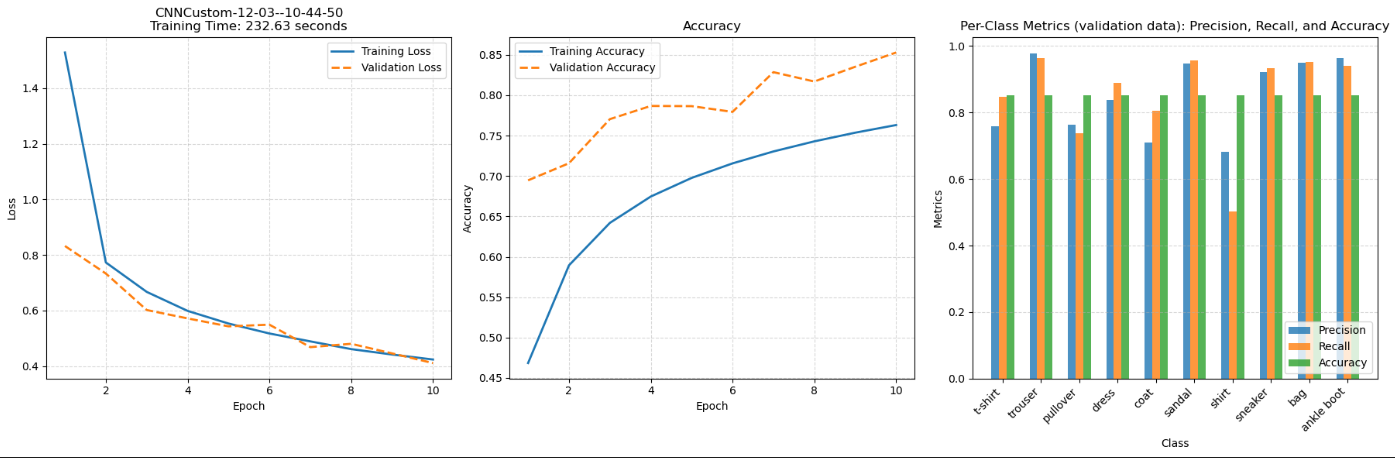

**Previous best CNN_Modified**
In short: X layers, with bla bla
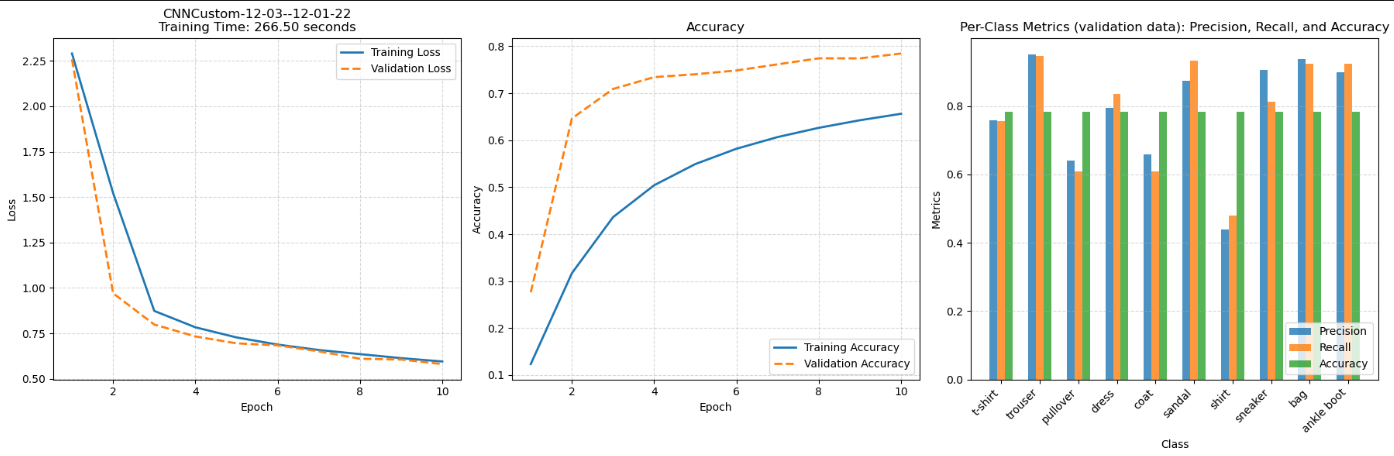

**Best customized CNN**
In short: X layers, with bla bla
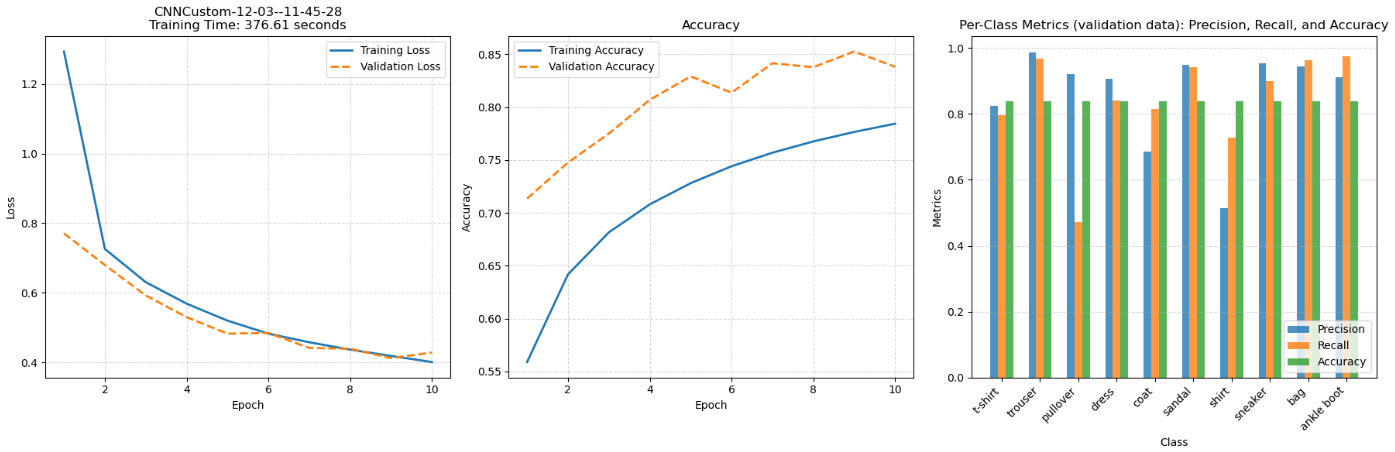


### Extra observations
**Why increasing kernel numbers:** Starts with few core features (edges, curves, texture), and uses those to make more combined features (chin, ear, etc.), and in the end has many kernels to represent high-level features (face, chest, arm) 

# Exam code

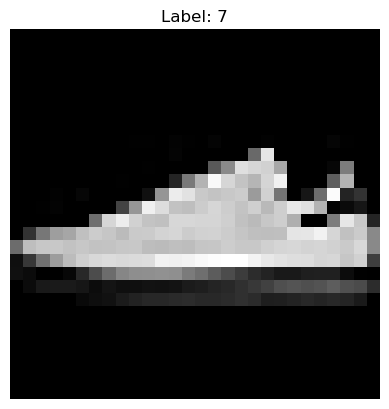

Training CNN_visualized...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 127.87it/s]


[Validation] Epoch 1: acc: 0.6242, val_loss: 1.0091, train_acc: 0.3228
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 119.18it/s]


[Validation] Epoch 2: acc: 0.7308, val_loss: 0.7394, train_acc: 0.5024
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 121.49it/s]


[Validation] Epoch 3: acc: 0.7420, val_loss: 0.6904, train_acc: 0.5757
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 115.81it/s]


[Validation] Epoch 4: acc: 0.7613, val_loss: 0.6372, train_acc: 0.6178
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 118.84it/s]


[Validation] Epoch 5: acc: 0.7732, val_loss: 0.5974, train_acc: 0.6464
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 113.64it/s]


[Validation] Epoch 6: acc: 0.7930, val_loss: 0.5514, train_acc: 0.6688
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 113.64it/s]


[Validation] Epoch 7: acc: 0.8093, val_loss: 0.5172, train_acc: 0.6865
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 114.74it/s]


[Validation] Epoch 8: acc: 0.8124, val_loss: 0.5091, train_acc: 0.7012
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 116.95it/s]


[Validation] Epoch 9: acc: 0.8191, val_loss: 0.4836, train_acc: 0.7134
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 112.09it/s]


[Validation] Epoch 10: acc: 0.8217, val_loss: 0.4757, train_acc: 0.7240


100%|██████████| 79/79 [00:00<00:00, 117.18it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F6418E2D70>


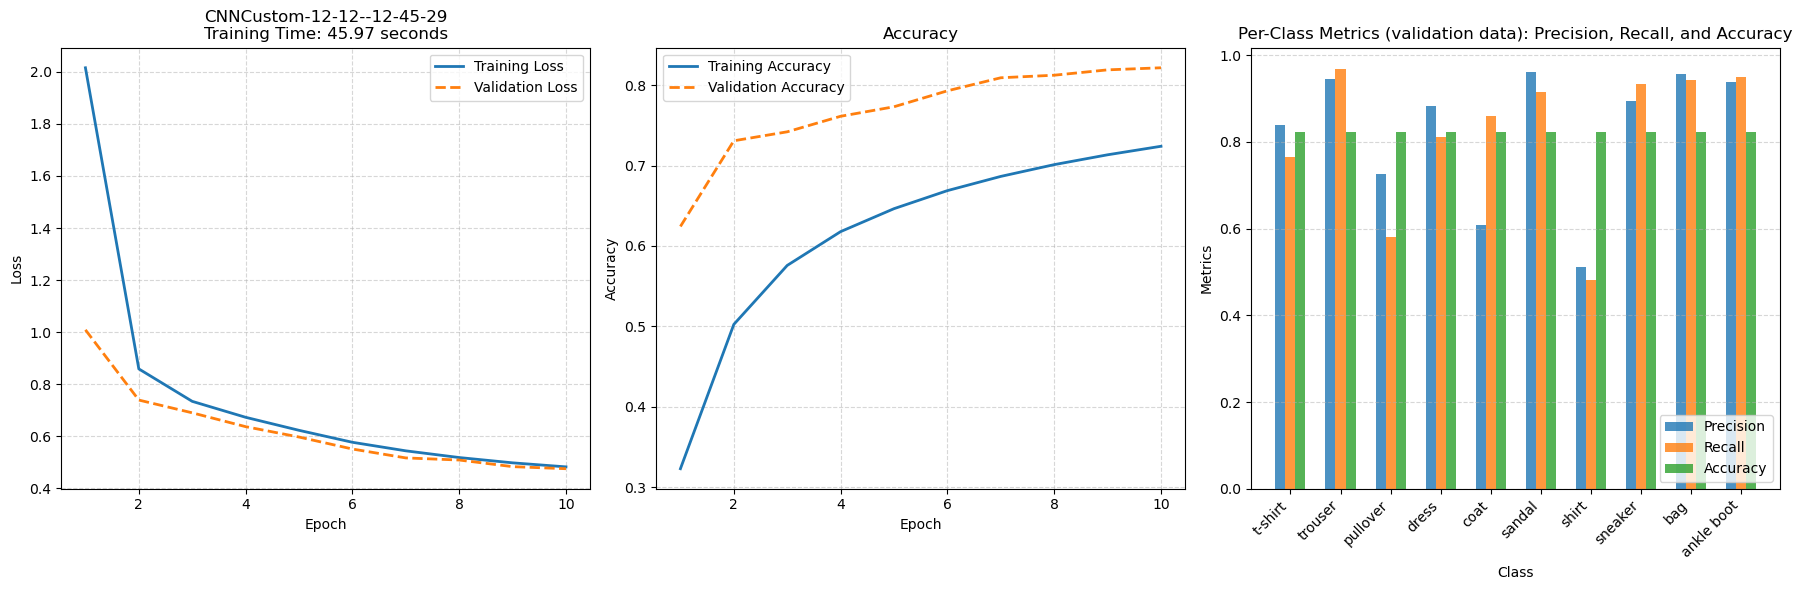

Model saved to: models\CNN_visualized_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_visualized_lr0p01_bs128.pkl
Training CNN_With_dropout...
[Epoch 1]


100%|██████████| 94/94 [00:01<00:00, 71.67it/s]


[Validation] Epoch 1: acc: 0.7101, val_loss: 0.7606, train_acc: 0.5301
[Epoch 2]


100%|██████████| 94/94 [00:01<00:00, 71.71it/s]


[Validation] Epoch 2: acc: 0.7637, val_loss: 0.6372, train_acc: 0.6294
[Epoch 3]


100%|██████████| 94/94 [00:01<00:00, 63.14it/s]


[Validation] Epoch 3: acc: 0.7837, val_loss: 0.5825, train_acc: 0.6744
[Epoch 4]


100%|██████████| 94/94 [00:01<00:00, 73.66it/s]


[Validation] Epoch 4: acc: 0.8078, val_loss: 0.5287, train_acc: 0.7032
[Epoch 5]


100%|██████████| 94/94 [00:01<00:00, 73.43it/s]


[Validation] Epoch 5: acc: 0.8132, val_loss: 0.4931, train_acc: 0.7242
[Epoch 6]


100%|██████████| 94/94 [00:01<00:00, 72.12it/s]


[Validation] Epoch 6: acc: 0.8247, val_loss: 0.4660, train_acc: 0.7403
[Epoch 7]


100%|██████████| 94/94 [00:01<00:00, 71.96it/s]


[Validation] Epoch 7: acc: 0.8303, val_loss: 0.4480, train_acc: 0.7536
[Epoch 8]


100%|██████████| 94/94 [00:01<00:00, 65.75it/s]


[Validation] Epoch 8: acc: 0.8515, val_loss: 0.4173, train_acc: 0.7650
[Epoch 9]


100%|██████████| 94/94 [00:01<00:00, 66.81it/s]


[Validation] Epoch 9: acc: 0.8498, val_loss: 0.4193, train_acc: 0.7744
[Epoch 10]


100%|██████████| 94/94 [00:01<00:00, 75.34it/s]


[Validation] Epoch 10: acc: 0.8552, val_loss: 0.4014, train_acc: 0.7826


100%|██████████| 79/79 [00:01<00:00, 74.51it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62D7DF850>


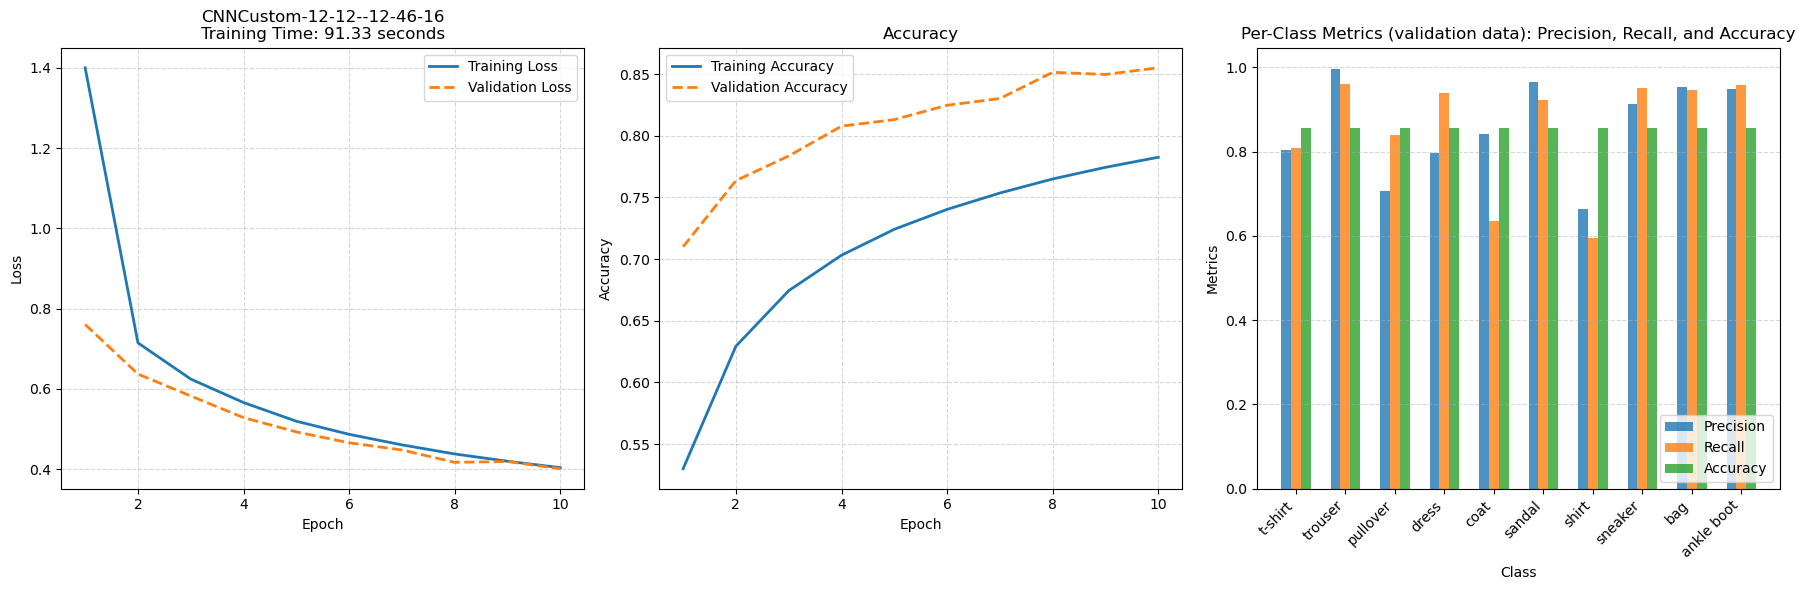

Model saved to: models\CNN_With_dropout_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/CNN_With_dropout_lr0p01_bs128.pkl
Training MLP_With_dropout...
[Epoch 1]


100%|██████████| 94/94 [00:00<00:00, 134.00it/s]


[Validation] Epoch 1: acc: 0.6832, val_loss: 0.8761, train_acc: 0.5223
[Epoch 2]


100%|██████████| 94/94 [00:00<00:00, 141.57it/s]


[Validation] Epoch 2: acc: 0.7632, val_loss: 0.6733, train_acc: 0.6235
[Epoch 3]


100%|██████████| 94/94 [00:00<00:00, 124.49it/s]


[Validation] Epoch 3: acc: 0.7983, val_loss: 0.5823, train_acc: 0.6748
[Epoch 4]


100%|██████████| 94/94 [00:00<00:00, 95.23it/s] 


[Validation] Epoch 4: acc: 0.8163, val_loss: 0.5316, train_acc: 0.7074
[Epoch 5]


100%|██████████| 94/94 [00:00<00:00, 119.68it/s]


[Validation] Epoch 5: acc: 0.8236, val_loss: 0.5007, train_acc: 0.7297
[Epoch 6]


100%|██████████| 94/94 [00:00<00:00, 126.09it/s]


[Validation] Epoch 6: acc: 0.8307, val_loss: 0.4843, train_acc: 0.7461
[Epoch 7]


100%|██████████| 94/94 [00:00<00:00, 123.17it/s]


[Validation] Epoch 7: acc: 0.8385, val_loss: 0.4647, train_acc: 0.7586
[Epoch 8]


100%|██████████| 94/94 [00:00<00:00, 115.34it/s]


[Validation] Epoch 8: acc: 0.8415, val_loss: 0.4532, train_acc: 0.7687
[Epoch 9]


100%|██████████| 94/94 [00:00<00:00, 131.47it/s]


[Validation] Epoch 9: acc: 0.8376, val_loss: 0.4601, train_acc: 0.7769
[Epoch 10]


100%|██████████| 94/94 [00:00<00:00, 129.72it/s]


[Validation] Epoch 10: acc: 0.8448, val_loss: 0.4351, train_acc: 0.7837


100%|██████████| 79/79 [00:00<00:00, 133.90it/s]


Evaluation completed. Logger: <metrics.MetricLogger object at 0x000001F62F376F20>


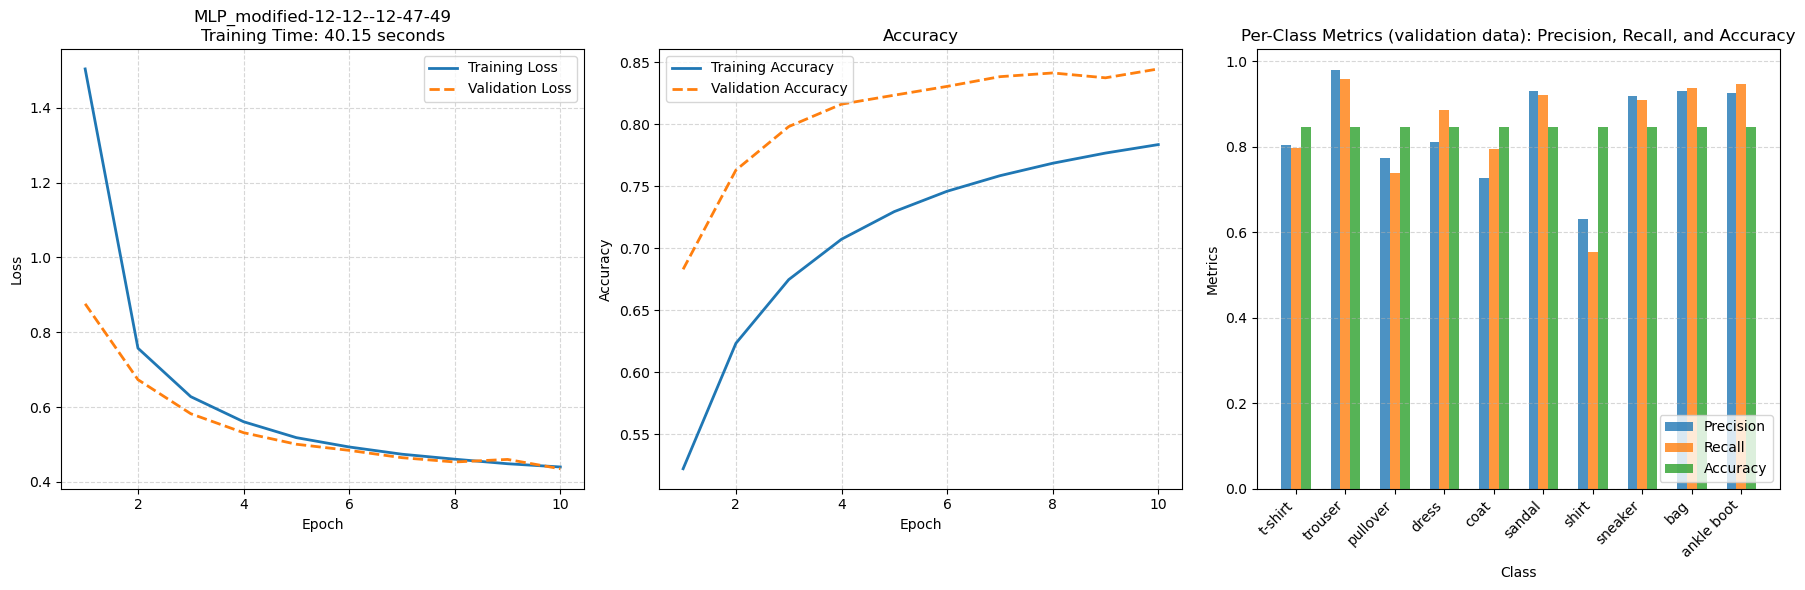

Model saved to: models\MLP_With_dropout_lr0p01_bs128.pkl
Training and evaluation completed. Model saved at: models/MLP_With_dropout_lr0p01_bs128.pkl


100%|██████████| 79/79 [00:00<00:00, 134.35it/s]


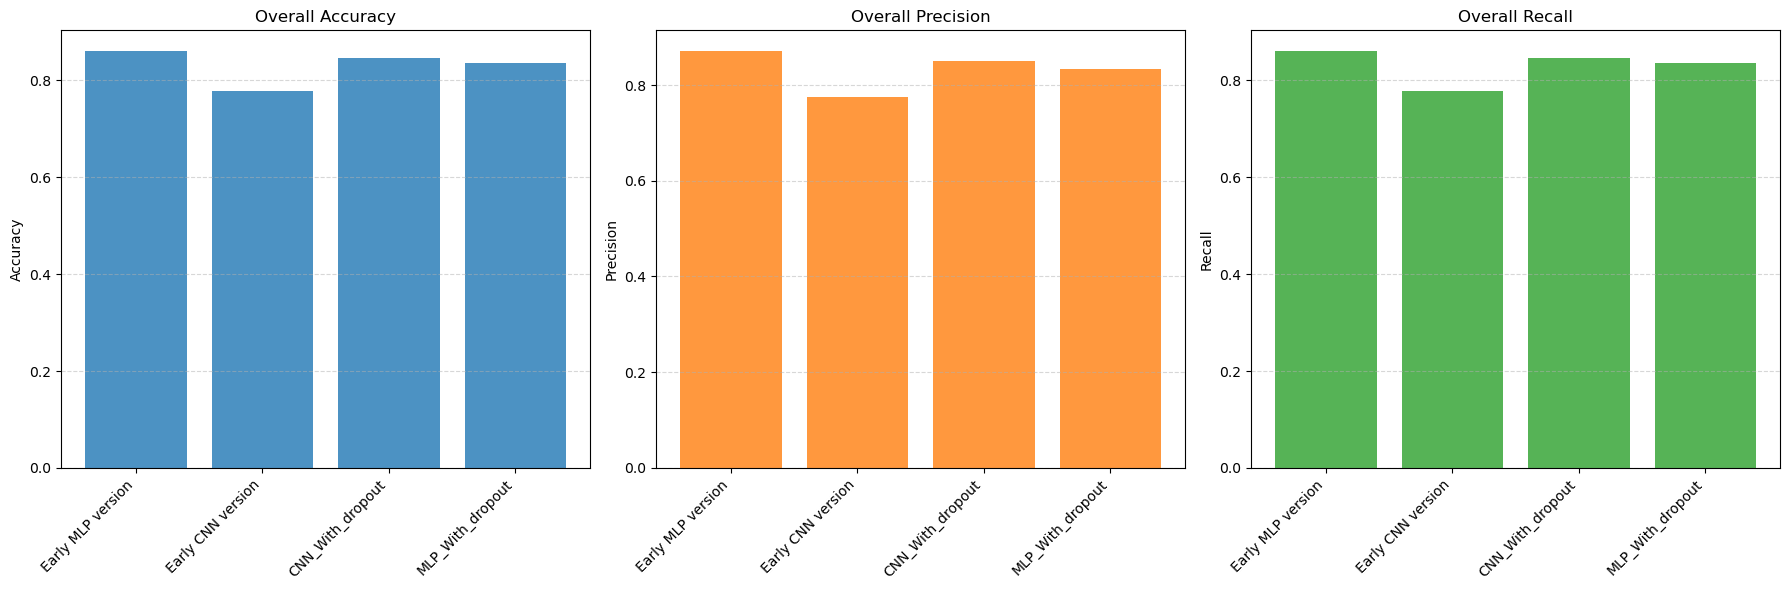

100%|██████████| 79/79 [00:00<00:00, 123.81it/s]


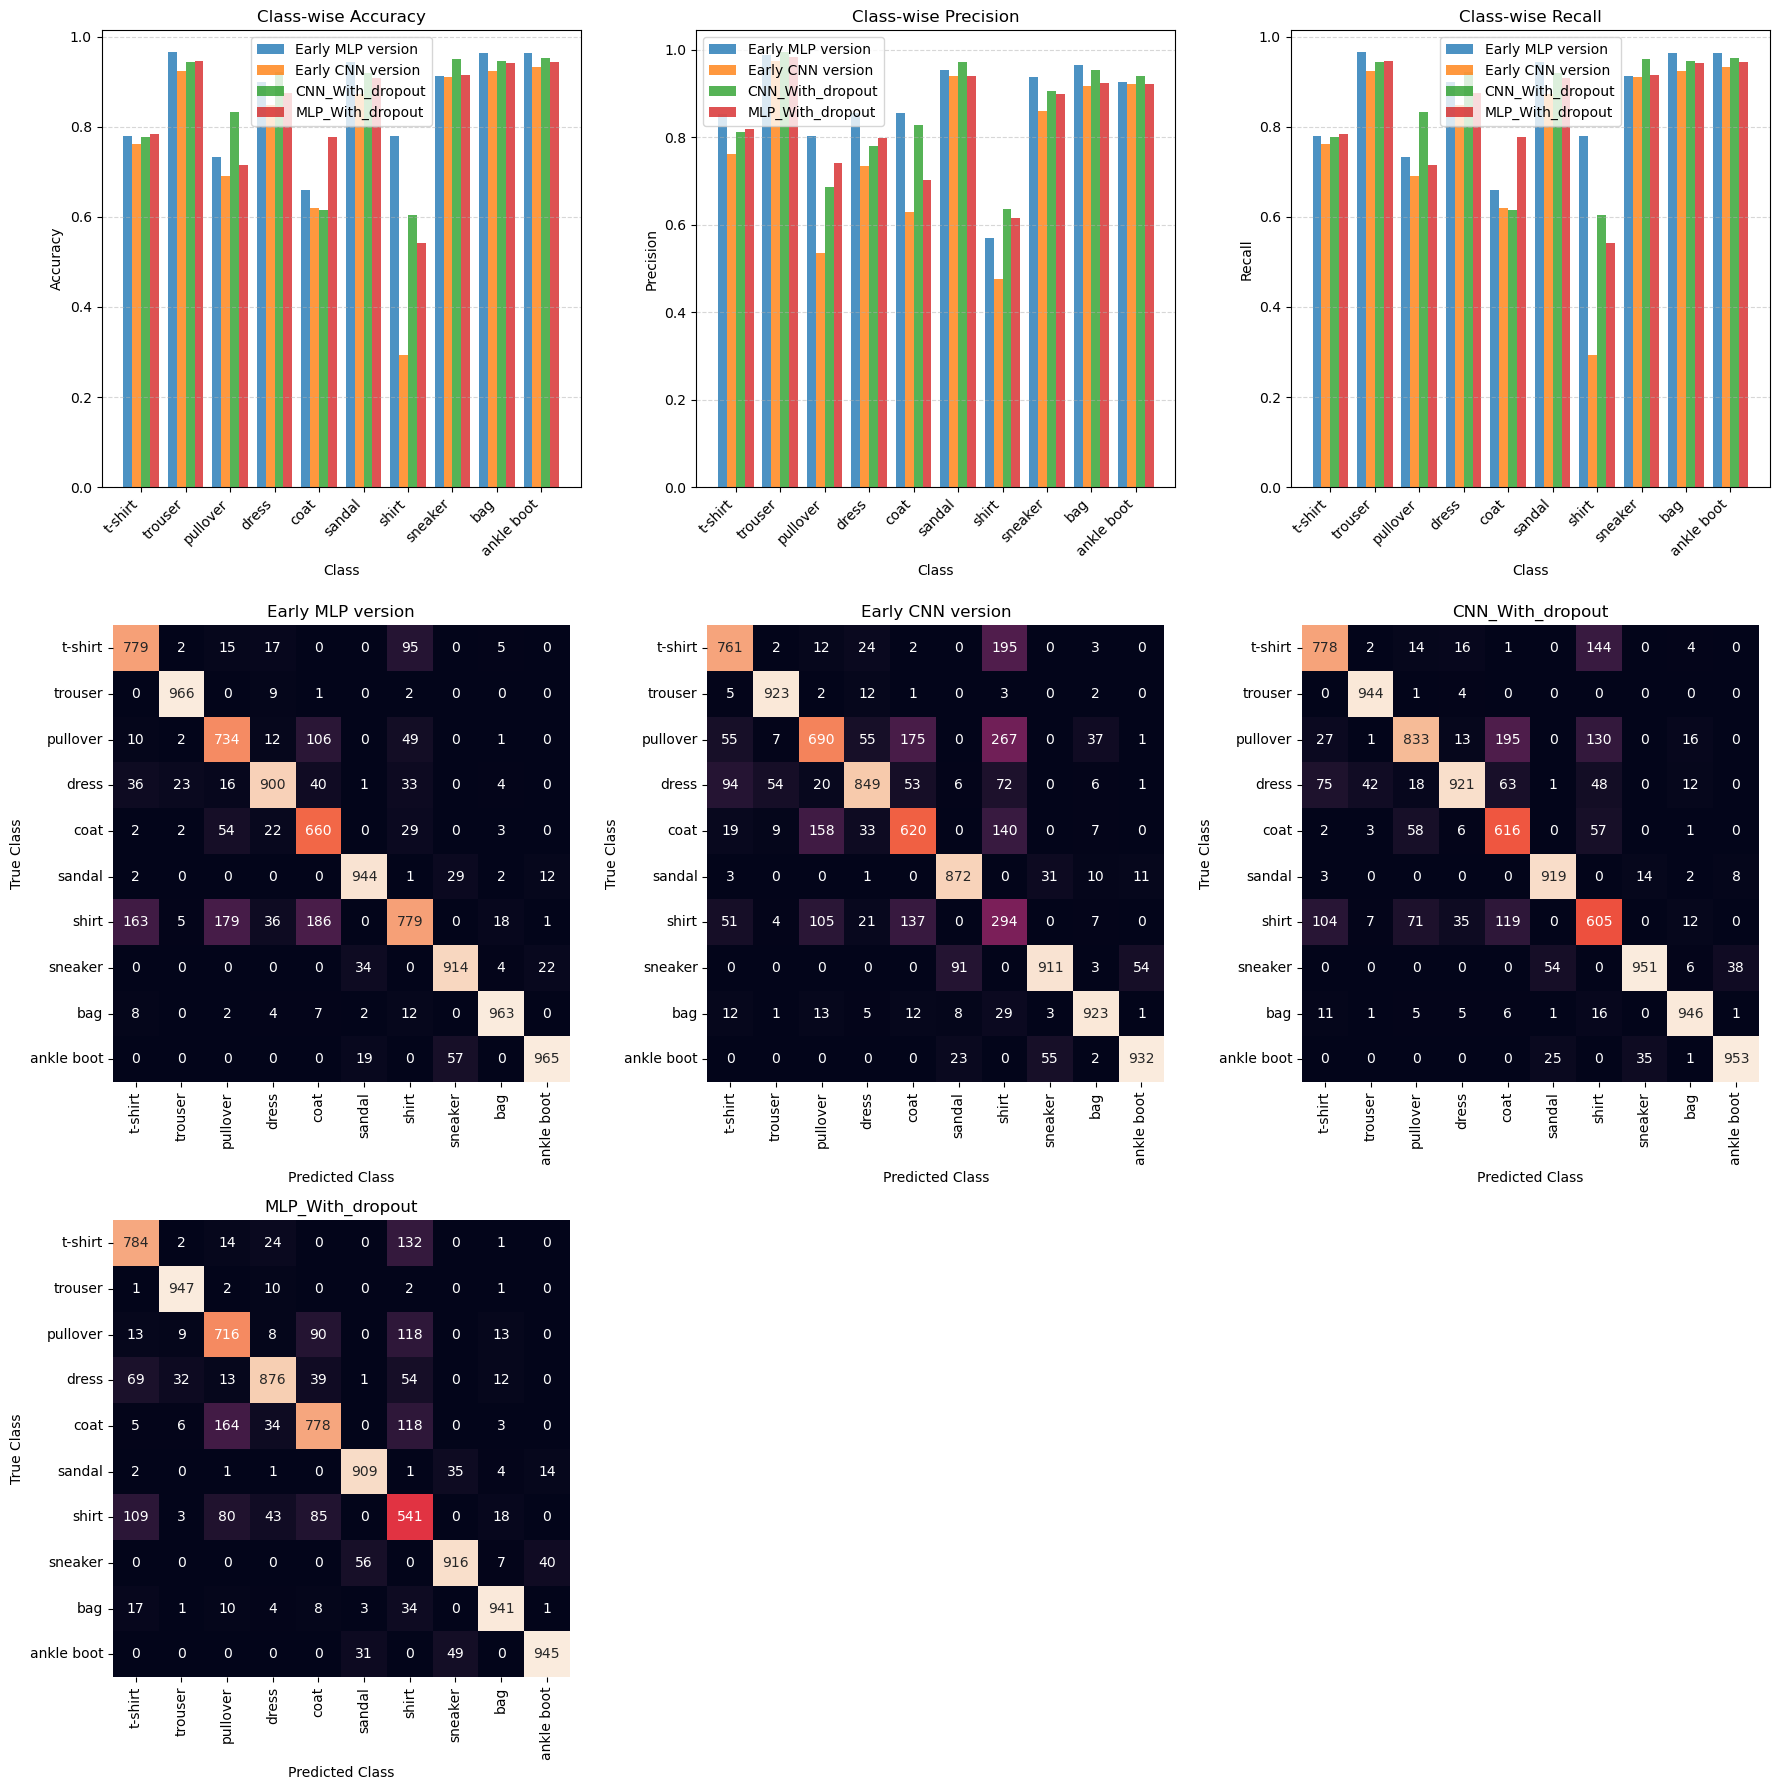

In [17]:
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor


#---THIS IS TO VISUALIZE THE INPUT FOR THIS EXERCISE---
mnist_train = FashionMNIST(root='.', train=True, download=True, transform=ToTensor())
first_image, first_label = mnist_train[6]
plt.imshow(first_image.squeeze(), cmap='gray')
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()

#---THIS NETWORK IS VISUALIZED IN THE IMAGE BELOW.---
cnn_visualized = train_pytorch_network_cnn(
    conv_layers=[(4, 3), (8, 3)], #2 convolution layers. 4 kernels of size 3x3, 8 kernels of size 3x3
    fully_connected_hidden_layers=[128, 10], # 2 layers. 128 nodes in the hidden layer, 10 nodes in the output layer
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_visualized"
)

#----THIS IS TO PLAY WITH ALL THE HYPERPARAMETERS IN THE EXERCISE---

# Additional Hyperparameter options, compared to earlier exercises.
ACTIVATION_FUNCTIONS = ['relu', 'leaky_relu', 'elu', 'gelu', 'tanh', 'sigmoid']
DROPOUT_RATES = [0.0, 0.1, 0.25, 0.5]
EARLY_STOPPING = [True, False,] # FOR EARLY STOPPING SEE trainer.train_es() in trainers.py

# CNN 2 convolution layers
CNN_more_hyperparameters = train_pytorch_network_cnn(
    conv_layers=[(32, 5), (64, 5)],
    fully_connected_hidden_layers=[256, 10],
    activation_fn='relu',
    learning_rate=1e-2,
    batch_size=128,
    epochs=10,
    model_name="CNN_With_dropout",
    dropout=0.1
)

# MLP 2 hidden layers
MLP_More_hyperparameters = train_pytorch_network_mlp(
    hidden_layers=[100, 256],
    activation_fn='relu',         
    learning_rate=1e-2,           
    batch_size=128,               
    epochs=10,                    
    model_name="MLP_With_dropout",
    dropout=0.1
)

# Load the trained models into a dictionary
CNNImproved_model = {
    'Early MLP version': PyTorchTrainer.load(file_lr_1e1_bs_128),
    'Early CNN version': PyTorchTrainer.load(trainer_task_16),
    'CNN_With_dropout': PyTorchTrainer.load(CNN_more_hyperparameters),                       # Improved CNN model
    'MLP_With_dropout': PyTorchTrainer.load(MLP_More_hyperparameters)                        # Improved MLP model
}

# Compare overall metrics
evaluate_overall_metrics(CNNImproved_model)

# Compare class-wise metrics
evaluate(CNNImproved_model)


# EXAM


## D: Difference between MLP and CNN

**For MLP see W13/07-nn-gaze**

**CNN:**

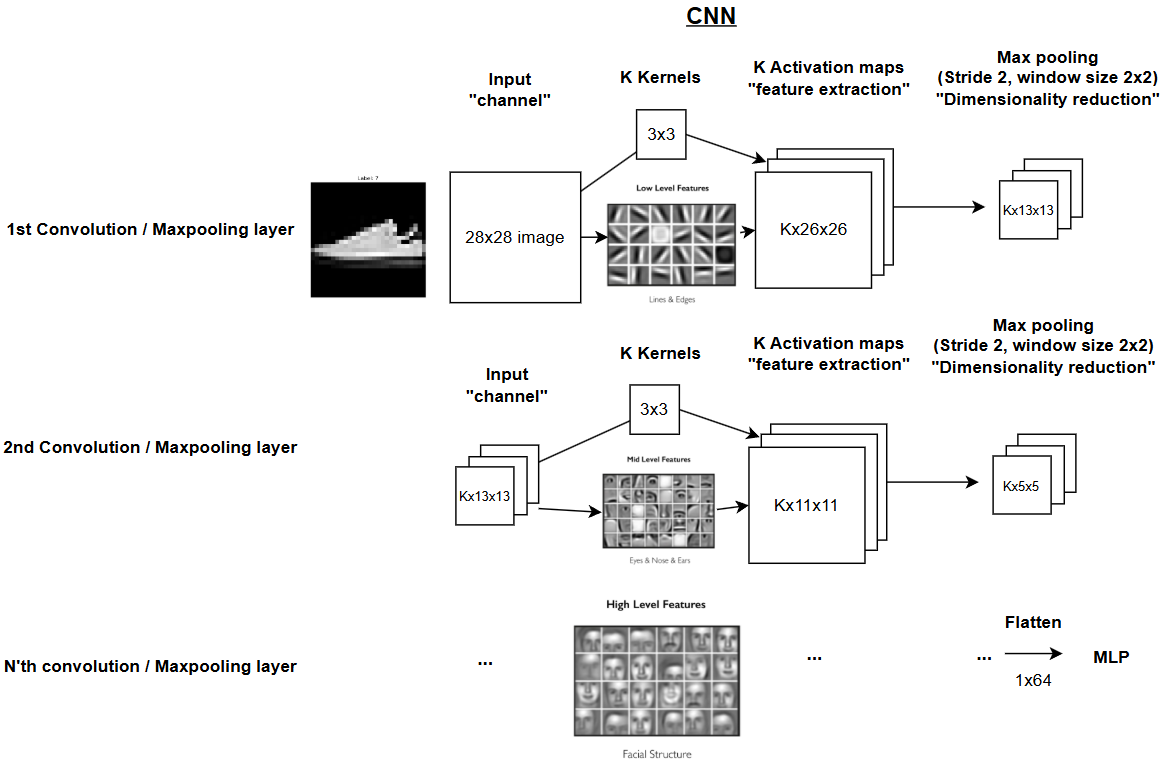

**Number of kernels**: Number of unique features per layer - Often increasing in layers.

**Size of kernel**: Captures broadness of features.
* 3x3: Small local features, edges and texture
* 7x7: Patterns that cover larger area, such as a mountain.

## E: Loss functions, regularization, data augmentation, model complexity, cross-validation

### Loss functions

#### Regression

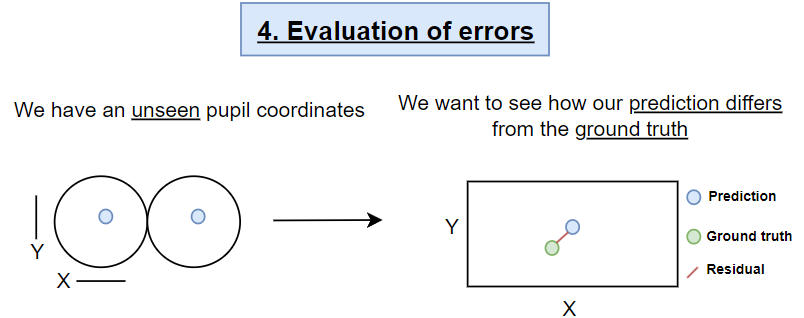

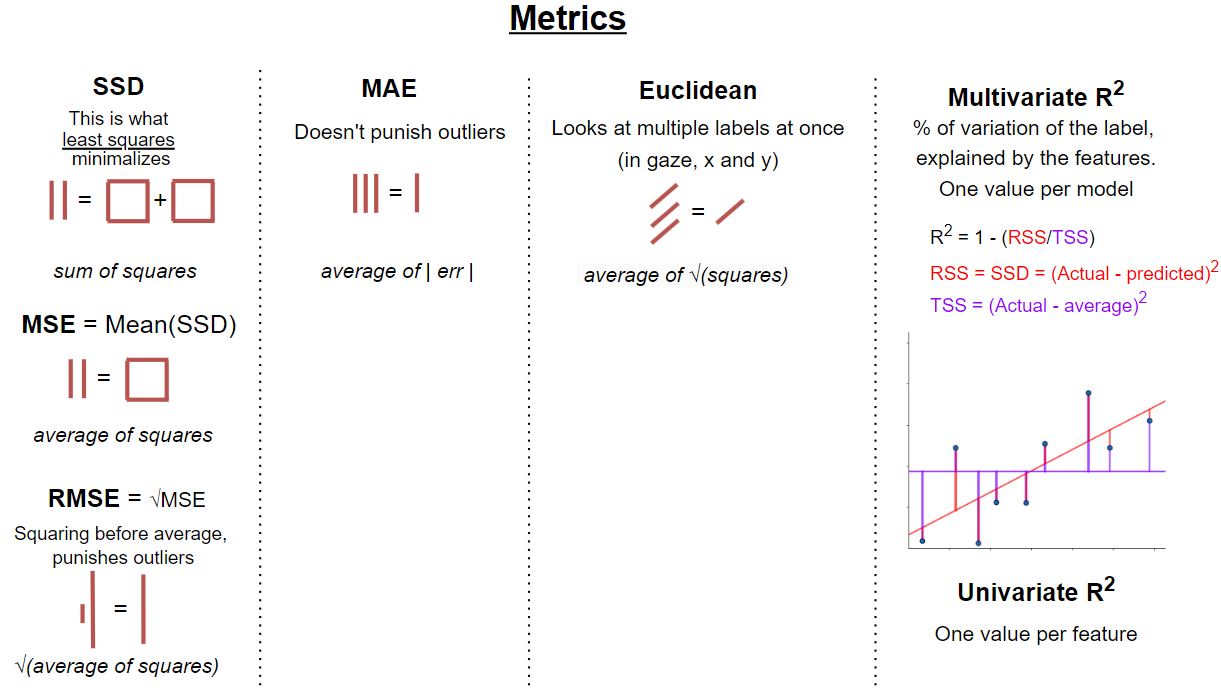

#### Classification

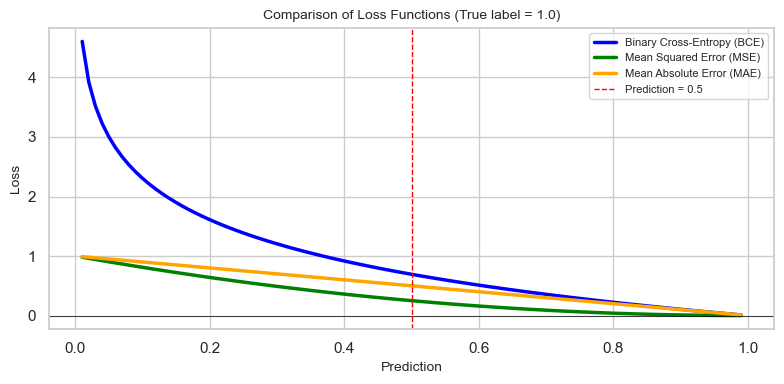


### Regularization

#### L1 and L2 regularization - See W06/02-gaze

#### Dropout

Randomly "drops" (deactivates / sets activation to 0) neurons during training 
    1. Prevents Overfitting by: 
        ◦ Forcing the network to learn with different neurons. So network won't rely on any 1 node. 
        ◦ Preventing co-adaptation of neurons (neurons becoming too dependent on each other) 
    2. Acts like Model Averaging: 
        ◦ Each training pass uses a different "thinned" network 
        ◦ At test time, approximates averaging many neural networks 

#### Early stopping

**For implementation see: trainer.train_es() in trainers.py**

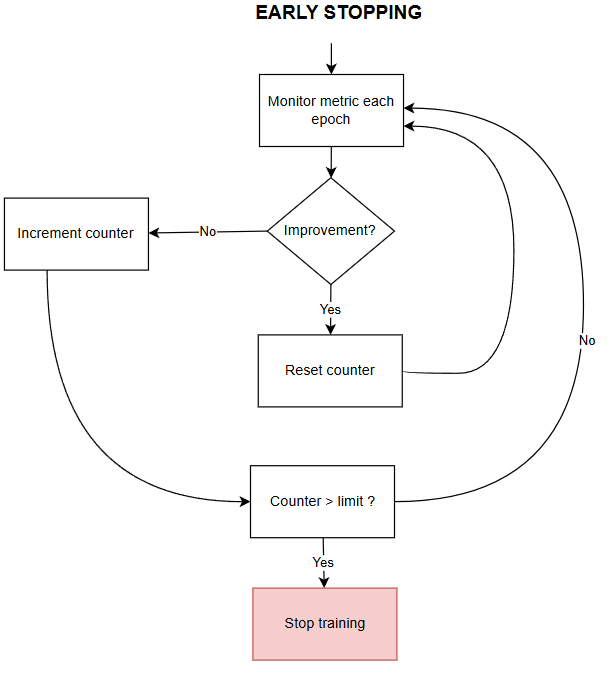

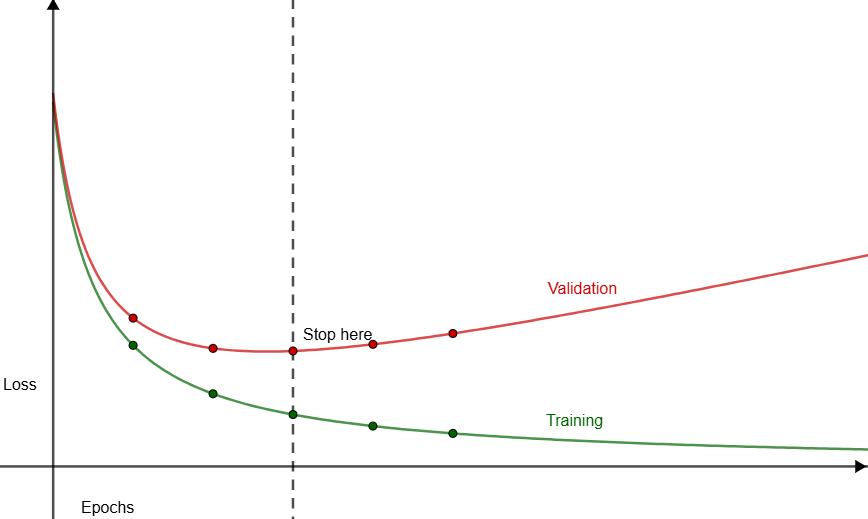

### Data augmentation (imbalance, noise, outliers, missing data) - See W08/02-filter

### Model complexity

Polynomial regression, see W06/02-gaze.
The equivalent for NN are: **Number of hidden layers**, **Number of nodes in layers**

### Cross-validation - See W14/03-tutorial

### Bias-variance - See W06/02
